In [20]:
import sys
from pathlib import Path
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
from src.utils.paths import load_paths
paths = load_paths()


## 0. Imports and code config

In [21]:
# === 0) Imports & core config ===
# !pip install -q pybioclip scikit-learn pandas numpy pillow torch

import json, random, hashlib, os, time
from pathlib import Path
from collections import defaultdict
from datetime import datetime

import numpy as np
import pandas as pd
from PIL import Image
import torch

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# BioCLIP: used as a feature extractor (image -> embedding vector)
from bioclip.predict import BaseClassifier

# ---- paths (adjust these if needed) ----
CLASS_NAMES = paths['processed_dir'] / 'class_names_no_ixodes.json'   # species list
DATA        = paths['processed_dir'] / 'final_data_no_ixodes.json'    # records: image_path, true_label, sample_id, view

# ---- experiment knobs (global conventions we agreed) ----
SHOTS      = [1, 3, 5, 10, 25]   # K values to sweep
RUNS       = 100             # number of Monte Carlo runs per shots level
BASE_SEED  = 42              # base for deterministic seed derivation
BAND       = "sd"            # "sd" 
MIN_TOTAL  = 30              # species must have >=30 individuals

# ---- results locations ----
# Base results directory from config
SVM_RESULTS = paths.get('svm_results_dir', paths['results_dir'] / 'svm')
if isinstance(SVM_RESULTS, str):
    SVM_RESULTS = paths['results_dir'].parent / SVM_RESULTS
SVM_RESULTS.mkdir(parents=True, exist_ok=True)

# Each run gets a timestamped folder: results/svm/runs/YYMMDD_HHMMSS/
RUN_ID = datetime.now().strftime("%y%m%d_%H%M%S")
RUN_DIR = SVM_RESULTS / "runs" / RUN_ID
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Outputs for this run
PREDICTIONS_CSV = RUN_DIR / "predictions.csv"
PLOTS_DIR = RUN_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
ANALYSIS_DIR = RUN_DIR / "analysis"
ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

# Aggregated results (across all runs) go in results/svm/aggregated/
AGGREGATED_DIR = SVM_RESULTS / "aggregated"
AGGREGATED_DIR.mkdir(parents=True, exist_ok=True)

# ---- preview/save controls (you can flip these later) ----
PREVIEW_PLOTS = True   # show plots inline while iterating
SAVE_PLOTS    = False   # save PNGs to PLOTS_DIR

# ---- per-image embedding cache (under data/processed/) ----
EMB_CACHE = paths['emb_cache_dir']
EMB_CACHE.mkdir(parents=True, exist_ok=True)

# ---- device + model init ----
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
BC = BaseClassifier(device=DEVICE)

# ---- helpers ----
def seed_for(shots: int, run_id: int, base: int = BASE_SEED) -> int:
    """
    Independent few-shot: unique seed per (shots K, run_id).
    Prevents 'growing' the same cohort across K.
    """
    return int(base + 10_000 * shots + run_id)

# optional: fix global RNGs for any non-swept randomness
random.seed(BASE_SEED)
np.random.seed(BASE_SEED)

# canonical class order placeholder (set after Block 1 once we know retained species)
CLASS_ORDER = None

# ---- run-time banner ----
print("=" * 60)
print("SVM Few-Shot Classification Pipeline")
print("=" * 60)
print(f"Run ID:           {RUN_ID}")
print(f"Run directory:    {RUN_DIR.resolve()}")
print(f"Predictions CSV:  {PREDICTIONS_CSV.resolve()}")
print(f"Plots dir:        {PLOTS_DIR.resolve()}")
print(f"Analysis dir:     {ANALYSIS_DIR.resolve()}")
print(f"Embedding cache:  {EMB_CACHE.resolve()}")
print(f"Device:           {DEVICE}")
print(f"Config -> SHOTS: {SHOTS} | RUNS: {RUNS} | MIN_TOTAL: {MIN_TOTAL}")
print("=" * 60)

SVM Few-Shot Classification Pipeline
Run ID:           260206_063753
Run directory:    /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753
Predictions CSV:  /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753/predictions.csv
Plots dir:        /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753/plots
Analysis dir:     /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753/analysis
Embedding cache:  /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed/emb_cache
Device:           mps
Config -> SHOTS: [1, 3, 5, 10, 25] | RUNS: 100 | MIN_TOTAL: 30


## 1. Load classes and Specimens

In [22]:
# === Block 1 — Load Classes and Data → Build Specimen Index (clean version) ===

# 1) Load class list and data
with open(CLASS_NAMES, "r") as f:
    SPECIES_LIST = set(json.load(f))

with open(DATA, "r") as f:
    data = json.load(f)  # list of records (image_path, true_label, sample_id, view)

# 2) Build specimen index:
#    by_species[species][sample_id] -> {"dorsal": <path>, "ventral": <path>}
by_species = defaultdict(lambda: defaultdict(dict))
for r in data:
    sp = r["true_label"]
    if sp not in SPECIES_LIST:
        continue
    sid  = r["sample_id"]
    view = str(r["view"]).strip().lower()
    by_species[sp][sid][view] = r["image_path"]

# 3) Keep only specimens with BOTH views
for sp in list(by_species.keys()):
    for sid in list(by_species[sp].keys()):
        views = by_species[sp][sid]
        if not ("dorsal" in views and "ventral" in views):
            del by_species[sp][sid]
    if not by_species[sp]:
        del by_species[sp]

# 4) Enforce ≥ MIN_TOTAL individuals per species
for sp in list(by_species.keys()):
    if len(by_species[sp]) < MIN_TOTAL:
        del by_species[sp]

included_species = sorted(by_species.keys())

# 5) Set canonical class order for downstream plots/matrices
CLASS_ORDER = included_species[:]  # global consistent order

# 6) Print summary
n_specimens = sum(len(smap) for smap in by_species.values())
print(f"Included species: {len(included_species)}")
print(f"Total usable specimens (both views, species ≥ {MIN_TOTAL}): {n_specimens}")
for sp in included_species:
    print(f"  {sp}: {len(by_species[sp])} specimens")

assert len(included_species) > 0, "No species meet the criteria (both views and MIN_TOTAL)."
print("CLASS_ORDER set for downstream use:", CLASS_ORDER)

Included species: 4
Total usable specimens (both views, species ≥ 30): 572
  Amblyomma americanum: 90 specimens
  Dermacentor variabilis: 308 specimens
  Haemaphysalis longicornis: 35 specimens
  Ixodes scapularis: 139 specimens
CLASS_ORDER set for downstream use: ['Amblyomma americanum', 'Dermacentor variabilis', 'Haemaphysalis longicornis', 'Ixodes scapularis']


## Block 2 Train test split

In [23]:
# === Block 2 — Train/Test Split (shots-aware, Seeded, prints) ===
def split_for_run(by_species, species_list, k, run_id):
    """Independent split for this (K=k, run_id) using the new seed_for()."""
    seed = seed_for(k, run_id)         # <- uses your new Block-0 seed_for
    return split_once(by_species, species_list, k=k, seed=seed)

def split_once(by_species, species_list, k, seed):
    rng = random.Random(seed)
    train_pairs, test_pairs = [], []
    per_species_counts = {}

    for sp in species_list:
        sids = list(by_species[sp].keys())
        rng.shuffle(sids)
        tr, te = sids[:k], sids[k:]

        # Sanity checks per your policy
        assert len(tr) == k, f"{sp}: needs exactly {k} train specimens, found {len(tr)}"
        assert len(te) >= 1, f"{sp}: needs at least 1 test specimen (has {len(sids)} total)"

        train_pairs.extend([(sp, sid) for sid in tr])
        test_pairs.extend([(sp, sid) for sid in te])
        per_species_counts[sp] = {"train": len(tr), "test": len(te), "total": len(sids)}

    # No leakage: specimen (sample_id) cannot be in both sets
    assert not (set(train_pairs) & set(test_pairs)), "Leakage detected: same (species, sample_id) in train & test"

    n_test_run = len(test_pairs)
    return train_pairs, test_pairs, per_species_counts, n_test_run


# --- Example single-run preview (keep this pattern for ad-hoc checks) ---
K_demo    = 5          # can use 1 / 3 / 10 too
RUN_demo  = 0          # change this to see different runs at same K

train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
    by_species, included_species, k=K_demo, run_id=RUN_demo
)

# ---- Summary prints (unchanged style) ----
n_species = len(included_species)
n_train   = len(train_pairs)
n_test    = len(test_pairs)

print(f"(K, run) = ({K_demo}, {RUN_demo}) | seed = {seed_for(K_demo, RUN_demo)}")
print(f"Species included: {n_species}")
print(f"Train specimens: {n_train}  (expected {K_demo} × {n_species} = {K_demo*n_species})")
print(f"Test specimens:  {n_test}")

for sp in included_species:
    c = split_counts[sp]
    print(f"  {sp}: total={c['total']}, train={c['train']}, test={c['test']}")

# Optional: peek a few chosen IDs per species
for sp in included_species:
    chosen = [sid for (s, sid) in train_pairs if s == sp][:min(3, K_demo)]
    print(f"  Train IDs sample — {sp}: {chosen}")

(K, run) = (5, 0) | seed = 50042
Species included: 4
Train specimens: 20  (expected 5 × 4 = 20)
Test specimens:  552
  Amblyomma americanum: total=90, train=5, test=85
  Dermacentor variabilis: total=308, train=5, test=303
  Haemaphysalis longicornis: total=35, train=5, test=30
  Ixodes scapularis: total=139, train=5, test=134
  Train IDs sample — Amblyomma americanum: ['37-01', 'ZOE-0014-01', 'ZOE-0014-03']
  Train IDs sample — Dermacentor variabilis: ['299-01', '424-01', 'ZOE-0088-02']
  Train IDs sample — Haemaphysalis longicornis: ['47-03', 'OPL-0102-03', '53-05']
  Train IDs sample — Ixodes scapularis: ['250-01', '339-01', '219-01']


## Block 3: Embedding helpers, getting the embeddings and building our Cache. 

In [24]:
# === Block 3 — Embedding Helpers (Per-Image Cache + Specimen Vector) ===

# Per-image cache filename (hash of the image path -> unique + reproducible)
def _cache_fp(img_path: str) -> Path:
    h = hashlib.sha256(img_path.encode("utf-8")).hexdigest()[:24]
    return EMB_CACHE / f"{h}.npy"

# Single-image -> embedding (uses cache if available)
def embed_image(img_path: str) -> np.ndarray:
    """
    Input:  path to an image file
    Output: 1D numpy array (BioCLIP embedding), L2-normalized if normalize=True in create_image_features
    """
    fp = _cache_fp(img_path)
    if fp.exists():
        return np.load(fp)
    pil = Image.open(img_path).convert("RGB")
    vec = BC.create_image_features([pil], normalize=True).cpu().numpy()[0]
    np.save(fp, vec)
    return vec

# Specimen-level vector: average dorsal + ventral embeddings -> one vector per specimen
def specimen_vec(rec: dict) -> np.ndarray:
    """
    rec is: {"dorsal": <path>, "ventral": <path>}
    Returns a single vector for the specimen: 0.5*(z_dorsal + z_ventral)
    """
    z_d = embed_image(rec["dorsal"])
    z_v = embed_image(rec["ventral"])
    return 0.5 * (z_d + z_v)

## Block 4- build X/Y, Train SVM, Metrics, SINGLE SEED

In [25]:
# === Block 4 — Build X/y, Train SVM, Predict, Collect Rows (per run) ===

# helper: turn (species, sample_id) pairs into X (embeddings) and y (labels)
def build_xy(by_species, pairs):
    X, y, ids = [], [], []
    for sp, sid in pairs:
        rec = by_species[sp][sid]          # {"dorsal":..., "ventral":...}
        X.append(specimen_vec(rec))        # averaged dorsal+ventral embedding
        y.append(sp)                       # species label
        ids.append(sid)                    # specimen ID for reporting
    return np.stack(X), np.array(y), ids


def train_predict_collect(by_species,
                          train_pairs, test_pairs,
                          *,
                          shots: int, run_id: int, n_test_run: int):
    """
    Trains the SVM on the given split and collects per-specimen rows for master CSV.
    Returns:
      pred_rows       : list[dict]  (rows for master_predictions.csv)
      per_class_df    : DataFrame  (class_acc, n_test_class)
      macro_acc       : float
      overall_acc     : float
      y_true, y_pred  : np.ndarray, np.ndarray  (for confusion / preview plots)
    """

    # --- Derive the run-specific seed HERE to guarantee independence
    seed = seed_for(shots, run_id)

    # --- Build train/test matrices
    Xtr, ytr, _      = build_xy(by_species, train_pairs)
    Xte, yte, te_ids = build_xy(by_species, test_pairs)

    # --- SVM pipeline (scale → RBF SVM); probability=True to get confidence
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=seed))
    ])

    # --- Train + predict
    clf.fit(Xtr, ytr)
    yhat  = clf.predict(Xte)
    probs = clf.predict_proba(Xte)
    conf  = probs.max(axis=1)   # top-class probability per specimen

    # --- Metrics (overall + macro balanced)
    overall_acc = accuracy_score(yte, yhat)

    tmp = pd.DataFrame({"true": yte, "pred": yhat})
    per_species_acc = (
        tmp.assign(hit=(tmp.true == tmp.pred).astype(int))
           .groupby("true")["hit"].mean()
    )
    macro_acc = float(per_species_acc.mean())

    # --- Per-class table (for quick prints + later aggregation if needed)
    per_class_df = (
        tmp.assign(hit=(tmp.true == tmp.pred).astype(int), one=1)
           .groupby("true")
           .agg(class_acc=("hit", "mean"), n_test_class=("one", "sum"))
           .rename_axis("class")
           .reset_index()
    )

    # --- Prepare rows for master CSV (do NOT save here; Block 5 will append)
    pred_rows = []
    for sid, t, p, c in zip(te_ids, yte, yhat, conf):
        pred_rows.append({
            "shots": int(shots),
            "run_id": int(run_id),
            "seed": int(seed),           # keep seed recorded for repro
            "sample_id": str(sid),
            "species_true": str(t),
            "species_pred": str(p),
            "correct": int(t == p),
            "conf_top1": float(c),
            "n_test_run": int(n_test_run)
        })

    # --- Prints (same vibe as your original cell)
    print(f"Seed: {seed} | Shots: {shots} | Run: {run_id}")
    print(f"Overall accuracy: {overall_acc:.3f}")
    print(f"Macro (balanced) accuracy: {macro_acc:.3f}")
    preview = pd.DataFrame({
        "sample_id": te_ids[:10],
        "true_label": yte[:10],
        "pred_label": yhat[:10],
        "pred_confidence": conf[:10]
    })
    display(preview)

    return pred_rows, per_class_df, macro_acc, overall_acc, yte, yhat


In [26]:
# --- one demo run to produce the variables Block 5 needs ---

# tiny helper so we always derive the seed from (K, run_id) in one place
def split_for_run(by_species, species_list, k, run_id):
    return split_once(by_species, species_list, k=k, seed=seed_for(k, run_id))

# pick a shots/run pair (change as you like)
shots  = 5
run_id = 0

# make the split (independent per (K, run))
train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
    by_species, included_species, k=shots, run_id=run_id
)

# train & predict (Block 4 now derives seed internally via seed_for(shots, run_id))
pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred = train_predict_collect(
    by_species, train_pairs, test_pairs,
    shots=shots, run_id=run_id, n_test_run=n_test_run
)

# quick sanity check so you KNOW they exist
print("pred_rows:", len(pred_rows), "rows")
print("macro_acc:", macro_acc, "overall_acc:", overall_acc)

Seed: 50042 | Shots: 5 | Run: 0
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.463868
1,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.337792
2,56-02,Amblyomma americanum,Amblyomma americanum,0.361626
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.330214
4,363-01,Amblyomma americanum,Amblyomma americanum,0.349722
5,61-01,Amblyomma americanum,Amblyomma americanum,0.410023
6,50-01,Amblyomma americanum,Amblyomma americanum,0.347527
7,252-01,Amblyomma americanum,Amblyomma americanum,0.362514
8,43-12,Amblyomma americanum,Amblyomma americanum,0.461175
9,241-01,Amblyomma americanum,Amblyomma americanum,0.319888


pred_rows: 552 rows
macro_acc: 0.8043087561609541 overall_acc: 0.8768115942028986


## Block 5 Reporting and saving results for a single seed


Run 0 (seed=50042) — Shots 5 | Overall: 0.877 | Macro: 0.804


,species,n_test,n_correct,accuracy_species,shots,seed
3,Ixodes scapularis,134,126,0.940,5,50042
1,Dermacentor variabilis,303,277,0.914,5,50042
0,Amblyomma americanum,85,62,0.729,5,50042
2,Haemaphysalis longicornis,30,19,0.633,5,50042



[INFO] This is a single demo run. Use Block 6 to run the full Monte Carlo sweep.
[INFO] Results will be saved to: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753/predictions.csv


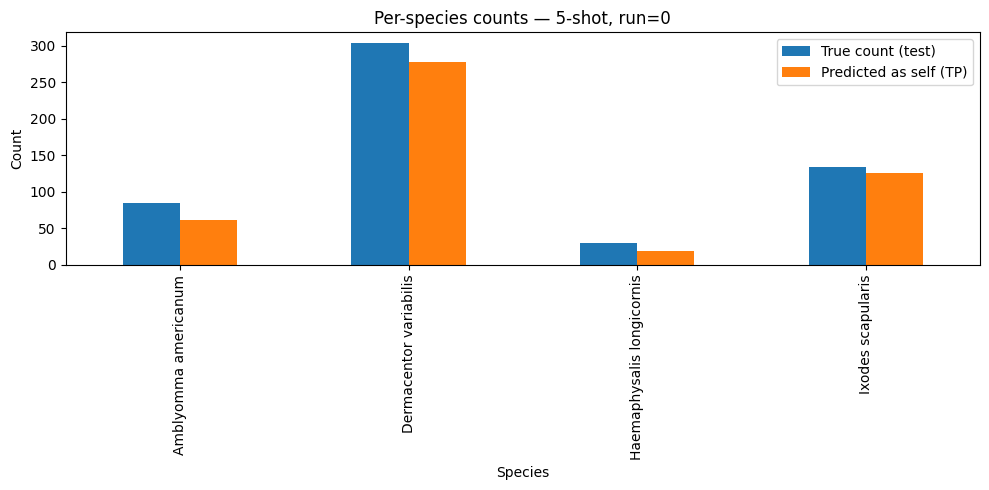


Confusion table (counts) — 5-shot, run=0


pred,Amblyomma americanum,Dermacentor variabilis,Haemaphysalis longicornis,Ixodes scapularis
true,,,,
Amblyomma americanum,62,3,18,2
Dermacentor variabilis,15,277,10,1
Haemaphysalis longicornis,10,0,19,1
Ixodes scapularis,0,1,7,126


In [27]:
# === Block 5 — Single-run reporting (preview only, no saving yet) ===
# Uses from Block 4: pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred
# Globals: CLASS_ORDER, PREVIEW_PLOTS, PLOTS_DIR

import matplotlib.pyplot as plt

# ---- 1) Collect run metadata ----
df_run = pd.DataFrame(pred_rows)
shots  = int(df_run["shots"].iloc[0])
run_id_val = int(df_run["run_id"].iloc[0])

# Prefer the recorded seed; if missing, recompute from (shots, run_id) to keep independence invariant.
if "seed" in df_run.columns and not pd.isna(df_run["seed"].iloc[0]):
    seed = int(df_run["seed"].iloc[0])
else:
    seed = seed_for(shots, run_id_val)

# ---- 2) Per-species summary table ----
tmp = pd.DataFrame({"true": y_true, "pred": y_pred})
per_species = (
    tmp.assign(hit=(tmp.true == tmp.pred).astype(int), one=1)
       .groupby("true")
       .agg(n_test=("one","sum"), n_correct=("hit","sum"))
       .assign(accuracy_species=lambda d: d.n_correct / d.n_test)
       .reset_index()
       .rename(columns={"true": "species"})
)
per_species["shots"] = shots
per_species["seed"]  = seed

with pd.option_context('display.float_format', '{:.3f}'.format):
    print(f"\nRun {run_id_val} (seed={seed}) — Shots {shots} "
          f"| Overall: {overall_acc:.3f} | Macro: {macro_acc:.3f}")
    display(per_species.sort_values("accuracy_species", ascending=False))

# ---- 3) Preview: This is a demo run. Full sweep happens in Block 6 ----
print(f"\n[INFO] This is a single demo run. Use Block 6 to run the full Monte Carlo sweep.")
print(f"[INFO] Results will be saved to: {PREDICTIONS_CSV}")

# ---- 4) Optional quick diagnostic plot for this run ----
if PREVIEW_PLOTS:
    # two-bar per-species: True count vs correctly predicted
    plot_df = (
        per_species.set_index("species")[["n_test","n_correct"]]
                   .reindex(CLASS_ORDER, fill_value=0) if 'CLASS_ORDER' in globals() and CLASS_ORDER is not None
                   else per_species.set_index("species")[["n_test","n_correct"]]
    )
    ax = plot_df.plot(kind="bar", figsize=(10,5), color=["#1f77b4", "#ff7f0e"])
    ax.set_title(f"Per-species counts — {shots}-shot, run={run_id_val}")
    ax.set_xlabel("Species"); ax.set_ylabel("Count")
    ax.legend(["True count (test)", "Predicted as self (TP)"])
    plt.tight_layout()
    plt.show()

    # optional plain confusion table for inspection (numbers only)
    conf_tbl = (
        pd.crosstab(pd.Series(y_true, name="true", dtype=object),
                    pd.Series(y_pred, name="pred", dtype=object))
    )
    if 'CLASS_ORDER' in globals() and CLASS_ORDER is not None:
        conf_tbl = conf_tbl.reindex(index=CLASS_ORDER, columns=CLASS_ORDER, fill_value=0)
    else:
        conf_tbl = conf_tbl.fillna(0).astype(int)
    print(f"\nConfusion table (counts) — {shots}-shot, run={run_id_val}")
    display(conf_tbl.astype(int))

## Block 6 Monte Carlo, 100 seeds. 

In [28]:
# === Block 6 — Monte Carlo sweep (shots × RUNS), saves to PREDICTIONS_CSV ===
# Assumes Blocks 0–5 are loaded.

from tqdm import tqdm
import traceback

print(f"[INIT] Starting Monte Carlo sweep")
print(f"[INIT] Run ID: {RUN_ID}")
print(f"[INIT] Output: {PREDICTIONS_CSV}")
print(f"[INIT] Shots: {SHOTS} | Runs per shot: {RUNS}")

# Turn off any preview/saving during the sweep
_PREV, _SAVE = globals().get("PREVIEW_PLOTS", False), globals().get("SAVE_PLOTS", False)
PREVIEW_PLOTS, SAVE_PLOTS = False, False

failed_runs = []   # (shots, run_id, error_message)
all_pred_rows = [] # collect all predictions here

# (optional) helper to keep split seeding consistent in one place
def split_for_run(by_species, species_list, k, run_id):
    return split_once(by_species, species_list, k=k, seed=seed_for(k, run_id))

for shots in SHOTS:                             # e.g., [1, 3, 5, 10, 25]
    pbar = tqdm(range(RUNS), desc=f"{shots}-shot runs", leave=True)
    for run_id in pbar:                         # 0..RUNS-1
        try:
            # 1) Split — seed derived from (shots, run_id) for independence
            train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
                by_species, included_species, k=shots, run_id=run_id
            )

            # 2) Train + predict + collect rows
            pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred = train_predict_collect(
                by_species, train_pairs, test_pairs,
                shots=shots, run_id=run_id, n_test_run=n_test_run
            )

            # 3) Collect predictions
            all_pred_rows.extend(pred_rows)

            # Update tqdm summary
            pbar.set_postfix(rows=len(pred_rows),
                             macro=f"{macro_acc:.3f}", overall=f"{overall_acc:.3f}")

        except Exception as e:
            failed_runs.append((shots, run_id, str(e)))
            print(f"[ERROR] shots={shots} run_id={run_id} | {e}")
            # traceback.print_exc()  # uncomment for deep debugging

# Restore flags
PREVIEW_PLOTS, SAVE_PLOTS = _PREV, _SAVE

# --- Save all predictions to PREDICTIONS_CSV ---
df_all = pd.DataFrame(all_pred_rows)
df_all["sample_id"] = df_all["sample_id"].astype(str)
df_all.to_csv(PREDICTIONS_CSV, index=False)

# --- Sweep summary + sanity checks ---
print("\n" + "=" * 60)
print("Block 6 sweep complete")
print("=" * 60)
print(f"Run ID: {RUN_ID}")
print(f"Predictions file: {PREDICTIONS_CSV}")
print(f"Total rows written: {len(df_all)}")

if len(failed_runs):
    print(f"\nFailures: {len(failed_runs)}")
    for shots_, run_id_, msg in failed_runs[:10]:
        print(f"  shots={shots_} run_id={run_id_} -> {msg}")
    if len(failed_runs) > 10:
        print("  ... (truncated)")

# Quick duplicate sanity check on keys
n_dupes = df_all.duplicated(subset=["shots", "run_id", "sample_id"]).sum()
print(f"Duplicate rows on (shots, run_id, sample_id): {n_dupes}")

# Summary stats
print(f"\nPredictions breakdown:")
for K in SHOTS:
    count = len(df_all[df_all["shots"] == K])
    print(f"  {K}-shot: {count} rows")

print("=" * 60)

[INIT] Starting Monte Carlo sweep
[INIT] Run ID: 260206_063753
[INIT] Output: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753/predictions.csv
[INIT] Shots: [1, 3, 5, 10, 25] | Runs per shot: 100


1-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 10042 | Shots: 1 | Run: 0
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.617


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.254003
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.252118
3,50-02,Amblyomma americanum,Amblyomma americanum,0.250000
4,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
7,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,34-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:   1%|          | 1/100 [00:00<00:25,  3.87it/s, macro=0.617, overall=0.803, rows=568]

Seed: 10043 | Shots: 1 | Run: 1
Overall accuracy: 0.762
Macro (balanced) accuracy: 0.591


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Dermacentor variabilis,0.250000
1,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.251193
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.251413
3,37-02,Amblyomma americanum,Amblyomma americanum,0.250000
4,139-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.250000
6,342-01,Amblyomma americanum,Dermacentor variabilis,0.250000
7,42-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,56-05,Amblyomma americanum,Dermacentor variabilis,0.250000
9,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:   1%|          | 1/100 [00:00<00:25,  3.87it/s, macro=0.591, overall=0.762, rows=568]

Seed: 10044 | Shots: 1 | Run: 2
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,37-03,Amblyomma americanum,Amblyomma americanum,0.250997
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.250783
4,43-16,Amblyomma americanum,Ixodes scapularis,0.251242
5,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.250901
7,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,428-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:   3%|▎         | 3/100 [00:00<00:13,  7.44it/s, macro=0.726, overall=0.826, rows=568]

Seed: 10045 | Shots: 1 | Run: 3
Overall accuracy: 0.822
Macro (balanced) accuracy: 0.686


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.250000
1,150-01,Amblyomma americanum,Amblyomma americanum,0.253020
2,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.250947
4,143-01,Amblyomma americanum,Amblyomma americanum,0.251579
5,342-01,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.251985
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.258150


1-shot runs:   3%|▎         | 3/100 [00:00<00:13,  7.44it/s, macro=0.686, overall=0.822, rows=568]

Seed: 10046 | Shots: 1 | Run: 4
Overall accuracy: 0.738
Macro (balanced) accuracy: 0.498


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.254853
1,56-05,Amblyomma americanum,Dermacentor variabilis,0.253348
2,61-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,31-03,Amblyomma americanum,Dermacentor variabilis,0.251766
4,ZOE-0014-15,Amblyomma americanum,Dermacentor variabilis,0.253301
5,37-03,Amblyomma americanum,Dermacentor variabilis,0.251456
6,241-01,Amblyomma americanum,Ixodes scapularis,0.253621
7,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.253670
8,191-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,40-02,Amblyomma americanum,Dermacentor variabilis,0.253714


1-shot runs:   5%|▌         | 5/100 [00:00<00:10,  8.99it/s, macro=0.498, overall=0.738, rows=568]

Seed: 10047 | Shots: 1 | Run: 5
Overall accuracy: 0.641
Macro (balanced) accuracy: 0.559


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,337-01,Amblyomma americanum,Dermacentor variabilis,0.251298
2,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.251718
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.254649
4,43-15,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
6,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,31-03,Amblyomma americanum,Amblyomma americanum,0.250953
8,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.253583
9,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:   5%|▌         | 5/100 [00:00<00:10,  8.99it/s, macro=0.559, overall=0.641, rows=568]

Seed: 10048 | Shots: 1 | Run: 6
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.727


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,252-01,Amblyomma americanum,Amblyomma americanum,0.251649
2,528-01,Amblyomma americanum,Amblyomma americanum,0.250959
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.252908
4,414-01,Amblyomma americanum,Amblyomma americanum,0.254283
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250987
6,35-02,Amblyomma americanum,Ixodes scapularis,0.250000
7,362-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,69-01,Amblyomma americanum,Amblyomma americanum,0.250936
9,276-01,Amblyomma americanum,Amblyomma americanum,0.252387


1-shot runs:   7%|▋         | 7/100 [00:00<00:09,  9.88it/s, macro=0.727, overall=0.873, rows=568]

Seed: 10049 | Shots: 1 | Run: 7
Overall accuracy: 0.792
Macro (balanced) accuracy: 0.592


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.255745
1,195-01,Amblyomma americanum,Amblyomma americanum,0.252696
2,150-01,Amblyomma americanum,Amblyomma americanum,0.257283
3,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.253553
4,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.251708
6,61-01,Amblyomma americanum,Amblyomma americanum,0.252819
7,427-01,Amblyomma americanum,Amblyomma americanum,0.258442
8,37-02,Amblyomma americanum,Dermacentor variabilis,0.254476
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.252928


1-shot runs:   7%|▋         | 7/100 [00:00<00:09,  9.88it/s, macro=0.592, overall=0.792, rows=568]

Seed: 10050 | Shots: 1 | Run: 8
Overall accuracy: 0.741
Macro (balanced) accuracy: 0.558


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Dermacentor variabilis,0.250000
1,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,191-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,61-03,Amblyomma americanum,Dermacentor variabilis,0.255645
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.252079
6,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.251600
7,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.252971
9,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.254057


1-shot runs:   9%|▉         | 9/100 [00:00<00:08, 10.41it/s, macro=0.558, overall=0.741, rows=568]

Seed: 10051 | Shots: 1 | Run: 9
Overall accuracy: 0.710
Macro (balanced) accuracy: 0.607


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.250831
3,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,405-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.251873
6,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,376-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:   9%|▉         | 9/100 [00:01<00:08, 10.41it/s, macro=0.607, overall=0.710, rows=568]

Seed: 10052 | Shots: 1 | Run: 10
Overall accuracy: 0.766
Macro (balanced) accuracy: 0.684


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.251429
1,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.250842
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.250000
3,201-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.252862
5,40-02,Amblyomma americanum,Ixodes scapularis,0.250000
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.251277
7,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.252120
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.253119
9,191-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  11%|█         | 11/100 [00:01<00:08, 10.78it/s, macro=0.684, overall=0.766, rows=568]

Seed: 10053 | Shots: 1 | Run: 11
Overall accuracy: 0.794
Macro (balanced) accuracy: 0.665


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
1,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.252758
2,195-01,Amblyomma americanum,Amblyomma americanum,0.250659
3,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,31-01,Amblyomma americanum,Amblyomma americanum,0.252674
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
8,414-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.253207


1-shot runs:  11%|█         | 11/100 [00:01<00:08, 10.78it/s, macro=0.665, overall=0.794, rows=568]

Seed: 10054 | Shots: 1 | Run: 12
Overall accuracy: 0.426
Macro (balanced) accuracy: 0.510


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.251719
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.253517
2,110-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.251566
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.252275
6,414-01,Amblyomma americanum,Amblyomma americanum,0.253467
7,56-05,Amblyomma americanum,Haemaphysalis longicornis,0.251024
8,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  13%|█▎        | 13/100 [00:01<00:07, 10.95it/s, macro=0.510, overall=0.426, rows=568]

Seed: 10055 | Shots: 1 | Run: 13
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.699


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Ixodes scapularis,0.251544
1,376-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,569-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,276-01,Amblyomma americanum,Amblyomma americanum,0.251903
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.250000
6,61-03,Amblyomma americanum,Amblyomma americanum,0.252240
7,69-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,42-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,50-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  13%|█▎        | 13/100 [00:01<00:07, 10.95it/s, macro=0.699, overall=0.789, rows=568]

Seed: 10056 | Shots: 1 | Run: 14
Overall accuracy: 0.820
Macro (balanced) accuracy: 0.678


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,61-03,Amblyomma americanum,Amblyomma americanum,0.253884
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.252320
3,42-01,Amblyomma americanum,Amblyomma americanum,0.251249
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.250000
5,342-01,Amblyomma americanum,Dermacentor variabilis,0.252158
6,405-01,Amblyomma americanum,Ixodes scapularis,0.250000
7,31-03,Amblyomma americanum,Amblyomma americanum,0.250000
8,19-01,Amblyomma americanum,Amblyomma americanum,0.250994
9,50-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  15%|█▌        | 15/100 [00:01<00:08, 10.37it/s, macro=0.678, overall=0.820, rows=568]

Seed: 10057 | Shots: 1 | Run: 15
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.772


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.250931
1,31-01,Amblyomma americanum,Amblyomma americanum,0.260854
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.251069
3,69-01,Amblyomma americanum,Amblyomma americanum,0.251366
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.250000
5,376-01,Amblyomma americanum,Amblyomma americanum,0.250744
6,42-02,Amblyomma americanum,Amblyomma americanum,0.259410
7,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.252376
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.251205
9,528-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  15%|█▌        | 15/100 [00:01<00:08, 10.37it/s, macro=0.772, overall=0.826, rows=568]

Seed: 10058 | Shots: 1 | Run: 16
Overall accuracy: 0.771
Macro (balanced) accuracy: 0.595


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,35-02,Amblyomma americanum,Amblyomma americanum,0.258007
2,241-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,43-16,Amblyomma americanum,Amblyomma americanum,0.252183
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.250000
6,528-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,40-02,Amblyomma americanum,Amblyomma americanum,0.252104
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,56-05,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  17%|█▋        | 17/100 [00:01<00:08, 10.34it/s, macro=0.595, overall=0.771, rows=568]

Seed: 10059 | Shots: 1 | Run: 17
Overall accuracy: 0.783
Macro (balanced) accuracy: 0.671


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,241-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,427-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,43-14,Amblyomma americanum,Amblyomma americanum,0.250000
6,61-03,Amblyomma americanum,Amblyomma americanum,0.251518
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  17%|█▋        | 17/100 [00:01<00:08, 10.34it/s, macro=0.671, overall=0.783, rows=568]

Seed: 10060 | Shots: 1 | Run: 18
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.732


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.260890
1,528-01,Amblyomma americanum,Amblyomma americanum,0.252558
2,35-01,Amblyomma americanum,Amblyomma americanum,0.254289
3,234-01,Amblyomma americanum,Amblyomma americanum,0.252735
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.259820
5,419-01,Amblyomma americanum,Amblyomma americanum,0.253309
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.255485
7,569-01,Amblyomma americanum,Amblyomma americanum,0.252923
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,48-01,Amblyomma americanum,Amblyomma americanum,0.253013


1-shot runs:  19%|█▉        | 19/100 [00:01<00:07, 10.23it/s, macro=0.732, overall=0.884, rows=568]

Seed: 10061 | Shots: 1 | Run: 19
Overall accuracy: 0.794
Macro (balanced) accuracy: 0.688


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Dermacentor variabilis,0.250000
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.250936
2,419-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,39-01,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.250000
8,501-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,43-16,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  19%|█▉        | 19/100 [00:02<00:07, 10.23it/s, macro=0.688, overall=0.794, rows=568]

Seed: 10062 | Shots: 1 | Run: 20
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.622


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,48-02,Amblyomma americanum,Dermacentor variabilis,0.252565
2,ZOE-0014-12,Amblyomma americanum,Ixodes scapularis,0.259913
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
4,337-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.255522
6,ZOE-0082-01,Amblyomma americanum,Dermacentor variabilis,0.250000
7,61-01,Amblyomma americanum,Amblyomma americanum,0.251291
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.253997
9,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.258288


1-shot runs:  21%|██        | 21/100 [00:02<00:07, 10.36it/s, macro=0.622, overall=0.813, rows=568]

Seed: 10063 | Shots: 1 | Run: 21
Overall accuracy: 0.290
Macro (balanced) accuracy: 0.421


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Amblyomma americanum,0.251447
1,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.250744
5,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.253459
6,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.251740
7,241-01,Amblyomma americanum,Ixodes scapularis,0.250000
8,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  21%|██        | 21/100 [00:02<00:07, 10.36it/s, macro=0.421, overall=0.290, rows=568]

Seed: 10064 | Shots: 1 | Run: 22
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.719


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.252514
1,56-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,42-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-18,Amblyomma americanum,Dermacentor variabilis,0.253327
4,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,39-01,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.250762
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.253382
8,19-02,Amblyomma americanum,Dermacentor variabilis,0.251984
9,241-01,Amblyomma americanum,Dermacentor variabilis,0.251646


1-shot runs:  23%|██▎       | 23/100 [00:02<00:07, 10.11it/s, macro=0.719, overall=0.835, rows=568]

Seed: 10065 | Shots: 1 | Run: 23
Overall accuracy: 0.368
Macro (balanced) accuracy: 0.338


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.250000
1,35-02,Amblyomma americanum,Amblyomma americanum,0.251246
2,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250995
3,139-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,37-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.251968
9,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.253025


1-shot runs:  23%|██▎       | 23/100 [00:02<00:07, 10.11it/s, macro=0.338, overall=0.368, rows=568]

Seed: 10066 | Shots: 1 | Run: 24
Overall accuracy: 0.710
Macro (balanced) accuracy: 0.495


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Ixodes scapularis,0.250000
1,195-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.251039
4,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,405-01,Amblyomma americanum,Amblyomma americanum,0.256033
6,43-16,Amblyomma americanum,Ixodes scapularis,0.250000
7,61-03,Amblyomma americanum,Ixodes scapularis,0.250000
8,56-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.252122


1-shot runs:  25%|██▌       | 25/100 [00:02<00:07, 10.06it/s, macro=0.495, overall=0.710, rows=568]

Seed: 10067 | Shots: 1 | Run: 25
Overall accuracy: 0.849
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
1,150-01,Amblyomma americanum,Amblyomma americanum,0.25
2,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.25
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.25
4,143-01,Amblyomma americanum,Amblyomma americanum,0.25
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.25
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.25
7,57-01,Amblyomma americanum,Amblyomma americanum,0.25
8,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.25
9,35-01,Amblyomma americanum,Amblyomma americanum,0.25


1-shot runs:  25%|██▌       | 25/100 [00:02<00:07, 10.06it/s, macro=0.799, overall=0.849, rows=568]

Seed: 10068 | Shots: 1 | Run: 26
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.653


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.250549
1,39-01,Amblyomma americanum,Amblyomma americanum,0.263207
2,342-01,Amblyomma americanum,Dermacentor variabilis,0.253581
3,376-01,Amblyomma americanum,Ixodes scapularis,0.250000
4,40-02,Amblyomma americanum,Amblyomma americanum,0.254181
5,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,43-15,Amblyomma americanum,Amblyomma americanum,0.257756
8,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,427-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  27%|██▋       | 27/100 [00:02<00:07, 10.10it/s, macro=0.653, overall=0.831, rows=568]

Seed: 10069 | Shots: 1 | Run: 27
Overall accuracy: 0.759
Macro (balanced) accuracy: 0.603


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.251858
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.251633
5,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,48-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,56-05,Amblyomma americanum,Dermacentor variabilis,0.250000
9,35-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  27%|██▋       | 27/100 [00:02<00:07, 10.10it/s, macro=0.603, overall=0.759, rows=568]

Seed: 10070 | Shots: 1 | Run: 28
Overall accuracy: 0.847
Macro (balanced) accuracy: 0.717


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.251638
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,252-01,Amblyomma americanum,Amblyomma americanum,0.250897
4,50-03,Amblyomma americanum,Amblyomma americanum,0.251492
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.251641
6,569-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.251286
8,37-01,Amblyomma americanum,Amblyomma americanum,0.251435
9,139-01,Amblyomma americanum,Amblyomma americanum,0.251000


1-shot runs:  29%|██▉       | 29/100 [00:02<00:06, 10.25it/s, macro=0.717, overall=0.847, rows=568]

Seed: 10071 | Shots: 1 | Run: 29
Overall accuracy: 0.734
Macro (balanced) accuracy: 0.642


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Ixodes scapularis,0.25
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
2,40-01,Amblyomma americanum,Amblyomma americanum,0.25
3,501-01,Amblyomma americanum,Dermacentor variabilis,0.25
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.25
5,191-01,Amblyomma americanum,Dermacentor variabilis,0.25
6,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.25
7,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.25
8,ZOE-0014-09,Amblyomma americanum,Dermacentor variabilis,0.25
9,ZOE-0014-17,Amblyomma americanum,Dermacentor variabilis,0.25


1-shot runs:  29%|██▉       | 29/100 [00:03<00:06, 10.25it/s, macro=0.642, overall=0.734, rows=568]

Seed: 10072 | Shots: 1 | Run: 30
Overall accuracy: 0.717
Macro (balanced) accuracy: 0.597


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,143-01,Amblyomma americanum,Amblyomma americanum,0.250696
2,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-13,Amblyomma americanum,Ixodes scapularis,0.250000
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.250000
5,31-03,Amblyomma americanum,Ixodes scapularis,0.250000
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.254943
7,50-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.252126
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.256379


1-shot runs:  31%|███       | 31/100 [00:03<00:06, 10.35it/s, macro=0.597, overall=0.717, rows=568]

Seed: 10073 | Shots: 1 | Run: 31
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.647


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Dermacentor variabilis,0.250000
1,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.250589
3,234-01,Amblyomma americanum,Amblyomma americanum,0.251789
4,376-01,Amblyomma americanum,Amblyomma americanum,0.251898
5,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,241-01,Amblyomma americanum,Amblyomma americanum,0.253652
8,43-12,Amblyomma americanum,Dermacentor variabilis,0.250000
9,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  31%|███       | 31/100 [00:03<00:06, 10.35it/s, macro=0.647, overall=0.787, rows=568]

Seed: 10074 | Shots: 1 | Run: 32
Overall accuracy: 0.776
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
1,69-02,Amblyomma americanum,Dermacentor variabilis,0.25
2,19-01,Amblyomma americanum,Ixodes scapularis,0.25
3,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
4,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.25
5,31-02,Amblyomma americanum,Ixodes scapularis,0.25
6,35-02,Amblyomma americanum,Amblyomma americanum,0.25
7,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.25
8,69-01,Amblyomma americanum,Amblyomma americanum,0.25
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.25


1-shot runs:  33%|███▎      | 33/100 [00:03<00:06, 10.28it/s, macro=0.726, overall=0.776, rows=568]

Seed: 10075 | Shots: 1 | Run: 33
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.659


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.254713
2,405-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,234-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.251183
7,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,191-01,Amblyomma americanum,Dermacentor variabilis,0.252631
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.251785


1-shot runs:  33%|███▎      | 33/100 [00:03<00:06, 10.28it/s, macro=0.659, overall=0.796, rows=568]

Seed: 10076 | Shots: 1 | Run: 34
Overall accuracy: 0.824
Macro (balanced) accuracy: 0.646


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.250000
1,139-01,Amblyomma americanum,Amblyomma americanum,0.252025
2,337-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,42-01,Amblyomma americanum,Amblyomma americanum,0.254617
4,ZOE-0014-11,Amblyomma americanum,Ixodes scapularis,0.252378
5,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.252906
6,528-01,Amblyomma americanum,Ixodes scapularis,0.250000
7,405-01,Amblyomma americanum,Ixodes scapularis,0.250000
8,241-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,491-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  35%|███▌      | 35/100 [00:03<00:06, 10.01it/s, macro=0.646, overall=0.824, rows=568]

Seed: 10077 | Shots: 1 | Run: 35
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.685


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Amblyomma americanum,0.251863
1,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.255465
2,19-01,Amblyomma americanum,Amblyomma americanum,0.252304
3,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.252627
4,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,376-01,Amblyomma americanum,Amblyomma americanum,0.251792
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.251477
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.251598
8,19-02,Amblyomma americanum,Amblyomma americanum,0.254820
9,31-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  35%|███▌      | 35/100 [00:03<00:06, 10.01it/s, macro=0.685, overall=0.838, rows=568]

Seed: 10078 | Shots: 1 | Run: 36
Overall accuracy: 0.790
Macro (balanced) accuracy: 0.685


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.252383
1,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0014-02,Amblyomma americanum,Ixodes scapularis,0.250000
3,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.251694
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
6,150-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,528-01,Amblyomma americanum,Amblyomma americanum,0.251778
8,ZOE-0014-08,Amblyomma americanum,Ixodes scapularis,0.250000
9,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  37%|███▋      | 37/100 [00:03<00:06,  9.78it/s, macro=0.685, overall=0.790, rows=568]

Seed: 10079 | Shots: 1 | Run: 37
Overall accuracy: 0.766
Macro (balanced) accuracy: 0.564


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.253681
1,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.251775
3,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.252891
4,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.255198
5,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.251649
6,69-02,Amblyomma americanum,Amblyomma americanum,0.253169
7,56-05,Amblyomma americanum,Ixodes scapularis,0.251207
8,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  38%|███▊      | 38/100 [00:03<00:06,  9.78it/s, macro=0.564, overall=0.766, rows=568]

Seed: 10080 | Shots: 1 | Run: 38
Overall accuracy: 0.572
Macro (balanced) accuracy: 0.451


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Ixodes scapularis,0.25000
1,43-16,Amblyomma americanum,Dermacentor variabilis,0.25000
2,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.25000
3,40-02,Amblyomma americanum,Dermacentor variabilis,0.25000
4,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.25000
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.25378
6,43-12,Amblyomma americanum,Amblyomma americanum,0.25000
7,31-03,Amblyomma americanum,Amblyomma americanum,0.25000
8,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.25000
9,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.25000


1-shot runs:  38%|███▊      | 38/100 [00:03<00:06,  9.78it/s, macro=0.451, overall=0.572, rows=568]

Seed: 10081 | Shots: 1 | Run: 39
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.703


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.251572
1,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.253915
3,143-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,491-01,Amblyomma americanum,Amblyomma americanum,0.252176
5,195-01,Amblyomma americanum,Amblyomma americanum,0.254257
6,19-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,43-16,Amblyomma americanum,Amblyomma americanum,0.253330
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.251033
9,31-01,Amblyomma americanum,Amblyomma americanum,0.256255


1-shot runs:  40%|████      | 40/100 [00:04<00:06,  9.95it/s, macro=0.703, overall=0.859, rows=568]

Seed: 10082 | Shots: 1 | Run: 40
Overall accuracy: 0.651
Macro (balanced) accuracy: 0.492


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.251136
3,56-05,Amblyomma americanum,Dermacentor variabilis,0.250000
4,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.253153
5,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.252094
6,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.253640
7,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,61-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  40%|████      | 40/100 [00:04<00:06,  9.95it/s, macro=0.492, overall=0.651, rows=568]

Seed: 10083 | Shots: 1 | Run: 41
Overall accuracy: 0.822
Macro (balanced) accuracy: 0.634


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,19-02,Amblyomma americanum,Amblyomma americanum,0.250000
2,61-03,Amblyomma americanum,Amblyomma americanum,0.251024
3,405-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,61-02,Amblyomma americanum,Amblyomma americanum,0.254807
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,569-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,35-01,Amblyomma americanum,Dermacentor variabilis,0.250000
8,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.250000
9,19-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  42%|████▏     | 42/100 [00:04<00:05,  9.89it/s, macro=0.634, overall=0.822, rows=568]

Seed: 10084 | Shots: 1 | Run: 42
Overall accuracy: 0.840
Macro (balanced) accuracy: 0.731


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.256251
1,465-01,Amblyomma americanum,Amblyomma americanum,0.251778
2,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.253659
3,342-02,Amblyomma americanum,Amblyomma americanum,0.252474
4,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.253689
5,201-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,311-01,Amblyomma americanum,Amblyomma americanum,0.252337
7,42-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.256350
9,42-01,Amblyomma americanum,Amblyomma americanum,0.252189


1-shot runs:  43%|████▎     | 43/100 [00:04<00:05,  9.87it/s, macro=0.731, overall=0.840, rows=568]

Seed: 10085 | Shots: 1 | Run: 43
Overall accuracy: 0.757
Macro (balanced) accuracy: 0.599


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Ixodes scapularis,0.250000
1,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,37-02,Amblyomma americanum,Ixodes scapularis,0.252402
3,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,43-12,Amblyomma americanum,Ixodes scapularis,0.252434
5,43-11,Amblyomma americanum,Ixodes scapularis,0.251801
6,143-01,Amblyomma americanum,Amblyomma americanum,0.251045
7,342-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,61-03,Amblyomma americanum,Amblyomma americanum,0.250000
9,40-02,Amblyomma americanum,Ixodes scapularis,0.252224


1-shot runs:  44%|████▍     | 44/100 [00:04<00:06,  8.47it/s, macro=0.599, overall=0.757, rows=568]

Seed: 10086 | Shots: 1 | Run: 44
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.620


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.251805
1,39-01,Amblyomma americanum,Dermacentor variabilis,0.252225
2,363-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,69-02,Amblyomma americanum,Ixodes scapularis,0.250000
4,405-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,48-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,56-05,Amblyomma americanum,Amblyomma americanum,0.250000
7,37-01,Amblyomma americanum,Dermacentor variabilis,0.250000
8,31-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,419-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  45%|████▌     | 45/100 [00:04<00:06,  8.32it/s, macro=0.620, overall=0.789, rows=568]

Seed: 10087 | Shots: 1 | Run: 45
Overall accuracy: 0.790
Macro (balanced) accuracy: 0.697


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Ixodes scapularis,0.250000
1,150-01,Amblyomma americanum,Amblyomma americanum,0.252536
2,419-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
6,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,40-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  46%|████▌     | 46/100 [00:04<00:06,  8.21it/s, macro=0.697, overall=0.790, rows=568]

Seed: 10088 | Shots: 1 | Run: 46
Overall accuracy: 0.798
Macro (balanced) accuracy: 0.680


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.250000
3,419-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.251824
5,31-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,50-03,Amblyomma americanum,Amblyomma americanum,0.250000
7,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.253007
8,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.250670


1-shot runs:  47%|████▋     | 47/100 [00:04<00:06,  8.27it/s, macro=0.680, overall=0.798, rows=568]

Seed: 10089 | Shots: 1 | Run: 47
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.253377
1,56-05,Amblyomma americanum,Amblyomma americanum,0.253188
2,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.255044
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.254935
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.256183
6,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
7,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,43-14,Amblyomma americanum,Amblyomma americanum,0.250000
9,569-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  48%|████▊     | 48/100 [00:04<00:06,  8.59it/s, macro=0.758, overall=0.803, rows=568]

Seed: 10090 | Shots: 1 | Run: 48
Overall accuracy: 0.799
Macro (balanced) accuracy: 0.662


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.252184
1,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.251034
2,143-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,61-02,Amblyomma americanum,Amblyomma americanum,0.251344
4,376-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,61-03,Amblyomma americanum,Amblyomma americanum,0.251735
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,19-02,Amblyomma americanum,Amblyomma americanum,0.252992
8,139-01,Amblyomma americanum,Amblyomma americanum,0.251687
9,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.251056


1-shot runs:  49%|████▉     | 49/100 [00:05<00:05,  8.75it/s, macro=0.662, overall=0.799, rows=568]

Seed: 10091 | Shots: 1 | Run: 49
Overall accuracy: 0.312
Macro (balanced) accuracy: 0.389


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Ixodes scapularis,0.252466
1,419-01,Amblyomma americanum,Amblyomma americanum,0.253107
2,37-01,Amblyomma americanum,Amblyomma americanum,0.256069
3,57-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,337-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,363-01,Amblyomma americanum,Amblyomma americanum,0.250716
7,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.252738
8,491-01,Amblyomma americanum,Amblyomma americanum,0.253644
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.252495


1-shot runs:  50%|█████     | 50/100 [00:05<00:05,  8.89it/s, macro=0.389, overall=0.312, rows=568]

Seed: 10092 | Shots: 1 | Run: 50
Overall accuracy: 0.776
Macro (balanced) accuracy: 0.597


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,376-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.251637
4,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  50%|█████     | 50/100 [00:05<00:05,  8.89it/s, macro=0.597, overall=0.776, rows=568]

Seed: 10093 | Shots: 1 | Run: 51
Overall accuracy: 0.717
Macro (balanced) accuracy: 0.569


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Ixodes scapularis,0.250966
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0013-02,Amblyomma americanum,Ixodes scapularis,0.250000
4,252-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,56-06,Amblyomma americanum,Dermacentor variabilis,0.250000
6,42-01,Amblyomma americanum,Amblyomma americanum,0.252240
7,35-01,Amblyomma americanum,Amblyomma americanum,0.252813
8,427-01,Amblyomma americanum,Ixodes scapularis,0.251332
9,342-02,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  52%|█████▏    | 52/100 [00:05<00:05,  9.56it/s, macro=0.569, overall=0.717, rows=568]

Seed: 10094 | Shots: 1 | Run: 52
Overall accuracy: 0.641
Macro (balanced) accuracy: 0.514


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.250982
1,191-01,Amblyomma americanum,Dermacentor variabilis,0.255870
2,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.256119
4,40-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,428-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,31-03,Amblyomma americanum,Amblyomma americanum,0.250000
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.253986
8,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.251523


1-shot runs:  52%|█████▏    | 52/100 [00:05<00:05,  9.56it/s, macro=0.514, overall=0.641, rows=568]

Seed: 10095 | Shots: 1 | Run: 53
Overall accuracy: 0.687
Macro (balanced) accuracy: 0.637


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.25463
1,31-02,Amblyomma americanum,Amblyomma americanum,0.25000
2,110-01,Amblyomma americanum,Ixodes scapularis,0.25000
3,19-02,Amblyomma americanum,Amblyomma americanum,0.25000
4,40-01,Amblyomma americanum,Amblyomma americanum,0.25000
5,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.25000
6,56-06,Amblyomma americanum,Amblyomma americanum,0.25000
7,311-01,Amblyomma americanum,Amblyomma americanum,0.25000
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.25000
9,342-02,Amblyomma americanum,Amblyomma americanum,0.25000


1-shot runs:  54%|█████▍    | 54/100 [00:05<00:04, 10.18it/s, macro=0.637, overall=0.687, rows=568]

Seed: 10096 | Shots: 1 | Run: 54
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.639


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
1,37-02,Amblyomma americanum,Amblyomma americanum,0.250000
2,362-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,342-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,139-01,Amblyomma americanum,Amblyomma americanum,0.251260
5,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.252050
6,61-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,342-02,Amblyomma americanum,Dermacentor variabilis,0.250896
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,405-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  54%|█████▍    | 54/100 [00:05<00:04, 10.18it/s, macro=0.639, overall=0.789, rows=568]

Seed: 10097 | Shots: 1 | Run: 55
Overall accuracy: 0.722
Macro (balanced) accuracy: 0.627


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.253507
2,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.251248
3,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,56-05,Amblyomma americanum,Haemaphysalis longicornis,0.251353
5,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,43-14,Amblyomma americanum,Dermacentor variabilis,0.250946
7,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,143-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,43-16,Amblyomma americanum,Dermacentor variabilis,0.253489


1-shot runs:  56%|█████▌    | 56/100 [00:05<00:04,  9.98it/s, macro=0.627, overall=0.722, rows=568]

Seed: 10098 | Shots: 1 | Run: 56
Overall accuracy: 0.750
Macro (balanced) accuracy: 0.623


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Dermacentor variabilis,0.261301
1,252-01,Amblyomma americanum,Amblyomma americanum,0.252233
2,31-03,Amblyomma americanum,Dermacentor variabilis,0.252560
3,43-11,Amblyomma americanum,Amblyomma americanum,0.252597
4,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,50-02,Amblyomma americanum,Amblyomma americanum,0.252331
8,569-01,Amblyomma americanum,Amblyomma americanum,0.254759
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.256842


1-shot runs:  57%|█████▋    | 57/100 [00:05<00:04,  9.78it/s, macro=0.623, overall=0.750, rows=568]

Seed: 10099 | Shots: 1 | Run: 57
Overall accuracy: 0.750
Macro (balanced) accuracy: 0.578


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.251052
1,501-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.254393
3,69-02,Amblyomma americanum,Amblyomma americanum,0.253647
4,69-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,57-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,342-02,Amblyomma americanum,Amblyomma americanum,0.252142
7,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.252932
8,241-01,Amblyomma americanum,Ixodes scapularis,0.254630
9,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.252102


1-shot runs:  57%|█████▋    | 57/100 [00:05<00:04,  9.78it/s, macro=0.578, overall=0.750, rows=568]

Seed: 10100 | Shots: 1 | Run: 58
Overall accuracy: 0.706
Macro (balanced) accuracy: 0.608


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.256166
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.256609
2,31-01,Amblyomma americanum,Amblyomma americanum,0.258842
3,40-02,Amblyomma americanum,Amblyomma americanum,0.259249
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.253516
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,56-05,Amblyomma americanum,Amblyomma americanum,0.256467
7,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.251201
8,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,143-01,Amblyomma americanum,Amblyomma americanum,0.256209


1-shot runs:  59%|█████▉    | 59/100 [00:06<00:04,  9.83it/s, macro=0.608, overall=0.706, rows=568]

Seed: 10101 | Shots: 1 | Run: 59
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.780


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.250000
2,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.250000
8,48-01,Amblyomma americanum,Amblyomma americanum,0.250632
9,40-02,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  60%|██████    | 60/100 [00:06<00:04,  9.76it/s, macro=0.780, overall=0.836, rows=568]

Seed: 10102 | Shots: 1 | Run: 60
Overall accuracy: 0.708
Macro (balanced) accuracy: 0.629


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.250000
2,43-16,Amblyomma americanum,Amblyomma americanum,0.250000
3,501-01,Amblyomma americanum,Ixodes scapularis,0.250000
4,419-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,37-03,Amblyomma americanum,Amblyomma americanum,0.253571
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,56-04,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
9,40-02,Amblyomma americanum,Amblyomma americanum,0.251708


1-shot runs:  61%|██████    | 61/100 [00:06<00:04,  9.68it/s, macro=0.629, overall=0.708, rows=568]

Seed: 10103 | Shots: 1 | Run: 61
Overall accuracy: 0.688
Macro (balanced) accuracy: 0.590


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.25
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
2,43-11,Amblyomma americanum,Ixodes scapularis,0.25
3,50-02,Amblyomma americanum,Amblyomma americanum,0.25
4,56-05,Amblyomma americanum,Dermacentor variabilis,0.25
5,252-01,Amblyomma americanum,Amblyomma americanum,0.25
6,342-01,Amblyomma americanum,Dermacentor variabilis,0.25
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
8,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.25
9,42-01,Amblyomma americanum,Dermacentor variabilis,0.25


1-shot runs:  61%|██████    | 61/100 [00:06<00:04,  9.68it/s, macro=0.590, overall=0.688, rows=568]

Seed: 10104 | Shots: 1 | Run: 62
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.723


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.252352
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250815
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.255414
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.251308
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.255376
7,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,428-01,Amblyomma americanum,Dermacentor variabilis,0.252725
9,252-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  63%|██████▎   | 63/100 [00:06<00:03,  9.88it/s, macro=0.723, overall=0.808, rows=568]

Seed: 10105 | Shots: 1 | Run: 63
Overall accuracy: 0.673
Macro (balanced) accuracy: 0.572


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.255555
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.251718
3,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.252828
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.252554
5,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.254607
6,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.252098
8,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.252980
9,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.250770


1-shot runs:  64%|██████▍   | 64/100 [00:06<00:03,  9.64it/s, macro=0.572, overall=0.673, rows=568]

Seed: 10106 | Shots: 1 | Run: 64
Overall accuracy: 0.794
Macro (balanced) accuracy: 0.672


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.250000
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.254563
6,43-14,Amblyomma americanum,Ixodes scapularis,0.251810
7,48-02,Amblyomma americanum,Amblyomma americanum,0.256686
8,191-01,Amblyomma americanum,Amblyomma americanum,0.251825
9,34-01,Amblyomma americanum,Ixodes scapularis,0.252626


1-shot runs:  65%|██████▌   | 65/100 [00:06<00:04,  8.13it/s, macro=0.672, overall=0.794, rows=568]

Seed: 10107 | Shots: 1 | Run: 65
Overall accuracy: 0.695
Macro (balanced) accuracy: 0.499


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Dermacentor variabilis,0.250000
1,39-01,Amblyomma americanum,Dermacentor variabilis,0.252363
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.256678
3,414-01,Amblyomma americanum,Amblyomma americanum,0.254038
4,195-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0082-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,37-03,Amblyomma americanum,Dermacentor variabilis,0.252521


1-shot runs:  66%|██████▌   | 66/100 [00:06<00:04,  8.49it/s, macro=0.499, overall=0.695, rows=568]

Seed: 10108 | Shots: 1 | Run: 66
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.692


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.252661
1,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.251496
2,569-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.253638
4,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.251819
5,465-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.252142
7,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.252606
8,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.251550
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  66%|██████▌   | 66/100 [00:06<00:04,  8.49it/s, macro=0.692, overall=0.808, rows=568]

Seed: 10109 | Shots: 1 | Run: 67
Overall accuracy: 0.750
Macro (balanced) accuracy: 0.643


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.251719
3,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.250000
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  68%|██████▊   | 68/100 [00:07<00:03,  9.51it/s, macro=0.643, overall=0.750, rows=568]

Seed: 10110 | Shots: 1 | Run: 68
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.720


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,56-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,42-01,Amblyomma americanum,Amblyomma americanum,0.251871
5,42-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,288-01,Amblyomma americanum,Amblyomma americanum,0.252955
7,67-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.251919
9,37-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  68%|██████▊   | 68/100 [00:07<00:03,  9.51it/s, macro=0.720, overall=0.815, rows=568]

Seed: 10111 | Shots: 1 | Run: 69
Overall accuracy: 0.671
Macro (balanced) accuracy: 0.563


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Dermacentor variabilis,0.252132
1,143-01,Amblyomma americanum,Dermacentor variabilis,0.252872
2,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.255704
3,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.252658
5,501-01,Amblyomma americanum,Ixodes scapularis,0.250000
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.252547
7,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.253786
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250740


1-shot runs:  70%|███████   | 70/100 [00:07<00:02, 10.15it/s, macro=0.563, overall=0.671, rows=568]

Seed: 10112 | Shots: 1 | Run: 70
Overall accuracy: 0.717
Macro (balanced) accuracy: 0.597


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.25000
1,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.25000
2,48-02,Amblyomma americanum,Dermacentor variabilis,0.25000
3,43-11,Amblyomma americanum,Ixodes scapularis,0.25000
4,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.25000
5,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.25000
6,56-02,Amblyomma americanum,Dermacentor variabilis,0.25000
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.25373
8,37-03,Amblyomma americanum,Dermacentor variabilis,0.25135
9,288-01,Amblyomma americanum,Amblyomma americanum,0.25000


1-shot runs:  70%|███████   | 70/100 [00:07<00:02, 10.15it/s, macro=0.597, overall=0.717, rows=568]

Seed: 10113 | Shots: 1 | Run: 71
Overall accuracy: 0.588
Macro (balanced) accuracy: 0.380


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.253676
2,40-01,Amblyomma americanum,Amblyomma americanum,0.260663
3,ZOE-0082-01,Amblyomma americanum,Dermacentor variabilis,0.252823
4,43-12,Amblyomma americanum,Amblyomma americanum,0.265455
5,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.254949
7,31-01,Amblyomma americanum,Amblyomma americanum,0.259818
8,414-01,Amblyomma americanum,Dermacentor variabilis,0.251618
9,19-01,Amblyomma americanum,Dermacentor variabilis,0.254121


1-shot runs:  72%|███████▏  | 72/100 [00:07<00:02, 10.56it/s, macro=0.380, overall=0.588, rows=568]

Seed: 10114 | Shots: 1 | Run: 72
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.670


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.253253
1,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,150-01,Amblyomma americanum,Amblyomma americanum,0.251785
3,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.253435
4,43-14,Amblyomma americanum,Dermacentor variabilis,0.250000
5,67-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,40-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.252324


1-shot runs:  72%|███████▏  | 72/100 [00:07<00:02, 10.56it/s, macro=0.670, overall=0.796, rows=568]

Seed: 10115 | Shots: 1 | Run: 73
Overall accuracy: 0.755
Macro (balanced) accuracy: 0.648


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
1,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.252044
2,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.251610
3,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.251938
5,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.253026
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.251189
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.251681
8,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  74%|███████▍  | 74/100 [00:07<00:02, 10.76it/s, macro=0.648, overall=0.755, rows=568]

Seed: 10116 | Shots: 1 | Run: 74
Overall accuracy: 0.586
Macro (balanced) accuracy: 0.610


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.250000
1,37-03,Amblyomma americanum,Amblyomma americanum,0.252120
2,191-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,363-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,37-02,Amblyomma americanum,Amblyomma americanum,0.254596
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  74%|███████▍  | 74/100 [00:07<00:02, 10.76it/s, macro=0.610, overall=0.586, rows=568]

Seed: 10117 | Shots: 1 | Run: 75
Overall accuracy: 0.574
Macro (balanced) accuracy: 0.489


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.252206
2,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.251607
3,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,276-01,Amblyomma americanum,Amblyomma americanum,0.251122
5,57-01,Amblyomma americanum,Ixodes scapularis,0.250000
6,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,201-01,Amblyomma americanum,Ixodes scapularis,0.250000
8,491-01,Amblyomma americanum,Amblyomma americanum,0.251293
9,43-14,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  76%|███████▌  | 76/100 [00:07<00:02, 10.29it/s, macro=0.489, overall=0.574, rows=568]

Seed: 10118 | Shots: 1 | Run: 76
Overall accuracy: 0.704
Macro (balanced) accuracy: 0.560


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,419-01,Amblyomma americanum,Ixodes scapularis,0.252347
2,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.255711
3,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.251210
4,50-03,Amblyomma americanum,Amblyomma americanum,0.251855
5,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.257934
6,150-01,Amblyomma americanum,Dermacentor variabilis,0.252620
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.255071
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,50-01,Amblyomma americanum,Amblyomma americanum,0.250825


1-shot runs:  76%|███████▌  | 76/100 [00:07<00:02, 10.29it/s, macro=0.560, overall=0.704, rows=568]

Seed: 10119 | Shots: 1 | Run: 77
Overall accuracy: 0.683
Macro (balanced) accuracy: 0.661


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
4,428-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,234-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,342-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.251114
8,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  78%|███████▊  | 78/100 [00:07<00:02, 10.64it/s, macro=0.661, overall=0.683, rows=568]

Seed: 10120 | Shots: 1 | Run: 78
Overall accuracy: 0.783
Macro (balanced) accuracy: 0.685


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.251509
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.251542
3,110-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.252259
6,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.254749
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.258456
8,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
9,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  78%|███████▊  | 78/100 [00:08<00:02, 10.64it/s, macro=0.685, overall=0.783, rows=568]

Seed: 10121 | Shots: 1 | Run: 79
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.704


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.251885
3,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,234-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
6,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
8,40-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  80%|████████  | 80/100 [00:08<00:01, 10.92it/s, macro=0.704, overall=0.850, rows=568]

Seed: 10122 | Shots: 1 | Run: 80
Overall accuracy: 0.729
Macro (balanced) accuracy: 0.621


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,195-01,Amblyomma americanum,Amblyomma americanum,0.251461
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.252513
3,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.252265
5,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.250000
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.253476
7,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.250921
8,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.253347


1-shot runs:  80%|████████  | 80/100 [00:08<00:01, 10.92it/s, macro=0.621, overall=0.729, rows=568]

Seed: 10123 | Shots: 1 | Run: 81
Overall accuracy: 0.718
Macro (balanced) accuracy: 0.591


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.252223
1,40-01,Amblyomma americanum,Amblyomma americanum,0.252492
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.255907
3,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,57-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,337-01,Amblyomma americanum,Dermacentor variabilis,0.250000
7,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,40-02,Amblyomma americanum,Amblyomma americanum,0.251445
9,491-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  82%|████████▏ | 82/100 [00:08<00:01, 11.13it/s, macro=0.591, overall=0.718, rows=568]

Seed: 10124 | Shots: 1 | Run: 82
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.755


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Amblyomma americanum,0.251244
1,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.254161
2,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.254658
3,43-12,Amblyomma americanum,Amblyomma americanum,0.256622
4,34-01,Amblyomma americanum,Amblyomma americanum,0.251353
5,56-05,Amblyomma americanum,Amblyomma americanum,0.251990
6,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.253147
7,191-01,Amblyomma americanum,Dermacentor variabilis,0.251441
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.251900
9,337-01,Amblyomma americanum,Dermacentor variabilis,0.252179


1-shot runs:  82%|████████▏ | 82/100 [00:08<00:01, 11.13it/s, macro=0.755, overall=0.835, rows=568]

Seed: 10125 | Shots: 1 | Run: 83
Overall accuracy: 0.718
Macro (balanced) accuracy: 0.543


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.251572
1,139-01,Amblyomma americanum,Amblyomma americanum,0.250838
2,35-02,Amblyomma americanum,Amblyomma americanum,0.252255
3,110-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.250000
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,40-02,Amblyomma americanum,Ixodes scapularis,0.251837
8,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.251185


1-shot runs:  84%|████████▍ | 84/100 [00:08<00:01, 10.44it/s, macro=0.543, overall=0.718, rows=568]

Seed: 10126 | Shots: 1 | Run: 84
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.734


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.25
1,69-01,Amblyomma americanum,Amblyomma americanum,0.25
2,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.25
3,61-03,Amblyomma americanum,Amblyomma americanum,0.25
4,48-02,Amblyomma americanum,Amblyomma americanum,0.25
5,ZOE-0014-17,Amblyomma americanum,Dermacentor variabilis,0.25
6,342-01,Amblyomma americanum,Dermacentor variabilis,0.25
7,61-01,Amblyomma americanum,Amblyomma americanum,0.25
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.25
9,35-02,Amblyomma americanum,Dermacentor variabilis,0.25


1-shot runs:  84%|████████▍ | 84/100 [00:08<00:01, 10.44it/s, macro=0.734, overall=0.852, rows=568]

Seed: 10127 | Shots: 1 | Run: 85
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.647


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.25
1,252-01,Amblyomma americanum,Amblyomma americanum,0.25
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.25
3,362-01,Amblyomma americanum,Amblyomma americanum,0.25
4,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.25
5,195-01,Amblyomma americanum,Amblyomma americanum,0.25
6,ZOE-0014-09,Amblyomma americanum,Dermacentor variabilis,0.25
7,569-01,Amblyomma americanum,Ixodes scapularis,0.25
8,61-01,Amblyomma americanum,Amblyomma americanum,0.25
9,288-01,Amblyomma americanum,Amblyomma americanum,0.25


1-shot runs:  86%|████████▌ | 86/100 [00:08<00:01, 10.00it/s, macro=0.647, overall=0.789, rows=568]

Seed: 10128 | Shots: 1 | Run: 86
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.698


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,37-02,Amblyomma americanum,Amblyomma americanum,0.250000
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.252724
3,428-01,Amblyomma americanum,Ixodes scapularis,0.254910
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.251269
5,48-01,Amblyomma americanum,Amblyomma americanum,0.252317
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,34-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,419-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  86%|████████▌ | 86/100 [00:08<00:01, 10.00it/s, macro=0.698, overall=0.835, rows=568]

Seed: 10129 | Shots: 1 | Run: 87
Overall accuracy: 0.658
Macro (balanced) accuracy: 0.610


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,465-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,252-01,Amblyomma americanum,Ixodes scapularis,0.250000
4,19-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,43-15,Amblyomma americanum,Dermacentor variabilis,0.250000
7,342-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,337-01,Amblyomma americanum,Amblyomma americanum,0.250921
9,56-05,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  88%|████████▊ | 88/100 [00:08<00:01,  9.61it/s, macro=0.610, overall=0.658, rows=568]

Seed: 10130 | Shots: 1 | Run: 88
Overall accuracy: 0.755
Macro (balanced) accuracy: 0.643


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
2,428-01,Amblyomma americanum,Amblyomma americanum,0.252317
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.251970
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.250000
5,405-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
7,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.253512
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.251717


1-shot runs:  89%|████████▉ | 89/100 [00:09<00:01,  9.52it/s, macro=0.643, overall=0.755, rows=568]

Seed: 10131 | Shots: 1 | Run: 89
Overall accuracy: 0.754
Macro (balanced) accuracy: 0.697


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,569-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.252459
3,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.251219
6,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.251334
9,191-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  89%|████████▉ | 89/100 [00:09<00:01,  9.52it/s, macro=0.697, overall=0.754, rows=568]

Seed: 10132 | Shots: 1 | Run: 90
Overall accuracy: 0.593
Macro (balanced) accuracy: 0.399


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Ixodes scapularis,0.250000
1,414-01,Amblyomma americanum,Dermacentor variabilis,0.252594
2,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
3,337-01,Amblyomma americanum,Dermacentor variabilis,0.252503
4,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.255307
5,61-03,Amblyomma americanum,Amblyomma americanum,0.256831
6,56-06,Amblyomma americanum,Amblyomma americanum,0.252856
7,61-01,Amblyomma americanum,Ixodes scapularis,0.251823
8,43-12,Amblyomma americanum,Amblyomma americanum,0.262515
9,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.253054


1-shot runs:  91%|█████████ | 91/100 [00:09<00:00, 10.07it/s, macro=0.399, overall=0.593, rows=568]

Seed: 10133 | Shots: 1 | Run: 91
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.715


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.252302
1,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.252635
3,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
4,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.251587
5,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.254043
8,34-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,61-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  91%|█████████ | 91/100 [00:09<00:00, 10.07it/s, macro=0.715, overall=0.806, rows=568]

Seed: 10134 | Shots: 1 | Run: 92
Overall accuracy: 0.572
Macro (balanced) accuracy: 0.575


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,69-02,Amblyomma americanum,Dermacentor variabilis,0.250000
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.252014
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.257265
4,67-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
6,42-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.252895
8,35-02,Amblyomma americanum,Dermacentor variabilis,0.250000
9,61-03,Amblyomma americanum,Amblyomma americanum,0.250803


1-shot runs:  93%|█████████▎| 93/100 [00:09<00:00, 10.27it/s, macro=0.575, overall=0.572, rows=568]

Seed: 10135 | Shots: 1 | Run: 93
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.251823
3,40-01,Amblyomma americanum,Amblyomma americanum,0.252972
4,376-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.253964
6,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.255045
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.251886
9,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  93%|█████████▎| 93/100 [00:09<00:00, 10.27it/s, macro=0.726, overall=0.813, rows=568]

Seed: 10136 | Shots: 1 | Run: 94
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.674


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.252758
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.251357
3,56-06,Amblyomma americanum,Dermacentor variabilis,0.250000
4,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,376-01,Amblyomma americanum,Amblyomma americanum,0.252907
6,43-12,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,501-01,Amblyomma americanum,Ixodes scapularis,0.251489
8,342-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,427-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  95%|█████████▌| 95/100 [00:09<00:00,  8.00it/s, macro=0.674, overall=0.833, rows=568]

Seed: 10137 | Shots: 1 | Run: 95
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.630


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Amblyomma americanum,0.252949
1,42-01,Amblyomma americanum,Dermacentor variabilis,0.252093
2,48-02,Amblyomma americanum,Amblyomma americanum,0.252893
3,69-02,Amblyomma americanum,Ixodes scapularis,0.252109
4,19-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.255723
6,61-01,Amblyomma americanum,Amblyomma americanum,0.252325
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.251073
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.253342
9,43-12,Amblyomma americanum,Dermacentor variabilis,0.254264


1-shot runs:  95%|█████████▌| 95/100 [00:09<00:00,  8.00it/s, macro=0.630, overall=0.815, rows=568]

Seed: 10138 | Shots: 1 | Run: 96
Overall accuracy: 0.778
Macro (balanced) accuracy: 0.765


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.251142
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.253719
4,56-06,Amblyomma americanum,Amblyomma americanum,0.250000
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.250000
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.250000
9,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.251483


1-shot runs:  97%|█████████▋| 97/100 [00:10<00:00,  8.76it/s, macro=0.765, overall=0.778, rows=568]

Seed: 10139 | Shots: 1 | Run: 97
Overall accuracy: 0.843
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.251235
1,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.250000
2,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.252150
5,48-02,Amblyomma americanum,Amblyomma americanum,0.252332
6,50-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,419-01,Amblyomma americanum,Dermacentor variabilis,0.250000
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.251593
9,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  97%|█████████▋| 97/100 [00:10<00:00,  8.76it/s, macro=0.752, overall=0.843, rows=568]

Seed: 10140 | Shots: 1 | Run: 98
Overall accuracy: 0.783
Macro (balanced) accuracy: 0.673


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
3,56-06,Amblyomma americanum,Amblyomma americanum,0.251468
4,19-02,Amblyomma americanum,Amblyomma americanum,0.253562
5,50-03,Amblyomma americanum,Amblyomma americanum,0.251183
6,43-14,Amblyomma americanum,Amblyomma americanum,0.250000
7,40-01,Amblyomma americanum,Amblyomma americanum,0.250799
8,57-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.251323


1-shot runs:  99%|█████████▉| 99/100 [00:10<00:00,  9.45it/s, macro=0.673, overall=0.783, rows=568]

Seed: 10141 | Shots: 1 | Run: 99
Overall accuracy: 0.630
Macro (balanced) accuracy: 0.432


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.250000
1,35-01,Amblyomma americanum,Amblyomma americanum,0.252217
2,ZOE-0013-02,Amblyomma americanum,Dermacentor variabilis,0.250000
3,19-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,56-01,Amblyomma americanum,Amblyomma americanum,0.252182
5,201-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,43-16,Amblyomma americanum,Amblyomma americanum,0.250000
7,34-01,Amblyomma americanum,Amblyomma americanum,0.254352
8,427-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000


3-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 30042 | Shots: 3 | Run: 0
Overall accuracy: 0.757
Macro (balanced) accuracy: 0.639


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.274192
1,342-01,Amblyomma americanum,Dermacentor variabilis,0.284960
2,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.299733
3,528-01,Amblyomma americanum,Amblyomma americanum,0.361041
4,42-02,Amblyomma americanum,Dermacentor variabilis,0.272375
5,43-16,Amblyomma americanum,Dermacentor variabilis,0.329551
6,50-03,Amblyomma americanum,Amblyomma americanum,0.270780
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.278977
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.320229
9,288-01,Amblyomma americanum,Amblyomma americanum,0.339221


3-shot runs:   0%|          | 0/100 [00:00<?, ?it/s, macro=0.639, overall=0.757, rows=560]

Seed: 30043 | Shots: 3 | Run: 1
Overall accuracy: 0.818
Macro (balanced) accuracy: 0.751


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.543759
1,428-01,Amblyomma americanum,Dermacentor variabilis,0.305285
2,376-01,Amblyomma americanum,Amblyomma americanum,0.604775
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.580323
4,48-01,Amblyomma americanum,Amblyomma americanum,0.617822
5,31-03,Amblyomma americanum,Amblyomma americanum,0.628724
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.432284
7,43-15,Amblyomma americanum,Amblyomma americanum,0.623141
8,42-02,Amblyomma americanum,Amblyomma americanum,0.624242
9,252-01,Amblyomma americanum,Amblyomma americanum,0.575815


3-shot runs:   2%|▏         | 2/100 [00:00<00:08, 11.28it/s, macro=0.751, overall=0.818, rows=560]

Seed: 30044 | Shots: 3 | Run: 2
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.738


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.467572
1,150-01,Amblyomma americanum,Amblyomma americanum,0.498509
2,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.444164
3,69-02,Amblyomma americanum,Amblyomma americanum,0.395110
4,56-05,Amblyomma americanum,Amblyomma americanum,0.325242
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.367439
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.411559
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.343146
8,43-12,Amblyomma americanum,Amblyomma americanum,0.410728
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.418419


3-shot runs:   2%|▏         | 2/100 [00:00<00:08, 11.28it/s, macro=0.738, overall=0.863, rows=560]

Seed: 30045 | Shots: 3 | Run: 3
Overall accuracy: 0.845
Macro (balanced) accuracy: 0.662


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Ixodes scapularis,0.275843
1,276-01,Amblyomma americanum,Amblyomma americanum,0.289519
2,288-01,Amblyomma americanum,Ixodes scapularis,0.293344
3,48-01,Amblyomma americanum,Amblyomma americanum,0.324392
4,234-01,Amblyomma americanum,Dermacentor variabilis,0.269139
5,61-03,Amblyomma americanum,Amblyomma americanum,0.317337
6,56-02,Amblyomma americanum,Amblyomma americanum,0.296839
7,61-01,Amblyomma americanum,Amblyomma americanum,0.281760
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.298624
9,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.280848


3-shot runs:   4%|▍         | 4/100 [00:00<00:08, 11.19it/s, macro=0.662, overall=0.845, rows=560]

Seed: 30046 | Shots: 3 | Run: 4
Overall accuracy: 0.738
Macro (balanced) accuracy: 0.634


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.478091
1,465-01,Amblyomma americanum,Amblyomma americanum,0.398343
2,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.315933
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.492952
4,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.523466
5,43-14,Amblyomma americanum,Amblyomma americanum,0.474429
6,39-01,Amblyomma americanum,Amblyomma americanum,0.448371
7,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.423084
8,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.528431
9,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.453021


3-shot runs:   4%|▍         | 4/100 [00:00<00:08, 11.19it/s, macro=0.634, overall=0.738, rows=560]

Seed: 30047 | Shots: 3 | Run: 5
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.741


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Ixodes scapularis,0.417086
1,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.380310
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.360449
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.416029
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.304014
5,56-05,Amblyomma americanum,Amblyomma americanum,0.416370
6,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.465290
7,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.457592
8,40-01,Amblyomma americanum,Amblyomma americanum,0.395214
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.448748


3-shot runs:   6%|▌         | 6/100 [00:00<00:08, 10.45it/s, macro=0.741, overall=0.821, rows=560]

Seed: 30048 | Shots: 3 | Run: 6
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.760


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.324132
1,311-01,Amblyomma americanum,Amblyomma americanum,0.396339
2,428-01,Amblyomma americanum,Amblyomma americanum,0.416826
3,37-01,Amblyomma americanum,Amblyomma americanum,0.333143
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.310907
5,465-01,Amblyomma americanum,Amblyomma americanum,0.376815
6,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.315279
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.320520
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.446903
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.402051


3-shot runs:   6%|▌         | 6/100 [00:00<00:08, 10.45it/s, macro=0.760, overall=0.848, rows=560]

Seed: 30049 | Shots: 3 | Run: 7
Overall accuracy: 0.816
Macro (balanced) accuracy: 0.761


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Ixodes scapularis,0.396715
1,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.387116
2,42-01,Amblyomma americanum,Amblyomma americanum,0.532428
3,43-15,Amblyomma americanum,Amblyomma americanum,0.393009
4,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.474252
5,501-01,Amblyomma americanum,Ixodes scapularis,0.396275
6,139-01,Amblyomma americanum,Amblyomma americanum,0.450944
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.520611
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.424378
9,43-16,Amblyomma americanum,Amblyomma americanum,0.381881


3-shot runs:   8%|▊         | 8/100 [00:00<00:09,  9.96it/s, macro=0.761, overall=0.816, rows=560]

Seed: 30050 | Shots: 3 | Run: 8
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.730


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.324989
1,43-14,Amblyomma americanum,Amblyomma americanum,0.329844
2,414-01,Amblyomma americanum,Dermacentor variabilis,0.279184
3,ZOE-0096-02,Amblyomma americanum,Dermacentor variabilis,0.294431
4,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.408953
5,31-02,Amblyomma americanum,Amblyomma americanum,0.321719
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.320471
7,37-03,Amblyomma americanum,Amblyomma americanum,0.341151
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.301232
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.305074


3-shot runs:   8%|▊         | 8/100 [00:00<00:09,  9.96it/s, macro=0.730, overall=0.793, rows=560]

Seed: 30051 | Shots: 3 | Run: 9
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.766


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Amblyomma americanum,0.305418
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.364513
2,35-02,Amblyomma americanum,Amblyomma americanum,0.283111
3,31-01,Amblyomma americanum,Amblyomma americanum,0.308728
4,276-01,Amblyomma americanum,Amblyomma americanum,0.466616
5,48-02,Amblyomma americanum,Amblyomma americanum,0.322861
6,56-04,Amblyomma americanum,Amblyomma americanum,0.323472
7,337-01,Amblyomma americanum,Amblyomma americanum,0.304504
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.327281
9,43-14,Amblyomma americanum,Dermacentor variabilis,0.313419


3-shot runs:  10%|█         | 10/100 [00:01<00:10,  8.88it/s, macro=0.766, overall=0.848, rows=560]

Seed: 30052 | Shots: 3 | Run: 10
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.321474
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.331239
2,31-01,Amblyomma americanum,Amblyomma americanum,0.335018
3,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.295554
4,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.301162
5,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.293946
6,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.293920
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.293082
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.300759
9,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.307346


3-shot runs:  11%|█         | 11/100 [00:01<00:10,  8.89it/s, macro=0.763, overall=0.789, rows=560]

Seed: 30053 | Shots: 3 | Run: 11
Overall accuracy: 0.845
Macro (balanced) accuracy: 0.722


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Ixodes scapularis,0.268726
1,362-01,Amblyomma americanum,Amblyomma americanum,0.319510
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.323292
3,56-02,Amblyomma americanum,Ixodes scapularis,0.267346
4,191-01,Amblyomma americanum,Amblyomma americanum,0.323760
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.331156
6,69-01,Amblyomma americanum,Amblyomma americanum,0.259679
7,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.310693
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.328843
9,43-12,Amblyomma americanum,Amblyomma americanum,0.266335


3-shot runs:  12%|█▏        | 12/100 [00:01<00:09,  8.92it/s, macro=0.722, overall=0.845, rows=560]

Seed: 30054 | Shots: 3 | Run: 12
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.731


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.343301
1,491-01,Amblyomma americanum,Amblyomma americanum,0.259063
2,234-01,Amblyomma americanum,Amblyomma americanum,0.273144
3,56-02,Amblyomma americanum,Amblyomma americanum,0.298271
4,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.294445
5,19-01,Amblyomma americanum,Amblyomma americanum,0.271580
6,43-12,Amblyomma americanum,Amblyomma americanum,0.315374
7,43-16,Amblyomma americanum,Amblyomma americanum,0.272598
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.322729
9,311-01,Amblyomma americanum,Amblyomma americanum,0.280630


3-shot runs:  12%|█▏        | 12/100 [00:01<00:09,  8.92it/s, macro=0.731, overall=0.852, rows=560]

Seed: 30055 | Shots: 3 | Run: 13
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Ixodes scapularis,0.305281
1,43-11,Amblyomma americanum,Amblyomma americanum,0.397260
2,501-01,Amblyomma americanum,Ixodes scapularis,0.341913
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.344029
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.334809
5,342-02,Amblyomma americanum,Ixodes scapularis,0.316183
6,143-01,Amblyomma americanum,Amblyomma americanum,0.379824
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.316347
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.360406
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.334625


3-shot runs:  14%|█▍        | 14/100 [00:01<00:09,  9.49it/s, macro=0.758, overall=0.839, rows=560]

Seed: 30056 | Shots: 3 | Run: 14
Overall accuracy: 0.754
Macro (balanced) accuracy: 0.640


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.348224
1,376-01,Amblyomma americanum,Amblyomma americanum,0.362602
2,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.354499
3,56-02,Amblyomma americanum,Amblyomma americanum,0.356268
4,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.411552
5,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.351531
6,40-01,Amblyomma americanum,Amblyomma americanum,0.415324
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.368187
8,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.347930
9,34-01,Amblyomma americanum,Ixodes scapularis,0.337751


3-shot runs:  14%|█▍        | 14/100 [00:01<00:09,  9.49it/s, macro=0.640, overall=0.754, rows=560]

Seed: 30057 | Shots: 3 | Run: 15
Overall accuracy: 0.736
Macro (balanced) accuracy: 0.695


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.301502
1,528-01,Amblyomma americanum,Amblyomma americanum,0.326101
2,405-01,Amblyomma americanum,Ixodes scapularis,0.293589
3,61-03,Amblyomma americanum,Amblyomma americanum,0.343240
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.407081
5,37-03,Amblyomma americanum,Amblyomma americanum,0.435270
6,288-01,Amblyomma americanum,Amblyomma americanum,0.331813
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.414845
8,39-01,Amblyomma americanum,Amblyomma americanum,0.385564
9,501-01,Amblyomma americanum,Ixodes scapularis,0.305689


3-shot runs:  16%|█▌        | 16/100 [00:01<00:08,  9.82it/s, macro=0.695, overall=0.736, rows=560]

Seed: 30058 | Shots: 3 | Run: 16
Overall accuracy: 0.816
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.379020
1,56-04,Amblyomma americanum,Ixodes scapularis,0.392659
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.402646
3,40-01,Amblyomma americanum,Amblyomma americanum,0.381767
4,427-01,Amblyomma americanum,Amblyomma americanum,0.328165
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.310760
6,376-01,Amblyomma americanum,Amblyomma americanum,0.576376
7,252-01,Amblyomma americanum,Amblyomma americanum,0.643144
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.346955
9,195-01,Amblyomma americanum,Amblyomma americanum,0.439470


3-shot runs:  17%|█▋        | 17/100 [00:01<00:08,  9.64it/s, macro=0.726, overall=0.816, rows=560]

Seed: 30059 | Shots: 3 | Run: 17
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.742


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.435030
1,501-01,Amblyomma americanum,Amblyomma americanum,0.414510
2,37-02,Amblyomma americanum,Amblyomma americanum,0.385152
3,528-01,Amblyomma americanum,Amblyomma americanum,0.412688
4,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.349857
5,362-01,Amblyomma americanum,Amblyomma americanum,0.439307
6,363-01,Amblyomma americanum,Amblyomma americanum,0.354451
7,31-02,Amblyomma americanum,Amblyomma americanum,0.382422
8,342-01,Amblyomma americanum,Amblyomma americanum,0.334809
9,56-04,Amblyomma americanum,Amblyomma americanum,0.377086


3-shot runs:  18%|█▊        | 18/100 [00:01<00:08,  9.53it/s, macro=0.742, overall=0.789, rows=560]

Seed: 30060 | Shots: 3 | Run: 18
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.737


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.364330
1,311-01,Amblyomma americanum,Amblyomma americanum,0.335297
2,428-01,Amblyomma americanum,Amblyomma americanum,0.273974
3,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.335073
4,362-01,Amblyomma americanum,Amblyomma americanum,0.361576
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.364701
6,35-01,Amblyomma americanum,Amblyomma americanum,0.357296
7,569-01,Amblyomma americanum,Amblyomma americanum,0.395845
8,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.359825
9,69-02,Amblyomma americanum,Ixodes scapularis,0.296655


3-shot runs:  19%|█▉        | 19/100 [00:01<00:08,  9.29it/s, macro=0.737, overall=0.855, rows=560]

Seed: 30061 | Shots: 3 | Run: 19
Overall accuracy: 0.834
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.336524
1,56-05,Amblyomma americanum,Amblyomma americanum,0.405321
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.340512
3,569-01,Amblyomma americanum,Amblyomma americanum,0.354821
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.389886
5,143-01,Amblyomma americanum,Amblyomma americanum,0.387654
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.388291
7,43-11,Amblyomma americanum,Amblyomma americanum,0.446268
8,37-02,Amblyomma americanum,Amblyomma americanum,0.371657
9,50-01,Amblyomma americanum,Amblyomma americanum,0.323487


3-shot runs:  20%|██        | 20/100 [00:02<00:08,  9.17it/s, macro=0.799, overall=0.834, rows=560]

Seed: 30062 | Shots: 3 | Run: 20
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.778


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Ixodes scapularis,0.352641
1,191-01,Amblyomma americanum,Amblyomma americanum,0.309734
2,419-01,Amblyomma americanum,Amblyomma americanum,0.387898
3,342-02,Amblyomma americanum,Amblyomma americanum,0.335946
4,56-06,Amblyomma americanum,Amblyomma americanum,0.304374
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.326459
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.306520
7,252-01,Amblyomma americanum,Amblyomma americanum,0.378717
8,143-01,Amblyomma americanum,Amblyomma americanum,0.318878
9,39-01,Amblyomma americanum,Ixodes scapularis,0.292452


3-shot runs:  21%|██        | 21/100 [00:02<00:08,  9.00it/s, macro=0.778, overall=0.836, rows=560]

Seed: 30063 | Shots: 3 | Run: 21
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.395963
1,19-02,Amblyomma americanum,Amblyomma americanum,0.334372
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.419328
3,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.346695
4,201-01,Amblyomma americanum,Amblyomma americanum,0.324308
5,241-01,Amblyomma americanum,Amblyomma americanum,0.415047
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.324001
7,491-01,Amblyomma americanum,Amblyomma americanum,0.406209
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.459668
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.330726


3-shot runs:  22%|██▏       | 22/100 [00:02<00:08,  8.75it/s, macro=0.735, overall=0.787, rows=560]

Seed: 30064 | Shots: 3 | Run: 22
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.712


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.338698
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.317398
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.316683
3,465-01,Amblyomma americanum,Amblyomma americanum,0.314756
4,31-03,Amblyomma americanum,Ixodes scapularis,0.294053
5,501-01,Amblyomma americanum,Ixodes scapularis,0.333308
6,19-01,Amblyomma americanum,Amblyomma americanum,0.307841
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.315883
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.324060
9,241-01,Amblyomma americanum,Ixodes scapularis,0.354801


3-shot runs:  23%|██▎       | 23/100 [00:02<00:08,  8.90it/s, macro=0.712, overall=0.863, rows=560]

Seed: 30065 | Shots: 3 | Run: 23
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.711


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.318153
1,311-01,Amblyomma americanum,Amblyomma americanum,0.325556
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.316547
3,491-01,Amblyomma americanum,Amblyomma americanum,0.329115
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.312666
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.320711
6,405-01,Amblyomma americanum,Amblyomma americanum,0.351276
7,195-01,Amblyomma americanum,Amblyomma americanum,0.299423
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.284973
9,288-01,Amblyomma americanum,Amblyomma americanum,0.326089


3-shot runs:  24%|██▍       | 24/100 [00:02<00:08,  8.86it/s, macro=0.711, overall=0.780, rows=560]

Seed: 30066 | Shots: 3 | Run: 24
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.778


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.321479
1,35-01,Amblyomma americanum,Amblyomma americanum,0.281734
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.281825
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.312559
4,43-11,Amblyomma americanum,Amblyomma americanum,0.315521
5,501-01,Amblyomma americanum,Ixodes scapularis,0.372599
6,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.310905
7,61-03,Amblyomma americanum,Amblyomma americanum,0.299258
8,405-01,Amblyomma americanum,Ixodes scapularis,0.327701
9,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.355983


3-shot runs:  25%|██▌       | 25/100 [00:02<00:08,  8.92it/s, macro=0.778, overall=0.880, rows=560]

Seed: 30067 | Shots: 3 | Run: 25
Overall accuracy: 0.802
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.365895
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.344003
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.347048
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.415531
4,43-16,Amblyomma americanum,Amblyomma americanum,0.399328
5,139-01,Amblyomma americanum,Amblyomma americanum,0.407509
6,61-01,Amblyomma americanum,Amblyomma americanum,0.359120
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.356198
8,40-02,Amblyomma americanum,Amblyomma americanum,0.358185
9,195-01,Amblyomma americanum,Amblyomma americanum,0.359295


3-shot runs:  26%|██▌       | 26/100 [00:02<00:08,  8.56it/s, macro=0.752, overall=0.802, rows=560]

Seed: 30068 | Shots: 3 | Run: 26
Overall accuracy: 0.693
Macro (balanced) accuracy: 0.572


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.344278
1,528-01,Amblyomma americanum,Amblyomma americanum,0.298641
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.324218
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.336580
4,428-01,Amblyomma americanum,Amblyomma americanum,0.305700
5,376-01,Amblyomma americanum,Amblyomma americanum,0.338155
6,405-01,Amblyomma americanum,Amblyomma americanum,0.306444
7,56-02,Amblyomma americanum,Amblyomma americanum,0.324194
8,48-02,Amblyomma americanum,Amblyomma americanum,0.353155
9,43-16,Amblyomma americanum,Amblyomma americanum,0.346565


3-shot runs:  27%|██▋       | 27/100 [00:02<00:09,  7.32it/s, macro=0.572, overall=0.693, rows=560]

Seed: 30069 | Shots: 3 | Run: 27
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.828


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.309273
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.310342
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.357681
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.373030
4,501-01,Amblyomma americanum,Amblyomma americanum,0.416852
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.309823
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.347957
7,61-03,Amblyomma americanum,Amblyomma americanum,0.348299
8,50-03,Amblyomma americanum,Amblyomma americanum,0.379640
9,19-02,Amblyomma americanum,Amblyomma americanum,0.345671


3-shot runs:  28%|██▊       | 28/100 [00:03<00:09,  7.51it/s, macro=0.828, overall=0.873, rows=560]

Seed: 30070 | Shots: 3 | Run: 28
Overall accuracy: 0.782
Macro (balanced) accuracy: 0.718


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.592776
1,61-02,Amblyomma americanum,Amblyomma americanum,0.488455
2,43-12,Amblyomma americanum,Amblyomma americanum,0.591035
3,42-01,Amblyomma americanum,Amblyomma americanum,0.556923
4,501-01,Amblyomma americanum,Amblyomma americanum,0.424823
5,288-01,Amblyomma americanum,Amblyomma americanum,0.472565
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.616792
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.588918
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.567130
9,69-01,Amblyomma americanum,Amblyomma americanum,0.539240


3-shot runs:  29%|██▉       | 29/100 [00:03<00:08,  8.01it/s, macro=0.718, overall=0.782, rows=560]

Seed: 30071 | Shots: 3 | Run: 29
Overall accuracy: 0.854
Macro (balanced) accuracy: 0.806


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.406138
1,48-02,Amblyomma americanum,Amblyomma americanum,0.505155
2,465-01,Amblyomma americanum,Amblyomma americanum,0.429995
3,35-02,Amblyomma americanum,Amblyomma americanum,0.480909
4,50-02,Amblyomma americanum,Amblyomma americanum,0.536015
5,376-01,Amblyomma americanum,Amblyomma americanum,0.458258
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.447503
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.452489
8,40-02,Amblyomma americanum,Amblyomma americanum,0.712449
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.394923


3-shot runs:  29%|██▉       | 29/100 [00:03<00:08,  8.01it/s, macro=0.806, overall=0.854, rows=560]

Seed: 30072 | Shots: 3 | Run: 30
Overall accuracy: 0.773
Macro (balanced) accuracy: 0.681


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.360917
1,39-01,Amblyomma americanum,Amblyomma americanum,0.364277
2,337-01,Amblyomma americanum,Amblyomma americanum,0.361121
3,19-01,Amblyomma americanum,Amblyomma americanum,0.365282
4,31-02,Amblyomma americanum,Amblyomma americanum,0.366428
5,143-01,Amblyomma americanum,Amblyomma americanum,0.383732
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.368278
7,48-02,Amblyomma americanum,Amblyomma americanum,0.368174
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.357222
9,35-02,Amblyomma americanum,Amblyomma americanum,0.371967


3-shot runs:  31%|███       | 31/100 [00:03<00:07,  8.94it/s, macro=0.681, overall=0.773, rows=560]

Seed: 30073 | Shots: 3 | Run: 31
Overall accuracy: 0.784
Macro (balanced) accuracy: 0.716


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.370839
1,288-01,Amblyomma americanum,Amblyomma americanum,0.398684
2,569-01,Amblyomma americanum,Amblyomma americanum,0.345006
3,42-01,Amblyomma americanum,Amblyomma americanum,0.354996
4,342-01,Amblyomma americanum,Haemaphysalis longicornis,0.307994
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.507922
6,363-01,Amblyomma americanum,Amblyomma americanum,0.400129
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.390360
8,376-01,Amblyomma americanum,Amblyomma americanum,0.368109
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.522421


3-shot runs:  31%|███       | 31/100 [00:03<00:07,  8.94it/s, macro=0.716, overall=0.784, rows=560]

Seed: 30074 | Shots: 3 | Run: 32
Overall accuracy: 0.779
Macro (balanced) accuracy: 0.720


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.327427
1,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.277718
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.314532
3,40-01,Amblyomma americanum,Amblyomma americanum,0.274624
4,43-12,Amblyomma americanum,Amblyomma americanum,0.284273
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.361347
6,376-01,Amblyomma americanum,Amblyomma americanum,0.339315
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.311164
8,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.325056
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.336321


3-shot runs:  33%|███▎      | 33/100 [00:03<00:07,  9.56it/s, macro=0.720, overall=0.779, rows=560]

Seed: 30075 | Shots: 3 | Run: 33
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.773


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.423443
1,43-16,Amblyomma americanum,Amblyomma americanum,0.455096
2,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.379394
3,40-02,Amblyomma americanum,Amblyomma americanum,0.510632
4,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.325217
5,40-01,Amblyomma americanum,Amblyomma americanum,0.545263
6,42-02,Amblyomma americanum,Amblyomma americanum,0.479142
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.347686
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.359247
9,50-03,Amblyomma americanum,Amblyomma americanum,0.396502


3-shot runs:  33%|███▎      | 33/100 [00:03<00:07,  9.56it/s, macro=0.773, overall=0.796, rows=560]

Seed: 30076 | Shots: 3 | Run: 34
Overall accuracy: 0.784
Macro (balanced) accuracy: 0.747


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Amblyomma americanum,0.366905
1,362-01,Amblyomma americanum,Amblyomma americanum,0.503146
2,376-01,Amblyomma americanum,Amblyomma americanum,0.464139
3,56-06,Amblyomma americanum,Amblyomma americanum,0.388808
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.464071
5,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.451439
6,288-01,Amblyomma americanum,Amblyomma americanum,0.485360
7,50-03,Amblyomma americanum,Amblyomma americanum,0.502498
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.371268
9,191-01,Amblyomma americanum,Amblyomma americanum,0.406406


3-shot runs:  35%|███▌      | 35/100 [00:03<00:06,  9.85it/s, macro=0.747, overall=0.784, rows=560]

Seed: 30077 | Shots: 3 | Run: 35
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.841


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.396438
1,342-01,Amblyomma americanum,Amblyomma americanum,0.382968
2,48-02,Amblyomma americanum,Amblyomma americanum,0.484732
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.413008
4,56-06,Amblyomma americanum,Amblyomma americanum,0.453919
5,528-01,Amblyomma americanum,Amblyomma americanum,0.397446
6,56-04,Amblyomma americanum,Amblyomma americanum,0.357379
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.459324
8,43-11,Amblyomma americanum,Amblyomma americanum,0.374937
9,311-01,Amblyomma americanum,Amblyomma americanum,0.391795


3-shot runs:  36%|███▌      | 36/100 [00:03<00:06,  9.60it/s, macro=0.841, overall=0.891, rows=560]

Seed: 30078 | Shots: 3 | Run: 36
Overall accuracy: 0.805
Macro (balanced) accuracy: 0.696


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.455816
1,56-01,Amblyomma americanum,Amblyomma americanum,0.460143
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.441028
3,43-15,Amblyomma americanum,Amblyomma americanum,0.382817
4,69-01,Amblyomma americanum,Amblyomma americanum,0.459704
5,362-01,Amblyomma americanum,Amblyomma americanum,0.372667
6,37-02,Amblyomma americanum,Amblyomma americanum,0.486753
7,69-02,Amblyomma americanum,Amblyomma americanum,0.419115
8,35-01,Amblyomma americanum,Amblyomma americanum,0.421786
9,40-01,Amblyomma americanum,Amblyomma americanum,0.411353


3-shot runs:  37%|███▋      | 37/100 [00:04<00:07,  8.44it/s, macro=0.696, overall=0.805, rows=560]

Seed: 30079 | Shots: 3 | Run: 37
Overall accuracy: 0.843
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Ixodes scapularis,0.318804
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.376607
2,19-02,Amblyomma americanum,Amblyomma americanum,0.316837
3,191-01,Amblyomma americanum,Amblyomma americanum,0.312053
4,110-01,Amblyomma americanum,Ixodes scapularis,0.316164
5,43-16,Amblyomma americanum,Ixodes scapularis,0.322172
6,342-01,Amblyomma americanum,Amblyomma americanum,0.346478
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.308225
8,195-01,Amblyomma americanum,Amblyomma americanum,0.331124
9,362-01,Amblyomma americanum,Amblyomma americanum,0.381712


3-shot runs:  37%|███▋      | 37/100 [00:04<00:07,  8.44it/s, macro=0.788, overall=0.843, rows=560]

Seed: 30080 | Shots: 3 | Run: 38
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.707


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.387258
1,61-03,Amblyomma americanum,Amblyomma americanum,0.467403
2,43-12,Amblyomma americanum,Amblyomma americanum,0.530106
3,34-01,Amblyomma americanum,Amblyomma americanum,0.578205
4,43-11,Amblyomma americanum,Amblyomma americanum,0.471630
5,528-01,Amblyomma americanum,Amblyomma americanum,0.323283
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.378728
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.408626
8,491-01,Amblyomma americanum,Amblyomma americanum,0.338995
9,69-02,Amblyomma americanum,Amblyomma americanum,0.403313


3-shot runs:  39%|███▉      | 39/100 [00:04<00:06,  8.99it/s, macro=0.707, overall=0.780, rows=560]

Seed: 30081 | Shots: 3 | Run: 39
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.725


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.341048
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.335681
2,35-01,Amblyomma americanum,Amblyomma americanum,0.345641
3,31-03,Amblyomma americanum,Ixodes scapularis,0.361907
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.323057
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.390089
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.319354
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.382784
8,39-01,Amblyomma americanum,Amblyomma americanum,0.313972
9,35-02,Amblyomma americanum,Amblyomma americanum,0.353597


3-shot runs:  40%|████      | 40/100 [00:04<00:06,  8.85it/s, macro=0.725, overall=0.855, rows=560]

Seed: 30082 | Shots: 3 | Run: 40
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.366953
1,342-02,Amblyomma americanum,Amblyomma americanum,0.382699
2,201-01,Amblyomma americanum,Ixodes scapularis,0.393111
3,48-01,Amblyomma americanum,Amblyomma americanum,0.337310
4,363-01,Amblyomma americanum,Amblyomma americanum,0.403613
5,234-01,Amblyomma americanum,Amblyomma americanum,0.302279
6,42-02,Amblyomma americanum,Ixodes scapularis,0.397163
7,50-03,Amblyomma americanum,Amblyomma americanum,0.384870
8,61-02,Amblyomma americanum,Amblyomma americanum,0.399761
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.329678


3-shot runs:  41%|████      | 41/100 [00:04<00:06,  8.77it/s, macro=0.752, overall=0.864, rows=560]

Seed: 30083 | Shots: 3 | Run: 41
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.765


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.412757
1,43-16,Amblyomma americanum,Ixodes scapularis,0.368220
2,288-01,Amblyomma americanum,Amblyomma americanum,0.462023
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.333249
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.475614
5,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.462459
6,48-01,Amblyomma americanum,Amblyomma americanum,0.362070
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.418147
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.443849
9,42-02,Amblyomma americanum,Amblyomma americanum,0.368614


3-shot runs:  42%|████▏     | 42/100 [00:04<00:06,  8.70it/s, macro=0.765, overall=0.836, rows=560]

Seed: 30084 | Shots: 3 | Run: 42
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.780


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Ixodes scapularis,0.264040
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.298480
2,491-01,Amblyomma americanum,Amblyomma americanum,0.306765
3,110-01,Amblyomma americanum,Ixodes scapularis,0.274624
4,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.267101
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.277691
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.278931
7,48-02,Amblyomma americanum,Amblyomma americanum,0.283436
8,43-12,Amblyomma americanum,Amblyomma americanum,0.329463
9,43-16,Amblyomma americanum,Amblyomma americanum,0.382305


3-shot runs:  43%|████▎     | 43/100 [00:04<00:06,  8.88it/s, macro=0.780, overall=0.850, rows=560]

Seed: 30085 | Shots: 3 | Run: 43
Overall accuracy: 0.807
Macro (balanced) accuracy: 0.822


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.403261
1,143-01,Amblyomma americanum,Amblyomma americanum,0.585726
2,43-16,Amblyomma americanum,Amblyomma americanum,0.547441
3,61-03,Amblyomma americanum,Amblyomma americanum,0.551900
4,501-01,Amblyomma americanum,Amblyomma americanum,0.386191
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.442876
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.442626
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.508847
8,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.496021
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.593663


3-shot runs:  43%|████▎     | 43/100 [00:04<00:06,  8.88it/s, macro=0.822, overall=0.807, rows=560]

Seed: 30086 | Shots: 3 | Run: 44
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.750


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.287878
1,234-01,Amblyomma americanum,Ixodes scapularis,0.325255
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.298616
3,43-15,Amblyomma americanum,Ixodes scapularis,0.323821
4,252-01,Amblyomma americanum,Amblyomma americanum,0.296166
5,40-01,Amblyomma americanum,Amblyomma americanum,0.280974
6,35-01,Amblyomma americanum,Amblyomma americanum,0.271580
7,48-02,Amblyomma americanum,Amblyomma americanum,0.285198
8,414-01,Amblyomma americanum,Amblyomma americanum,0.295197
9,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.290078


3-shot runs:  45%|████▌     | 45/100 [00:04<00:06,  9.13it/s, macro=0.750, overall=0.866, rows=560]

Seed: 30087 | Shots: 3 | Run: 45
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.756


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.286693
1,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.293884
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.403346
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.306591
4,61-03,Amblyomma americanum,Amblyomma americanum,0.348677
5,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.299921
6,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.310850
7,37-03,Amblyomma americanum,Dermacentor variabilis,0.328051
8,50-03,Amblyomma americanum,Amblyomma americanum,0.334319
9,252-01,Amblyomma americanum,Amblyomma americanum,0.313803


3-shot runs:  46%|████▌     | 46/100 [00:05<00:05,  9.26it/s, macro=0.756, overall=0.841, rows=560]

Seed: 30088 | Shots: 3 | Run: 46
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.688


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.314041
1,376-01,Amblyomma americanum,Amblyomma americanum,0.327185
2,61-02,Amblyomma americanum,Amblyomma americanum,0.398727
3,276-01,Amblyomma americanum,Ixodes scapularis,0.337831
4,311-01,Amblyomma americanum,Amblyomma americanum,0.397610
5,241-01,Amblyomma americanum,Ixodes scapularis,0.308373
6,56-06,Amblyomma americanum,Dermacentor variabilis,0.360937
7,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.421043
8,337-01,Amblyomma americanum,Dermacentor variabilis,0.436897
9,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.340922


3-shot runs:  47%|████▋     | 47/100 [00:05<00:05,  8.84it/s, macro=0.688, overall=0.812, rows=560]

Seed: 30089 | Shots: 3 | Run: 47
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.701


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.397250
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.384352
2,376-01,Amblyomma americanum,Amblyomma americanum,0.390647
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.400323
4,110-01,Amblyomma americanum,Dermacentor variabilis,0.332492
5,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.285660
6,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.337297
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.383907
8,40-02,Amblyomma americanum,Amblyomma americanum,0.394064
9,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.401649


3-shot runs:  48%|████▊     | 48/100 [00:05<00:05,  8.95it/s, macro=0.701, overall=0.838, rows=560]

Seed: 30090 | Shots: 3 | Run: 48
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.687


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.316004
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.312401
2,37-02,Amblyomma americanum,Amblyomma americanum,0.313541
3,40-02,Amblyomma americanum,Amblyomma americanum,0.314677
4,19-02,Amblyomma americanum,Amblyomma americanum,0.307780
5,50-02,Amblyomma americanum,Amblyomma americanum,0.312073
6,363-01,Amblyomma americanum,Amblyomma americanum,0.318573
7,311-01,Amblyomma americanum,Amblyomma americanum,0.312646
8,110-01,Amblyomma americanum,Amblyomma americanum,0.329648
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.315010


3-shot runs:  49%|████▉     | 49/100 [00:05<00:05,  9.08it/s, macro=0.687, overall=0.838, rows=560]

Seed: 30091 | Shots: 3 | Run: 49
Overall accuracy: 0.802
Macro (balanced) accuracy: 0.664


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Haemaphysalis longicornis,0.373882
1,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.293574
2,363-01,Amblyomma americanum,Amblyomma americanum,0.494637
3,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.319427
4,37-02,Amblyomma americanum,Amblyomma americanum,0.432619
5,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.389750
6,50-03,Amblyomma americanum,Amblyomma americanum,0.433412
7,61-02,Amblyomma americanum,Amblyomma americanum,0.486833
8,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.371971
9,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.301105


3-shot runs:  50%|█████     | 50/100 [00:05<00:05,  9.07it/s, macro=0.664, overall=0.802, rows=560]

Seed: 30092 | Shots: 3 | Run: 50
Overall accuracy: 0.829
Macro (balanced) accuracy: 0.793


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.467389
1,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.348833
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.423549
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.528089
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.390216
5,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.415074
6,39-01,Amblyomma americanum,Amblyomma americanum,0.535276
7,143-01,Amblyomma americanum,Amblyomma americanum,0.446310
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.326876
9,363-01,Amblyomma americanum,Amblyomma americanum,0.373286


3-shot runs:  50%|█████     | 50/100 [00:05<00:05,  9.07it/s, macro=0.793, overall=0.829, rows=560]

Seed: 30093 | Shots: 3 | Run: 51
Overall accuracy: 0.773
Macro (balanced) accuracy: 0.625


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.296853
1,363-01,Amblyomma americanum,Amblyomma americanum,0.384012
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.302687
3,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.304536
4,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.436669
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.313528
6,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.350827
7,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.339496
8,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.338020
9,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.312227


3-shot runs:  52%|█████▏    | 52/100 [00:05<00:04,  9.71it/s, macro=0.625, overall=0.773, rows=560]

Seed: 30094 | Shots: 3 | Run: 52
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.720


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.395795
1,465-01,Amblyomma americanum,Amblyomma americanum,0.329508
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.440506
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.423878
4,342-01,Amblyomma americanum,Amblyomma americanum,0.336881
5,37-01,Amblyomma americanum,Amblyomma americanum,0.372097
6,337-01,Amblyomma americanum,Amblyomma americanum,0.327993
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.440291
8,37-02,Amblyomma americanum,Amblyomma americanum,0.364438
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.454406


3-shot runs:  52%|█████▏    | 52/100 [00:05<00:04,  9.71it/s, macro=0.720, overall=0.789, rows=560]

Seed: 30095 | Shots: 3 | Run: 53
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.797


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.314788
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.459760
2,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.337406
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.434013
4,42-02,Amblyomma americanum,Amblyomma americanum,0.388525
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.415907
6,50-02,Amblyomma americanum,Amblyomma americanum,0.393143
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.369969
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.373604
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.333436


3-shot runs:  54%|█████▍    | 54/100 [00:05<00:04,  9.70it/s, macro=0.797, overall=0.830, rows=560]

Seed: 30096 | Shots: 3 | Run: 54
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.830


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.349146
1,43-12,Amblyomma americanum,Amblyomma americanum,0.323597
2,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.317053
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.356510
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.378670
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.422958
6,191-01,Amblyomma americanum,Amblyomma americanum,0.332033
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.307812
8,143-01,Amblyomma americanum,Amblyomma americanum,0.407512
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.377615


3-shot runs:  55%|█████▌    | 55/100 [00:06<00:04,  9.42it/s, macro=0.830, overall=0.868, rows=560]

Seed: 30097 | Shots: 3 | Run: 55
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.725


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.433978
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.456553
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.441605
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.477012
4,342-01,Amblyomma americanum,Amblyomma americanum,0.435317
5,376-01,Amblyomma americanum,Amblyomma americanum,0.443224
6,48-01,Amblyomma americanum,Amblyomma americanum,0.380911
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.423449
8,143-01,Amblyomma americanum,Amblyomma americanum,0.442210
9,56-06,Amblyomma americanum,Amblyomma americanum,0.434322


3-shot runs:  56%|█████▌    | 56/100 [00:06<00:04,  9.17it/s, macro=0.725, overall=0.839, rows=560]

Seed: 30098 | Shots: 3 | Run: 56
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.691


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Amblyomma americanum,0.266852
1,67-02,Amblyomma americanum,Amblyomma americanum,0.331393
2,337-01,Amblyomma americanum,Amblyomma americanum,0.288508
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.378509
4,143-01,Amblyomma americanum,Amblyomma americanum,0.290462
5,48-01,Amblyomma americanum,Amblyomma americanum,0.279600
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.336275
7,39-01,Amblyomma americanum,Dermacentor variabilis,0.300094
8,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.309610
9,139-01,Amblyomma americanum,Amblyomma americanum,0.377541


3-shot runs:  57%|█████▋    | 57/100 [00:06<00:04,  8.99it/s, macro=0.691, overall=0.866, rows=560]

Seed: 30099 | Shots: 3 | Run: 57
Overall accuracy: 0.820
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.331997
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.278908
2,37-02,Amblyomma americanum,Amblyomma americanum,0.308485
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.270470
4,42-02,Amblyomma americanum,Amblyomma americanum,0.342920
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.278052
6,43-16,Amblyomma americanum,Amblyomma americanum,0.321764
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.319547
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.324459
9,43-11,Amblyomma americanum,Amblyomma americanum,0.345553


3-shot runs:  58%|█████▊    | 58/100 [00:06<00:04,  9.16it/s, macro=0.770, overall=0.820, rows=560]

Seed: 30100 | Shots: 3 | Run: 58
Overall accuracy: 0.846
Macro (balanced) accuracy: 0.728


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.376054
1,43-15,Amblyomma americanum,Dermacentor variabilis,0.329907
2,342-02,Amblyomma americanum,Ixodes scapularis,0.404233
3,311-01,Amblyomma americanum,Amblyomma americanum,0.448668
4,150-01,Amblyomma americanum,Amblyomma americanum,0.363972
5,195-01,Amblyomma americanum,Amblyomma americanum,0.389883
6,428-01,Amblyomma americanum,Ixodes scapularis,0.325530
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.523481
8,501-01,Amblyomma americanum,Amblyomma americanum,0.426696
9,48-01,Amblyomma americanum,Amblyomma americanum,0.326195


3-shot runs:  59%|█████▉    | 59/100 [00:06<00:04,  8.90it/s, macro=0.728, overall=0.846, rows=560]

Seed: 30101 | Shots: 3 | Run: 59
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.330815
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.326164
2,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.297913
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.336437
4,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.358410
5,40-01,Amblyomma americanum,Amblyomma americanum,0.373874
6,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.355938
7,56-02,Amblyomma americanum,Amblyomma americanum,0.371254
8,67-02,Amblyomma americanum,Amblyomma americanum,0.382463
9,31-02,Amblyomma americanum,Amblyomma americanum,0.378873


3-shot runs:  59%|█████▉    | 59/100 [00:06<00:04,  8.90it/s, macro=0.784, overall=0.821, rows=560]

Seed: 30102 | Shots: 3 | Run: 60
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.777


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.355174
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.361854
2,42-01,Amblyomma americanum,Amblyomma americanum,0.344366
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.384832
4,150-01,Amblyomma americanum,Amblyomma americanum,0.322781
5,414-01,Amblyomma americanum,Amblyomma americanum,0.354786
6,191-01,Amblyomma americanum,Dermacentor variabilis,0.286740
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.316238
8,61-02,Amblyomma americanum,Amblyomma americanum,0.331343
9,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.351038


3-shot runs:  61%|██████    | 61/100 [00:06<00:04,  9.29it/s, macro=0.777, overall=0.859, rows=560]

Seed: 30103 | Shots: 3 | Run: 61
Overall accuracy: 0.786
Macro (balanced) accuracy: 0.727


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.425819
1,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.325406
2,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.341930
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.336895
4,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.347472
5,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.311993
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.429328
7,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.337850
8,419-01,Amblyomma americanum,Amblyomma americanum,0.324993
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.337317


3-shot runs:  62%|██████▏   | 62/100 [00:06<00:04,  9.32it/s, macro=0.727, overall=0.786, rows=560]

Seed: 30104 | Shots: 3 | Run: 62
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Amblyomma americanum,0.332781
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.410027
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.374042
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.507074
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.395685
5,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.437947
6,376-01,Amblyomma americanum,Amblyomma americanum,0.500888
7,56-05,Amblyomma americanum,Amblyomma americanum,0.428551
8,42-02,Amblyomma americanum,Amblyomma americanum,0.516110
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.385314


3-shot runs:  63%|██████▎   | 63/100 [00:06<00:04,  9.15it/s, macro=0.858, overall=0.882, rows=560]

Seed: 30105 | Shots: 3 | Run: 63
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.786


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Ixodes scapularis,0.403425
1,191-01,Amblyomma americanum,Amblyomma americanum,0.279024
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.424132
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.339201
4,501-01,Amblyomma americanum,Ixodes scapularis,0.527111
5,37-03,Amblyomma americanum,Amblyomma americanum,0.371954
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.469018
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.416033
8,201-01,Amblyomma americanum,Ixodes scapularis,0.409749
9,363-01,Amblyomma americanum,Amblyomma americanum,0.457335


3-shot runs:  64%|██████▍   | 64/100 [00:06<00:03,  9.33it/s, macro=0.786, overall=0.864, rows=560]

Seed: 30106 | Shots: 3 | Run: 64
Overall accuracy: 0.820
Macro (balanced) accuracy: 0.794


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.300251
1,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.353655
2,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.391224
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.356209
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.306002
5,501-01,Amblyomma americanum,Ixodes scapularis,0.385425
6,43-11,Amblyomma americanum,Amblyomma americanum,0.352270
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.352706
8,405-01,Amblyomma americanum,Ixodes scapularis,0.404285
9,56-02,Amblyomma americanum,Amblyomma americanum,0.306396


3-shot runs:  64%|██████▍   | 64/100 [00:07<00:03,  9.33it/s, macro=0.794, overall=0.820, rows=560]

Seed: 30107 | Shots: 3 | Run: 65
Overall accuracy: 0.770
Macro (balanced) accuracy: 0.671


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.534336
1,50-01,Amblyomma americanum,Amblyomma americanum,0.385195
2,143-01,Amblyomma americanum,Haemaphysalis longicornis,0.366757
3,362-01,Amblyomma americanum,Amblyomma americanum,0.447470
4,61-02,Amblyomma americanum,Amblyomma americanum,0.407371
5,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.440977
6,465-01,Amblyomma americanum,Amblyomma americanum,0.435652
7,234-01,Amblyomma americanum,Amblyomma americanum,0.494707
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.289213
9,67-02,Amblyomma americanum,Amblyomma americanum,0.600700


3-shot runs:  66%|██████▌   | 66/100 [00:07<00:03,  9.73it/s, macro=0.671, overall=0.770, rows=560]

Seed: 30108 | Shots: 3 | Run: 66
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.793


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Ixodes scapularis,0.405742
1,61-03,Amblyomma americanum,Amblyomma americanum,0.346744
2,419-01,Amblyomma americanum,Amblyomma americanum,0.381893
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.391773
4,342-01,Amblyomma americanum,Amblyomma americanum,0.379543
5,19-01,Amblyomma americanum,Amblyomma americanum,0.423771
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.419956
7,31-02,Amblyomma americanum,Ixodes scapularis,0.336552
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.344062
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.399048


3-shot runs:  66%|██████▌   | 66/100 [00:07<00:03,  9.73it/s, macro=0.793, overall=0.841, rows=560]

Seed: 30109 | Shots: 3 | Run: 67
Overall accuracy: 0.795
Macro (balanced) accuracy: 0.747


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.488852
1,48-02,Amblyomma americanum,Amblyomma americanum,0.530852
2,501-01,Amblyomma americanum,Amblyomma americanum,0.464876
3,311-01,Amblyomma americanum,Amblyomma americanum,0.499152
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.515620
5,56-02,Amblyomma americanum,Amblyomma americanum,0.497952
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.541235
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.530522
8,37-02,Amblyomma americanum,Amblyomma americanum,0.580557
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.584755


3-shot runs:  68%|██████▊   | 68/100 [00:07<00:03, 10.07it/s, macro=0.747, overall=0.795, rows=560]

Seed: 30110 | Shots: 3 | Run: 68
Overall accuracy: 0.764
Macro (balanced) accuracy: 0.673


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Amblyomma americanum,0.299325
1,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.284326
2,342-01,Amblyomma americanum,Amblyomma americanum,0.286441
3,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.428527
4,195-01,Amblyomma americanum,Dermacentor variabilis,0.287883
5,57-01,Amblyomma americanum,Amblyomma americanum,0.305931
6,56-06,Amblyomma americanum,Amblyomma americanum,0.299203
7,31-01,Amblyomma americanum,Amblyomma americanum,0.353719
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.613289
9,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.599871


3-shot runs:  69%|██████▉   | 69/100 [00:07<00:03,  8.98it/s, macro=0.673, overall=0.764, rows=560]

Seed: 30111 | Shots: 3 | Run: 69
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.801


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.362903
1,195-01,Amblyomma americanum,Amblyomma americanum,0.358452
2,276-01,Amblyomma americanum,Amblyomma americanum,0.367792
3,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.311098
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.303717
5,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.392268
6,150-01,Amblyomma americanum,Amblyomma americanum,0.337044
7,43-15,Amblyomma americanum,Amblyomma americanum,0.320077
8,311-01,Amblyomma americanum,Amblyomma americanum,0.365577
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.372618


3-shot runs:  70%|███████   | 70/100 [00:07<00:03,  8.96it/s, macro=0.801, overall=0.855, rows=560]

Seed: 30112 | Shots: 3 | Run: 70
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.671


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Amblyomma americanum,0.337319
1,61-03,Amblyomma americanum,Amblyomma americanum,0.313055
2,491-01,Amblyomma americanum,Ixodes scapularis,0.286072
3,191-01,Amblyomma americanum,Dermacentor variabilis,0.306984
4,342-01,Amblyomma americanum,Dermacentor variabilis,0.287433
5,376-01,Amblyomma americanum,Ixodes scapularis,0.291468
6,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.312236
7,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.314566
8,241-01,Amblyomma americanum,Ixodes scapularis,0.292824
9,405-01,Amblyomma americanum,Ixodes scapularis,0.282720


3-shot runs:  71%|███████   | 71/100 [00:07<00:03,  8.92it/s, macro=0.671, overall=0.789, rows=560]

Seed: 30113 | Shots: 3 | Run: 71
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.787


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.366544
1,195-01,Amblyomma americanum,Amblyomma americanum,0.317045
2,139-01,Amblyomma americanum,Amblyomma americanum,0.362484
3,69-02,Amblyomma americanum,Dermacentor variabilis,0.264101
4,69-01,Amblyomma americanum,Amblyomma americanum,0.354289
5,48-01,Amblyomma americanum,Amblyomma americanum,0.392760
6,39-01,Amblyomma americanum,Amblyomma americanum,0.336665
7,427-01,Amblyomma americanum,Amblyomma americanum,0.307705
8,31-02,Amblyomma americanum,Amblyomma americanum,0.271400
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.375173


3-shot runs:  72%|███████▏  | 72/100 [00:07<00:03,  8.90it/s, macro=0.787, overall=0.895, rows=560]

Seed: 30114 | Shots: 3 | Run: 72
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.786


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Ixodes scapularis,0.384929
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.435686
2,110-01,Amblyomma americanum,Ixodes scapularis,0.388106
3,569-01,Amblyomma americanum,Amblyomma americanum,0.553674
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.622251
5,69-01,Amblyomma americanum,Amblyomma americanum,0.453123
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.536162
7,19-02,Amblyomma americanum,Amblyomma americanum,0.477229
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.466271
9,405-01,Amblyomma americanum,Ixodes scapularis,0.464771


3-shot runs:  73%|███████▎  | 73/100 [00:07<00:02,  9.13it/s, macro=0.786, overall=0.841, rows=560]

Seed: 30115 | Shots: 3 | Run: 73
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.751


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.457985
1,31-01,Amblyomma americanum,Amblyomma americanum,0.504529
2,43-11,Amblyomma americanum,Amblyomma americanum,0.437451
3,342-02,Amblyomma americanum,Ixodes scapularis,0.292639
4,61-03,Amblyomma americanum,Amblyomma americanum,0.469957
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.352464
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.453604
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.433106
8,342-01,Amblyomma americanum,Amblyomma americanum,0.315925
9,56-05,Amblyomma americanum,Amblyomma americanum,0.399433


3-shot runs:  74%|███████▍  | 74/100 [00:08<00:02,  9.30it/s, macro=0.751, overall=0.793, rows=560]

Seed: 30116 | Shots: 3 | Run: 74
Overall accuracy: 0.791
Macro (balanced) accuracy: 0.683


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.267790
1,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.386714
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.402199
3,31-03,Amblyomma americanum,Amblyomma americanum,0.340327
4,37-02,Amblyomma americanum,Amblyomma americanum,0.332231
5,414-01,Amblyomma americanum,Amblyomma americanum,0.431146
6,362-01,Amblyomma americanum,Amblyomma americanum,0.414224
7,56-01,Amblyomma americanum,Amblyomma americanum,0.374013
8,428-01,Amblyomma americanum,Dermacentor variabilis,0.440926
9,342-01,Amblyomma americanum,Dermacentor variabilis,0.318980


3-shot runs:  75%|███████▌  | 75/100 [00:08<00:02,  9.02it/s, macro=0.683, overall=0.791, rows=560]

Seed: 30117 | Shots: 3 | Run: 75
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.807


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.312973
1,43-16,Amblyomma americanum,Dermacentor variabilis,0.346673
2,419-01,Amblyomma americanum,Amblyomma americanum,0.302621
3,414-01,Amblyomma americanum,Amblyomma americanum,0.412525
4,61-02,Amblyomma americanum,Amblyomma americanum,0.292570
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.363573
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.327225
7,35-01,Amblyomma americanum,Amblyomma americanum,0.310064
8,191-01,Amblyomma americanum,Amblyomma americanum,0.424553
9,40-01,Amblyomma americanum,Amblyomma americanum,0.306678


3-shot runs:  76%|███████▌  | 76/100 [00:08<00:02,  8.65it/s, macro=0.807, overall=0.880, rows=560]

Seed: 30118 | Shots: 3 | Run: 76
Overall accuracy: 0.725
Macro (balanced) accuracy: 0.704


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.345121
1,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.410031
2,19-02,Amblyomma americanum,Amblyomma americanum,0.400584
3,19-01,Amblyomma americanum,Amblyomma americanum,0.342421
4,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.383521
5,37-02,Amblyomma americanum,Amblyomma americanum,0.366105
6,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.401540
7,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.361674
8,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.392027
9,39-01,Amblyomma americanum,Amblyomma americanum,0.343195


3-shot runs:  76%|███████▌  | 76/100 [00:08<00:02,  8.65it/s, macro=0.704, overall=0.725, rows=560]

Seed: 30119 | Shots: 3 | Run: 77
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.415861
1,37-02,Amblyomma americanum,Amblyomma americanum,0.594994
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.582784
3,501-01,Amblyomma americanum,Amblyomma americanum,0.421119
4,43-12,Amblyomma americanum,Amblyomma americanum,0.547294
5,139-01,Amblyomma americanum,Amblyomma americanum,0.584985
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.626905
7,376-01,Amblyomma americanum,Amblyomma americanum,0.461407
8,31-02,Amblyomma americanum,Amblyomma americanum,0.466108
9,43-11,Amblyomma americanum,Amblyomma americanum,0.492364


3-shot runs:  78%|███████▊  | 78/100 [00:08<00:02,  9.43it/s, macro=0.816, overall=0.864, rows=560]

Seed: 30120 | Shots: 3 | Run: 78
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.790


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.335910
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.313870
2,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.358454
3,43-12,Amblyomma americanum,Amblyomma americanum,0.363543
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.362998
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.350161
6,56-06,Amblyomma americanum,Amblyomma americanum,0.494053
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.376043
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.407135
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.374705


3-shot runs:  78%|███████▊  | 78/100 [00:08<00:02,  9.43it/s, macro=0.790, overall=0.871, rows=560]

Seed: 30121 | Shots: 3 | Run: 79
Overall accuracy: 0.805
Macro (balanced) accuracy: 0.706


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.361094
1,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.353919
2,37-01,Amblyomma americanum,Amblyomma americanum,0.501814
3,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.387851
4,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.409880
5,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.342988
6,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.335309
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.515674
8,201-01,Amblyomma americanum,Amblyomma americanum,0.370354
9,43-14,Amblyomma americanum,Dermacentor variabilis,0.422699


3-shot runs:  80%|████████  | 80/100 [00:08<00:02,  9.96it/s, macro=0.706, overall=0.805, rows=560]

Seed: 30122 | Shots: 3 | Run: 80
Overall accuracy: 0.834
Macro (balanced) accuracy: 0.679


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Amblyomma americanum,0.485314
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.464612
2,56-01,Amblyomma americanum,Amblyomma americanum,0.579781
3,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.450110
4,69-01,Amblyomma americanum,Amblyomma americanum,0.495747
5,61-02,Amblyomma americanum,Amblyomma americanum,0.472998
6,31-01,Amblyomma americanum,Amblyomma americanum,0.500114
7,56-04,Amblyomma americanum,Amblyomma americanum,0.502128
8,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.499950
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.434284


3-shot runs:  81%|████████  | 81/100 [00:08<00:02,  9.41it/s, macro=0.679, overall=0.834, rows=560]

Seed: 30123 | Shots: 3 | Run: 81
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.316050
1,61-03,Amblyomma americanum,Amblyomma americanum,0.336890
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.416859
3,31-03,Amblyomma americanum,Amblyomma americanum,0.317887
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.326526
5,31-01,Amblyomma americanum,Amblyomma americanum,0.352909
6,50-03,Amblyomma americanum,Amblyomma americanum,0.338456
7,43-15,Amblyomma americanum,Amblyomma americanum,0.309115
8,37-02,Amblyomma americanum,Amblyomma americanum,0.364405
9,139-01,Amblyomma americanum,Amblyomma americanum,0.356345


3-shot runs:  81%|████████  | 81/100 [00:08<00:02,  9.41it/s, macro=0.752, overall=0.789, rows=560]

Seed: 30124 | Shots: 3 | Run: 82
Overall accuracy: 0.791
Macro (balanced) accuracy: 0.669


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Dermacentor variabilis,0.408589
1,50-02,Amblyomma americanum,Amblyomma americanum,0.343131
2,376-01,Amblyomma americanum,Amblyomma americanum,0.336422
3,61-01,Amblyomma americanum,Amblyomma americanum,0.590640
4,ZOE-0014-02,Amblyomma americanum,Ixodes scapularis,0.353341
5,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.329015
6,56-04,Amblyomma americanum,Amblyomma americanum,0.634918
7,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.358588
8,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.411406
9,311-01,Amblyomma americanum,Amblyomma americanum,0.482376


3-shot runs:  83%|████████▎ | 83/100 [00:08<00:01,  9.99it/s, macro=0.669, overall=0.791, rows=560]

Seed: 30125 | Shots: 3 | Run: 83
Overall accuracy: 0.845
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.268891
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.277879
2,427-01,Amblyomma americanum,Ixodes scapularis,0.277295
3,50-02,Amblyomma americanum,Amblyomma americanum,0.268001
4,414-01,Amblyomma americanum,Amblyomma americanum,0.302813
5,19-02,Amblyomma americanum,Amblyomma americanum,0.292527
6,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.276559
7,61-02,Amblyomma americanum,Amblyomma americanum,0.269040
8,43-11,Amblyomma americanum,Amblyomma americanum,0.268756
9,241-01,Amblyomma americanum,Amblyomma americanum,0.280786


3-shot runs:  83%|████████▎ | 83/100 [00:09<00:01,  9.99it/s, macro=0.770, overall=0.845, rows=560]

Seed: 30126 | Shots: 3 | Run: 84
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.765


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.326649
1,337-01,Amblyomma americanum,Amblyomma americanum,0.334881
2,501-01,Amblyomma americanum,Ixodes scapularis,0.380455
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.358386
4,37-01,Amblyomma americanum,Amblyomma americanum,0.381428
5,50-01,Amblyomma americanum,Amblyomma americanum,0.353480
6,241-01,Amblyomma americanum,Amblyomma americanum,0.437915
7,139-01,Amblyomma americanum,Amblyomma americanum,0.364035
8,43-15,Amblyomma americanum,Ixodes scapularis,0.392785
9,43-14,Amblyomma americanum,Ixodes scapularis,0.382845


3-shot runs:  85%|████████▌ | 85/100 [00:09<00:01, 10.42it/s, macro=0.765, overall=0.870, rows=560]

Seed: 30127 | Shots: 3 | Run: 85
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.360469
1,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.429302
2,40-01,Amblyomma americanum,Amblyomma americanum,0.461912
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.279472
4,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.387501
5,376-01,Amblyomma americanum,Amblyomma americanum,0.447928
6,276-01,Amblyomma americanum,Amblyomma americanum,0.461979
7,56-02,Amblyomma americanum,Amblyomma americanum,0.424106
8,50-03,Amblyomma americanum,Amblyomma americanum,0.421888
9,528-01,Amblyomma americanum,Amblyomma americanum,0.477590


3-shot runs:  85%|████████▌ | 85/100 [00:09<00:01, 10.42it/s, macro=0.788, overall=0.812, rows=560]

Seed: 30128 | Shots: 3 | Run: 86
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.666


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.382330
1,143-01,Amblyomma americanum,Amblyomma americanum,0.351533
2,43-15,Amblyomma americanum,Amblyomma americanum,0.342445
3,48-01,Amblyomma americanum,Amblyomma americanum,0.339643
4,191-01,Amblyomma americanum,Dermacentor variabilis,0.408971
5,61-02,Amblyomma americanum,Amblyomma americanum,0.377375
6,37-03,Amblyomma americanum,Amblyomma americanum,0.290632
7,428-01,Amblyomma americanum,Amblyomma americanum,0.374422
8,337-01,Amblyomma americanum,Amblyomma americanum,0.363940
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.368856


3-shot runs:  87%|████████▋ | 87/100 [00:09<00:01, 10.83it/s, macro=0.666, overall=0.787, rows=560]

Seed: 30129 | Shots: 3 | Run: 87
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.359073
1,40-02,Amblyomma americanum,Amblyomma americanum,0.296177
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.354842
3,31-02,Amblyomma americanum,Amblyomma americanum,0.294515
4,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.324687
5,241-01,Amblyomma americanum,Amblyomma americanum,0.324191
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.351966
7,43-12,Amblyomma americanum,Amblyomma americanum,0.310411
8,31-01,Amblyomma americanum,Amblyomma americanum,0.317483
9,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.327520


3-shot runs:  87%|████████▋ | 87/100 [00:09<00:01, 10.83it/s, macro=0.752, overall=0.812, rows=560]

Seed: 30130 | Shots: 3 | Run: 88
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.738


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.337121
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.465801
2,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.418084
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.395127
4,37-01,Amblyomma americanum,Amblyomma americanum,0.473638
5,42-01,Amblyomma americanum,Amblyomma americanum,0.464556
6,342-02,Amblyomma americanum,Amblyomma americanum,0.454299
7,67-02,Amblyomma americanum,Amblyomma americanum,0.483384
8,61-02,Amblyomma americanum,Amblyomma americanum,0.394176
9,491-01,Amblyomma americanum,Amblyomma americanum,0.436142


3-shot runs:  89%|████████▉ | 89/100 [00:09<00:01, 10.93it/s, macro=0.738, overall=0.838, rows=560]

Seed: 30131 | Shots: 3 | Run: 89
Overall accuracy: 0.713
Macro (balanced) accuracy: 0.603


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.392588
1,43-16,Amblyomma americanum,Amblyomma americanum,0.391706
2,363-01,Amblyomma americanum,Ixodes scapularis,0.360688
3,362-01,Amblyomma americanum,Ixodes scapularis,0.418453
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.318375
5,465-01,Amblyomma americanum,Amblyomma americanum,0.371641
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.443336
7,43-11,Amblyomma americanum,Amblyomma americanum,0.384051
8,40-02,Amblyomma americanum,Amblyomma americanum,0.396965
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.341854


3-shot runs:  89%|████████▉ | 89/100 [00:09<00:01, 10.93it/s, macro=0.603, overall=0.713, rows=560]

Seed: 30132 | Shots: 3 | Run: 90
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.810


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.327417
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.279985
2,61-02,Amblyomma americanum,Amblyomma americanum,0.282368
3,43-12,Amblyomma americanum,Amblyomma americanum,0.365359
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.316464
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.313201
6,139-01,Amblyomma americanum,Amblyomma americanum,0.294910
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.301832
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.309411
9,252-01,Amblyomma americanum,Amblyomma americanum,0.294449


3-shot runs:  91%|█████████ | 91/100 [00:09<00:00, 11.19it/s, macro=0.810, overall=0.852, rows=560]

Seed: 30133 | Shots: 3 | Run: 91
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.801


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.475596
1,56-06,Amblyomma americanum,Amblyomma americanum,0.450986
2,405-01,Amblyomma americanum,Ixodes scapularis,0.345883
3,342-01,Amblyomma americanum,Amblyomma americanum,0.476714
4,419-01,Amblyomma americanum,Amblyomma americanum,0.401181
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.361324
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.438783
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.435108
8,19-02,Amblyomma americanum,Amblyomma americanum,0.450249
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.472830


3-shot runs:  91%|█████████ | 91/100 [00:09<00:00, 11.19it/s, macro=0.801, overall=0.871, rows=560]

Seed: 30134 | Shots: 3 | Run: 92
Overall accuracy: 0.809
Macro (balanced) accuracy: 0.712


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Amblyomma americanum,0.393673
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.321376
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.421356
3,50-02,Amblyomma americanum,Amblyomma americanum,0.328619
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.424659
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.346232
6,42-01,Amblyomma americanum,Amblyomma americanum,0.328580
7,43-12,Amblyomma americanum,Amblyomma americanum,0.307671
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.323042
9,195-01,Amblyomma americanum,Amblyomma americanum,0.366500


3-shot runs:  93%|█████████▎| 93/100 [00:09<00:00, 11.03it/s, macro=0.712, overall=0.809, rows=560]

Seed: 30135 | Shots: 3 | Run: 93
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.433868
1,19-02,Amblyomma americanum,Amblyomma americanum,0.475823
2,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.400230
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.426347
4,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.398335
5,39-01,Amblyomma americanum,Amblyomma americanum,0.434458
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.428636
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.561661
8,465-01,Amblyomma americanum,Amblyomma americanum,0.417626
9,56-05,Amblyomma americanum,Amblyomma americanum,0.393811


3-shot runs:  93%|█████████▎| 93/100 [00:09<00:00, 11.03it/s, macro=0.758, overall=0.780, rows=560]

Seed: 30136 | Shots: 3 | Run: 94
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.815


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.403514
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.465974
2,50-02,Amblyomma americanum,Amblyomma americanum,0.390589
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.389893
4,191-01,Amblyomma americanum,Amblyomma americanum,0.277367
5,56-02,Amblyomma americanum,Amblyomma americanum,0.411479
6,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.437423
7,150-01,Amblyomma americanum,Amblyomma americanum,0.445509
8,40-02,Amblyomma americanum,Amblyomma americanum,0.461967
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.376635


3-shot runs:  95%|█████████▌| 95/100 [00:10<00:00, 10.70it/s, macro=0.815, overall=0.848, rows=560]

Seed: 30137 | Shots: 3 | Run: 95
Overall accuracy: 0.782
Macro (balanced) accuracy: 0.767


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.352998
1,191-01,Amblyomma americanum,Amblyomma americanum,0.322887
2,50-02,Amblyomma americanum,Amblyomma americanum,0.405044
3,376-01,Amblyomma americanum,Amblyomma americanum,0.349498
4,42-02,Amblyomma americanum,Amblyomma americanum,0.405075
5,569-01,Amblyomma americanum,Ixodes scapularis,0.391930
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.389662
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.425396
8,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.418694
9,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.374061


3-shot runs:  95%|█████████▌| 95/100 [00:10<00:00, 10.70it/s, macro=0.767, overall=0.782, rows=560]

Seed: 30138 | Shots: 3 | Run: 96
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.298859
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.377168
2,48-02,Amblyomma americanum,Amblyomma americanum,0.328157
3,48-01,Amblyomma americanum,Amblyomma americanum,0.311459
4,419-01,Amblyomma americanum,Amblyomma americanum,0.349256
5,414-01,Amblyomma americanum,Amblyomma americanum,0.360675
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.294843
7,56-06,Amblyomma americanum,Amblyomma americanum,0.301153
8,39-01,Amblyomma americanum,Amblyomma americanum,0.292296
9,42-01,Amblyomma americanum,Amblyomma americanum,0.296734


3-shot runs:  97%|█████████▋| 97/100 [00:10<00:00, 10.63it/s, macro=0.770, overall=0.841, rows=560]

Seed: 30139 | Shots: 3 | Run: 97
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.664


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.370786
1,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.366308
2,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.313550
3,252-01,Amblyomma americanum,Amblyomma americanum,0.395750
4,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.334872
5,288-01,Amblyomma americanum,Amblyomma americanum,0.431456
6,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.317387
7,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.343727
8,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.338729
9,191-01,Amblyomma americanum,Dermacentor variabilis,0.329324


3-shot runs:  97%|█████████▋| 97/100 [00:10<00:00, 10.63it/s, macro=0.664, overall=0.780, rows=560]

Seed: 30140 | Shots: 3 | Run: 98
Overall accuracy: 0.752
Macro (balanced) accuracy: 0.697


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Ixodes scapularis,0.314743
1,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.413684
2,501-01,Amblyomma americanum,Amblyomma americanum,0.379710
3,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.418179
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.415388
5,252-01,Amblyomma americanum,Amblyomma americanum,0.417002
6,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.438243
7,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.389322
8,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.441256
9,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.424851


3-shot runs:  99%|█████████▉| 99/100 [00:10<00:00, 10.17it/s, macro=0.697, overall=0.752, rows=560]

Seed: 30141 | Shots: 3 | Run: 99
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.274604
1,43-15,Amblyomma americanum,Amblyomma americanum,0.303790
2,56-02,Amblyomma americanum,Amblyomma americanum,0.298642
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.287854
4,37-03,Amblyomma americanum,Amblyomma americanum,0.305436
5,143-01,Amblyomma americanum,Amblyomma americanum,0.340860
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.291389
7,50-02,Amblyomma americanum,Amblyomma americanum,0.295998
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.268284
9,19-02,Amblyomma americanum,Amblyomma americanum,0.303958


5-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 50042 | Shots: 5 | Run: 0
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.463868
1,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.337792
2,56-02,Amblyomma americanum,Amblyomma americanum,0.361626
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.330214
4,363-01,Amblyomma americanum,Amblyomma americanum,0.349722
5,61-01,Amblyomma americanum,Amblyomma americanum,0.410023
6,50-01,Amblyomma americanum,Amblyomma americanum,0.347527
7,252-01,Amblyomma americanum,Amblyomma americanum,0.362514
8,43-12,Amblyomma americanum,Amblyomma americanum,0.461175
9,241-01,Amblyomma americanum,Amblyomma americanum,0.319888


5-shot runs:   1%|          | 1/100 [00:00<00:10,  9.86it/s, macro=0.804, overall=0.877, rows=552]

Seed: 50043 | Shots: 5 | Run: 1
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.826


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.869590
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.803345
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.677567
3,234-01,Amblyomma americanum,Amblyomma americanum,0.497922
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.428913
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.728176
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.349959
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.365604
8,50-01,Amblyomma americanum,Amblyomma americanum,0.462923
9,414-01,Amblyomma americanum,Amblyomma americanum,0.840382


5-shot runs:   1%|          | 1/100 [00:00<00:10,  9.86it/s, macro=0.826, overall=0.886, rows=552]

Seed: 50044 | Shots: 5 | Run: 2
Overall accuracy: 0.822
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.434036
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.429131
2,363-01,Amblyomma americanum,Amblyomma americanum,0.378326
3,42-01,Amblyomma americanum,Amblyomma americanum,0.442916
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.486105
5,43-12,Amblyomma americanum,Amblyomma americanum,0.457708
6,42-02,Amblyomma americanum,Amblyomma americanum,0.415274
7,69-01,Amblyomma americanum,Amblyomma americanum,0.441280
8,362-01,Amblyomma americanum,Amblyomma americanum,0.421994
9,528-01,Amblyomma americanum,Amblyomma americanum,0.454152


5-shot runs:   3%|▎         | 3/100 [00:00<00:09, 10.30it/s, macro=0.799, overall=0.822, rows=552]

Seed: 50045 | Shots: 5 | Run: 3
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.312303
1,56-06,Amblyomma americanum,Amblyomma americanum,0.307574
2,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.351169
3,50-01,Amblyomma americanum,Amblyomma americanum,0.354545
4,19-02,Amblyomma americanum,Amblyomma americanum,0.394189
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.311288
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.310485
7,234-01,Amblyomma americanum,Amblyomma americanum,0.346692
8,43-12,Amblyomma americanum,Amblyomma americanum,0.316787
9,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.368123


5-shot runs:   3%|▎         | 3/100 [00:00<00:09, 10.30it/s, macro=0.820, overall=0.902, rows=552]

Seed: 50046 | Shots: 5 | Run: 4
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.768


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Ixodes scapularis,0.285906
1,56-06,Amblyomma americanum,Amblyomma americanum,0.386327
2,56-01,Amblyomma americanum,Amblyomma americanum,0.338438
3,569-01,Amblyomma americanum,Amblyomma americanum,0.335495
4,43-16,Amblyomma americanum,Amblyomma americanum,0.406438
5,414-01,Amblyomma americanum,Amblyomma americanum,0.366584
6,143-01,Amblyomma americanum,Amblyomma americanum,0.368527
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.337755
8,42-02,Amblyomma americanum,Amblyomma americanum,0.442008
9,195-01,Amblyomma americanum,Amblyomma americanum,0.363595


5-shot runs:   5%|▌         | 5/100 [00:00<00:09, 10.25it/s, macro=0.768, overall=0.861, rows=552]

Seed: 50047 | Shots: 5 | Run: 5
Overall accuracy: 0.748
Macro (balanced) accuracy: 0.729


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.595445
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.473876
2,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.434958
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.457568
4,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.412994
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.658397
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.611290
7,376-01,Amblyomma americanum,Amblyomma americanum,0.445482
8,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.466638
9,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.441627


5-shot runs:   5%|▌         | 5/100 [00:00<00:09, 10.25it/s, macro=0.729, overall=0.748, rows=552]

Seed: 50048 | Shots: 5 | Run: 6
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Amblyomma americanum,0.383096
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.467209
2,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.418740
3,43-15,Amblyomma americanum,Amblyomma americanum,0.396473
4,419-01,Amblyomma americanum,Amblyomma americanum,0.435377
5,43-11,Amblyomma americanum,Amblyomma americanum,0.419222
6,405-01,Amblyomma americanum,Amblyomma americanum,0.450819
7,43-16,Amblyomma americanum,Amblyomma americanum,0.393830
8,288-01,Amblyomma americanum,Amblyomma americanum,0.529118
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.438619


5-shot runs:   7%|▋         | 7/100 [00:00<00:09,  9.59it/s, macro=0.820, overall=0.875, rows=552]

Seed: 50049 | Shots: 5 | Run: 7
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.777


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.777058
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.609153
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.757100
3,311-01,Amblyomma americanum,Amblyomma americanum,0.567255
4,191-01,Amblyomma americanum,Amblyomma americanum,0.429116
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.665296
6,69-02,Amblyomma americanum,Amblyomma americanum,0.537663
7,39-01,Amblyomma americanum,Amblyomma americanum,0.688064
8,139-01,Amblyomma americanum,Amblyomma americanum,0.681196
9,528-01,Amblyomma americanum,Amblyomma americanum,0.530096


5-shot runs:   8%|▊         | 8/100 [00:00<00:09,  9.42it/s, macro=0.777, overall=0.815, rows=552]

Seed: 50050 | Shots: 5 | Run: 8
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.528977
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.677919
2,143-01,Amblyomma americanum,Amblyomma americanum,0.645234
3,31-02,Amblyomma americanum,Ixodes scapularis,0.359597
4,195-01,Amblyomma americanum,Amblyomma americanum,0.438399
5,69-01,Amblyomma americanum,Amblyomma americanum,0.419560
6,241-01,Amblyomma americanum,Amblyomma americanum,0.451319
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.593421
8,56-06,Amblyomma americanum,Amblyomma americanum,0.397368
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.504523


5-shot runs:   9%|▉         | 9/100 [00:00<00:10,  8.34it/s, macro=0.770, overall=0.815, rows=552]

Seed: 50051 | Shots: 5 | Run: 9
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.794


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.410780
1,43-16,Amblyomma americanum,Amblyomma americanum,0.329681
2,342-01,Amblyomma americanum,Amblyomma americanum,0.338116
3,61-03,Amblyomma americanum,Amblyomma americanum,0.418007
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.479236
5,50-03,Amblyomma americanum,Amblyomma americanum,0.375440
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.366158
7,337-01,Amblyomma americanum,Amblyomma americanum,0.381664
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.509573
9,37-03,Amblyomma americanum,Amblyomma americanum,0.418214


5-shot runs:  10%|█         | 10/100 [00:01<00:11,  7.74it/s, macro=0.794, overall=0.839, rows=552]

Seed: 50052 | Shots: 5 | Run: 10
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.406179
1,37-02,Amblyomma americanum,Amblyomma americanum,0.363960
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.351967
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.372943
4,40-02,Amblyomma americanum,Amblyomma americanum,0.444418
5,342-01,Amblyomma americanum,Amblyomma americanum,0.389636
6,150-01,Amblyomma americanum,Amblyomma americanum,0.465037
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.401467
8,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.370986
9,465-01,Amblyomma americanum,Dermacentor variabilis,0.411373


5-shot runs:  11%|█         | 11/100 [00:01<00:10,  8.15it/s, macro=0.799, overall=0.870, rows=552]

Seed: 50053 | Shots: 5 | Run: 11
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.830


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.372519
1,241-01,Amblyomma americanum,Amblyomma americanum,0.341977
2,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.384818
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.442895
4,40-01,Amblyomma americanum,Amblyomma americanum,0.507822
5,342-01,Amblyomma americanum,Amblyomma americanum,0.320402
6,56-06,Amblyomma americanum,Amblyomma americanum,0.376959
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.355335
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.345647
9,40-02,Amblyomma americanum,Amblyomma americanum,0.488565


5-shot runs:  11%|█         | 11/100 [00:01<00:10,  8.15it/s, macro=0.830, overall=0.897, rows=552]

Seed: 50054 | Shots: 5 | Run: 12
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.814


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.368308
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.438029
2,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.351863
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.365530
4,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.403554
5,37-03,Amblyomma americanum,Amblyomma americanum,0.443192
6,376-01,Amblyomma americanum,Amblyomma americanum,0.394410
7,288-01,Amblyomma americanum,Amblyomma americanum,0.398854
8,528-01,Amblyomma americanum,Amblyomma americanum,0.332022
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.400957


5-shot runs:  13%|█▎        | 13/100 [00:01<00:09,  9.02it/s, macro=0.814, overall=0.830, rows=552]

Seed: 50055 | Shots: 5 | Run: 13
Overall accuracy: 0.851
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Amblyomma americanum,0.454185
1,61-01,Amblyomma americanum,Amblyomma americanum,0.486091
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.507798
3,35-02,Amblyomma americanum,Amblyomma americanum,0.424951
4,465-01,Amblyomma americanum,Amblyomma americanum,0.413460
5,43-12,Amblyomma americanum,Amblyomma americanum,0.531227
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.480897
7,43-11,Amblyomma americanum,Amblyomma americanum,0.563353
8,342-02,Amblyomma americanum,Amblyomma americanum,0.430141
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.406458


5-shot runs:  13%|█▎        | 13/100 [00:01<00:09,  9.02it/s, macro=0.784, overall=0.851, rows=552]

Seed: 50056 | Shots: 5 | Run: 14
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.447013
1,56-06,Amblyomma americanum,Amblyomma americanum,0.412698
2,419-01,Amblyomma americanum,Amblyomma americanum,0.427674
3,43-16,Amblyomma americanum,Amblyomma americanum,0.410228
4,42-02,Amblyomma americanum,Amblyomma americanum,0.520794
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.400912
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.501821
7,61-03,Amblyomma americanum,Amblyomma americanum,0.492903
8,50-03,Amblyomma americanum,Amblyomma americanum,0.452338
9,569-01,Amblyomma americanum,Amblyomma americanum,0.396287


5-shot runs:  15%|█▌        | 15/100 [00:01<00:08,  9.58it/s, macro=0.795, overall=0.857, rows=552]

Seed: 50057 | Shots: 5 | Run: 15
Overall accuracy: 0.781
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.487021
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.424691
2,48-02,Amblyomma americanum,Amblyomma americanum,0.424269
3,42-01,Amblyomma americanum,Amblyomma americanum,0.504090
4,57-01,Amblyomma americanum,Amblyomma americanum,0.343145
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.361720
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.360746
7,19-01,Amblyomma americanum,Amblyomma americanum,0.379503
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.434458
9,43-11,Amblyomma americanum,Amblyomma americanum,0.424392


5-shot runs:  16%|█▌        | 16/100 [00:01<00:09,  9.33it/s, macro=0.779, overall=0.781, rows=552]

Seed: 50058 | Shots: 5 | Run: 16
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.529557
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.513392
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.385961
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.397984
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.505483
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.518006
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.319003
7,61-01,Amblyomma americanum,Amblyomma americanum,0.463383
8,43-16,Amblyomma americanum,Amblyomma americanum,0.390317
9,61-03,Amblyomma americanum,Amblyomma americanum,0.522711


5-shot runs:  16%|█▌        | 16/100 [00:01<00:09,  9.33it/s, macro=0.816, overall=0.855, rows=552]

Seed: 50059 | Shots: 5 | Run: 17
Overall accuracy: 0.770
Macro (balanced) accuracy: 0.724


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.416714
1,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.327320
2,43-16,Amblyomma americanum,Amblyomma americanum,0.450877
3,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.405906
4,56-05,Amblyomma americanum,Amblyomma americanum,0.478945
5,19-02,Amblyomma americanum,Amblyomma americanum,0.472340
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.434440
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.438899
8,50-02,Amblyomma americanum,Amblyomma americanum,0.540185
9,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.383591


5-shot runs:  18%|█▊        | 18/100 [00:01<00:08,  9.67it/s, macro=0.724, overall=0.770, rows=552]

Seed: 50060 | Shots: 5 | Run: 18
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.851


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.495756
1,40-01,Amblyomma americanum,Amblyomma americanum,0.552843
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.424748
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.451708
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.389530
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.367052
6,337-01,Amblyomma americanum,Amblyomma americanum,0.383106
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.363014
8,43-16,Amblyomma americanum,Amblyomma americanum,0.369700
9,56-05,Amblyomma americanum,Amblyomma americanum,0.405300


5-shot runs:  18%|█▊        | 18/100 [00:02<00:08,  9.67it/s, macro=0.851, overall=0.857, rows=552]

Seed: 50061 | Shots: 5 | Run: 19
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.718


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Amblyomma americanum,0.534523
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.419659
2,31-02,Amblyomma americanum,Amblyomma americanum,0.381052
3,50-01,Amblyomma americanum,Amblyomma americanum,0.361912
4,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.359509
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.408816
6,37-02,Amblyomma americanum,Amblyomma americanum,0.467541
7,42-02,Amblyomma americanum,Amblyomma americanum,0.326048
8,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.401923
9,35-01,Amblyomma americanum,Amblyomma americanum,0.335315


5-shot runs:  20%|██        | 20/100 [00:02<00:08,  9.50it/s, macro=0.718, overall=0.821, rows=552]

Seed: 50062 | Shots: 5 | Run: 20
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.798


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.646486
1,50-02,Amblyomma americanum,Amblyomma americanum,0.520672
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.724535
3,528-01,Amblyomma americanum,Ixodes scapularis,0.366611
4,195-01,Amblyomma americanum,Amblyomma americanum,0.393185
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.487834
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.493960
7,311-01,Amblyomma americanum,Amblyomma americanum,0.352740
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.415230
9,276-01,Amblyomma americanum,Amblyomma americanum,0.400731


5-shot runs:  20%|██        | 20/100 [00:02<00:08,  9.50it/s, macro=0.798, overall=0.882, rows=552]

Seed: 50063 | Shots: 5 | Run: 21
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.839


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.358948
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.287363
2,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.391194
3,57-01,Amblyomma americanum,Amblyomma americanum,0.322689
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.316055
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.339414
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.359108
7,56-02,Amblyomma americanum,Amblyomma americanum,0.291051
8,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.332721
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.320831


5-shot runs:  22%|██▏       | 22/100 [00:02<00:07,  9.88it/s, macro=0.839, overall=0.864, rows=552]

Seed: 50064 | Shots: 5 | Run: 22
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.773408
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.503005
2,61-03,Amblyomma americanum,Amblyomma americanum,0.719110
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.758933
4,61-02,Amblyomma americanum,Amblyomma americanum,0.389433
5,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.539026
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.731458
7,42-02,Amblyomma americanum,Amblyomma americanum,0.743162
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.396000
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.454671


5-shot runs:  22%|██▏       | 22/100 [00:02<00:07,  9.88it/s, macro=0.784, overall=0.832, rows=552]

Seed: 50065 | Shots: 5 | Run: 23
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.762


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.314147
1,34-01,Amblyomma americanum,Dermacentor variabilis,0.317071
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.299608
3,288-01,Amblyomma americanum,Amblyomma americanum,0.310720
4,491-01,Amblyomma americanum,Amblyomma americanum,0.319616
5,376-01,Amblyomma americanum,Amblyomma americanum,0.314676
6,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.315078
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.338837
8,31-01,Amblyomma americanum,Amblyomma americanum,0.323015
9,56-05,Amblyomma americanum,Amblyomma americanum,0.293959


5-shot runs:  24%|██▍       | 24/100 [00:02<00:07, 10.17it/s, macro=0.762, overall=0.884, rows=552]

Seed: 50066 | Shots: 5 | Run: 24
Overall accuracy: 0.837
Macro (balanced) accuracy: 0.731


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.432479
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.485592
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.560868
3,42-01,Amblyomma americanum,Amblyomma americanum,0.496988
4,43-11,Amblyomma americanum,Amblyomma americanum,0.518398
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.389007
6,110-01,Amblyomma americanum,Amblyomma americanum,0.409534
7,56-05,Amblyomma americanum,Amblyomma americanum,0.382413
8,362-01,Amblyomma americanum,Amblyomma americanum,0.816476
9,150-01,Amblyomma americanum,Amblyomma americanum,0.563502


5-shot runs:  24%|██▍       | 24/100 [00:02<00:07, 10.17it/s, macro=0.731, overall=0.837, rows=552]

Seed: 50067 | Shots: 5 | Run: 25
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.698


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.322930
1,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.347693
2,43-12,Amblyomma americanum,Amblyomma americanum,0.409614
3,35-02,Amblyomma americanum,Amblyomma americanum,0.412521
4,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.316014
5,31-03,Amblyomma americanum,Amblyomma americanum,0.370649
6,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.342121
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.305473
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.314294
9,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.344845


5-shot runs:  26%|██▌       | 26/100 [00:02<00:07, 10.35it/s, macro=0.698, overall=0.812, rows=552]

Seed: 50068 | Shots: 5 | Run: 26
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.761


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.323624
1,528-01,Amblyomma americanum,Amblyomma americanum,0.364395
2,405-01,Amblyomma americanum,Amblyomma americanum,0.322366
3,252-01,Amblyomma americanum,Amblyomma americanum,0.381714
4,56-06,Amblyomma americanum,Amblyomma americanum,0.298872
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.343566
6,39-01,Amblyomma americanum,Ixodes scapularis,0.271926
7,376-01,Amblyomma americanum,Amblyomma americanum,0.399954
8,35-01,Amblyomma americanum,Amblyomma americanum,0.333061
9,363-01,Amblyomma americanum,Amblyomma americanum,0.333953


5-shot runs:  26%|██▌       | 26/100 [00:02<00:07, 10.35it/s, macro=0.761, overall=0.850, rows=552]

Seed: 50069 | Shots: 5 | Run: 27
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.810


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.362767
1,362-01,Amblyomma americanum,Amblyomma americanum,0.356024
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.340359
3,150-01,Amblyomma americanum,Amblyomma americanum,0.469555
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.449096
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.355952
6,56-06,Amblyomma americanum,Amblyomma americanum,0.383009
7,40-02,Amblyomma americanum,Amblyomma americanum,0.441535
8,50-03,Amblyomma americanum,Amblyomma americanum,0.358818
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.441175


5-shot runs:  28%|██▊       | 28/100 [00:02<00:07, 10.21it/s, macro=0.810, overall=0.817, rows=552]

Seed: 50070 | Shots: 5 | Run: 28
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.725


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.623761
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.496940
2,43-11,Amblyomma americanum,Amblyomma americanum,0.366204
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.492660
4,40-01,Amblyomma americanum,Amblyomma americanum,0.403607
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.370827
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.437121
7,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.476173
8,501-01,Amblyomma americanum,Amblyomma americanum,0.377070
9,31-03,Amblyomma americanum,Amblyomma americanum,0.376751


5-shot runs:  28%|██▊       | 28/100 [00:03<00:07, 10.21it/s, macro=0.725, overall=0.806, rows=552]

Seed: 50071 | Shots: 5 | Run: 29
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.802


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.446311
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.429814
2,48-01,Amblyomma americanum,Amblyomma americanum,0.510693
3,67-02,Amblyomma americanum,Amblyomma americanum,0.482831
4,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.355184
5,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.436931
6,37-01,Amblyomma americanum,Amblyomma americanum,0.499628
7,276-01,Amblyomma americanum,Amblyomma americanum,0.397436
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.393747
9,191-01,Amblyomma americanum,Dermacentor variabilis,0.302228


5-shot runs:  30%|███       | 30/100 [00:03<00:06, 10.12it/s, macro=0.802, overall=0.857, rows=552]

Seed: 50072 | Shots: 5 | Run: 30
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.821


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.416398
1,276-01,Amblyomma americanum,Amblyomma americanum,0.417464
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.327153
3,40-02,Amblyomma americanum,Amblyomma americanum,0.412536
4,362-01,Amblyomma americanum,Amblyomma americanum,0.366508
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.432725
6,419-01,Amblyomma americanum,Amblyomma americanum,0.339943
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.404016
8,37-03,Amblyomma americanum,Amblyomma americanum,0.451474
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.454875


5-shot runs:  30%|███       | 30/100 [00:03<00:06, 10.12it/s, macro=0.821, overall=0.861, rows=552]

Seed: 50073 | Shots: 5 | Run: 31
Overall accuracy: 0.755
Macro (balanced) accuracy: 0.691


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.425422
1,31-02,Amblyomma americanum,Amblyomma americanum,0.383927
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.405581
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.424583
4,143-01,Amblyomma americanum,Amblyomma americanum,0.421175
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.437418
6,48-01,Amblyomma americanum,Amblyomma americanum,0.436198
7,61-02,Amblyomma americanum,Amblyomma americanum,0.419691
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.437268
9,342-01,Amblyomma americanum,Amblyomma americanum,0.383787


5-shot runs:  32%|███▏      | 32/100 [00:03<00:07,  8.95it/s, macro=0.691, overall=0.755, rows=552]

Seed: 50074 | Shots: 5 | Run: 32
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.805


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.610480
1,19-01,Amblyomma americanum,Amblyomma americanum,0.401499
2,191-01,Amblyomma americanum,Amblyomma americanum,0.333601
3,569-01,Amblyomma americanum,Amblyomma americanum,0.437152
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.712405
5,342-02,Amblyomma americanum,Amblyomma americanum,0.423288
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.512445
7,35-02,Amblyomma americanum,Amblyomma americanum,0.366554
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.356591
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.458316


5-shot runs:  33%|███▎      | 33/100 [00:03<00:07,  8.75it/s, macro=0.805, overall=0.870, rows=552]

Seed: 50075 | Shots: 5 | Run: 33
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.350140
1,419-01,Amblyomma americanum,Amblyomma americanum,0.361447
2,414-01,Amblyomma americanum,Amblyomma americanum,0.380320
3,342-02,Amblyomma americanum,Amblyomma americanum,0.354037
4,48-02,Amblyomma americanum,Amblyomma americanum,0.387431
5,42-02,Amblyomma americanum,Amblyomma americanum,0.305046
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.357182
7,288-01,Amblyomma americanum,Amblyomma americanum,0.370576
8,69-02,Amblyomma americanum,Amblyomma americanum,0.362912
9,528-01,Amblyomma americanum,Amblyomma americanum,0.370162


5-shot runs:  34%|███▍      | 34/100 [00:03<00:07,  8.91it/s, macro=0.784, overall=0.873, rows=552]

Seed: 50076 | Shots: 5 | Run: 34
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.766


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.361942
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.325993
2,491-01,Amblyomma americanum,Amblyomma americanum,0.368033
3,56-05,Amblyomma americanum,Amblyomma americanum,0.347577
4,42-02,Amblyomma americanum,Amblyomma americanum,0.364330
5,48-01,Amblyomma americanum,Amblyomma americanum,0.347017
6,43-15,Amblyomma americanum,Ixodes scapularis,0.342511
7,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.346956
8,56-04,Amblyomma americanum,Amblyomma americanum,0.355723
9,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.426803


5-shot runs:  35%|███▌      | 35/100 [00:03<00:07,  8.68it/s, macro=0.766, overall=0.826, rows=552]

Seed: 50077 | Shots: 5 | Run: 35
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.750


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.462090
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.433126
2,150-01,Amblyomma americanum,Amblyomma americanum,0.418371
3,37-03,Amblyomma americanum,Amblyomma americanum,0.399223
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.447442
5,69-01,Amblyomma americanum,Amblyomma americanum,0.395694
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.430687
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.367655
8,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.331387
9,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.364487


5-shot runs:  36%|███▌      | 36/100 [00:03<00:07,  8.58it/s, macro=0.750, overall=0.826, rows=552]

Seed: 50078 | Shots: 5 | Run: 36
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.707


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.386355
1,35-01,Amblyomma americanum,Amblyomma americanum,0.371649
2,363-01,Amblyomma americanum,Amblyomma americanum,0.382715
3,405-01,Amblyomma americanum,Amblyomma americanum,0.333994
4,40-01,Amblyomma americanum,Amblyomma americanum,0.339704
5,43-11,Amblyomma americanum,Amblyomma americanum,0.344485
6,69-01,Amblyomma americanum,Amblyomma americanum,0.334993
7,43-16,Amblyomma americanum,Amblyomma americanum,0.312246
8,50-01,Amblyomma americanum,Amblyomma americanum,0.375760
9,311-01,Amblyomma americanum,Amblyomma americanum,0.340585


5-shot runs:  37%|███▋      | 37/100 [00:03<00:07,  8.61it/s, macro=0.707, overall=0.821, rows=552]

Seed: 50079 | Shots: 5 | Run: 37
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.807


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.417306
1,50-02,Amblyomma americanum,Amblyomma americanum,0.501349
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.502665
3,241-01,Amblyomma americanum,Amblyomma americanum,0.497731
4,337-01,Amblyomma americanum,Amblyomma americanum,0.424920
5,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.502732
6,31-03,Amblyomma americanum,Amblyomma americanum,0.452984
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.501795
8,150-01,Amblyomma americanum,Amblyomma americanum,0.549188
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.446396


5-shot runs:  38%|███▊      | 38/100 [00:04<00:07,  8.01it/s, macro=0.807, overall=0.842, rows=552]

Seed: 50080 | Shots: 5 | Run: 38
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.344944
1,491-01,Amblyomma americanum,Amblyomma americanum,0.421696
2,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.347810
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.465365
4,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.310150
5,288-01,Amblyomma americanum,Amblyomma americanum,0.482034
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.365513
7,342-02,Amblyomma americanum,Amblyomma americanum,0.359802
8,19-02,Amblyomma americanum,Amblyomma americanum,0.391411
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.351854


5-shot runs:  39%|███▉      | 39/100 [00:04<00:07,  8.07it/s, macro=0.836, overall=0.839, rows=552]

Seed: 50081 | Shots: 5 | Run: 39
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.786


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.382250
1,19-01,Amblyomma americanum,Amblyomma americanum,0.402107
2,50-01,Amblyomma americanum,Amblyomma americanum,0.385568
3,61-01,Amblyomma americanum,Amblyomma americanum,0.430564
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.353286
5,195-01,Amblyomma americanum,Amblyomma americanum,0.402449
6,143-01,Amblyomma americanum,Amblyomma americanum,0.429101
7,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.321299
8,362-01,Amblyomma americanum,Amblyomma americanum,0.403709
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.403583


5-shot runs:  40%|████      | 40/100 [00:04<00:07,  8.16it/s, macro=0.786, overall=0.817, rows=552]

Seed: 50082 | Shots: 5 | Run: 40
Overall accuracy: 0.908
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.321711
1,31-01,Amblyomma americanum,Amblyomma americanum,0.406408
2,31-02,Amblyomma americanum,Amblyomma americanum,0.354645
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.388463
4,342-02,Amblyomma americanum,Amblyomma americanum,0.344108
5,42-02,Amblyomma americanum,Amblyomma americanum,0.342227
6,342-01,Amblyomma americanum,Amblyomma americanum,0.332093
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.339765
8,337-01,Amblyomma americanum,Amblyomma americanum,0.288389
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.369346


5-shot runs:  41%|████      | 41/100 [00:04<00:07,  8.37it/s, macro=0.834, overall=0.908, rows=552]

Seed: 50083 | Shots: 5 | Run: 41
Overall accuracy: 0.754
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.445968
1,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.529605
2,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.512314
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.532127
4,61-02,Amblyomma americanum,Amblyomma americanum,0.538221
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.540525
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.499676
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.472745
8,61-03,Amblyomma americanum,Amblyomma americanum,0.561828
9,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.467115


5-shot runs:  42%|████▏     | 42/100 [00:04<00:06,  8.70it/s, macro=0.726, overall=0.754, rows=552]

Seed: 50084 | Shots: 5 | Run: 42
Overall accuracy: 0.828
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.406700
1,40-01,Amblyomma americanum,Amblyomma americanum,0.851753
2,191-01,Amblyomma americanum,Amblyomma americanum,0.355946
3,61-03,Amblyomma americanum,Amblyomma americanum,0.875682
4,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.367859
5,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.345808
6,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.293858
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.546267
8,501-01,Amblyomma americanum,Ixodes scapularis,0.713947
9,31-01,Amblyomma americanum,Amblyomma americanum,0.887144


5-shot runs:  43%|████▎     | 43/100 [00:04<00:06,  8.94it/s, macro=0.752, overall=0.828, rows=552]

Seed: 50085 | Shots: 5 | Run: 43
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Dermacentor variabilis,0.330404
1,43-11,Amblyomma americanum,Amblyomma americanum,0.409348
2,19-02,Amblyomma americanum,Amblyomma americanum,0.449100
3,50-02,Amblyomma americanum,Amblyomma americanum,0.450937
4,376-01,Amblyomma americanum,Amblyomma americanum,0.542474
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.320266
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.543567
7,56-05,Amblyomma americanum,Amblyomma americanum,0.347883
8,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.402244
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.423193


5-shot runs:  44%|████▍     | 44/100 [00:04<00:06,  8.76it/s, macro=0.770, overall=0.841, rows=552]

Seed: 50086 | Shots: 5 | Run: 44
Overall accuracy: 0.770
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.380890
1,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.444744
2,337-01,Amblyomma americanum,Amblyomma americanum,0.358286
3,311-01,Amblyomma americanum,Amblyomma americanum,0.443699
4,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.421804
5,69-01,Amblyomma americanum,Amblyomma americanum,0.426085
6,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.420783
7,491-01,Amblyomma americanum,Amblyomma americanum,0.487467
8,50-02,Amblyomma americanum,Amblyomma americanum,0.444901
9,528-01,Amblyomma americanum,Amblyomma americanum,0.447604


5-shot runs:  45%|████▌     | 45/100 [00:04<00:06,  8.74it/s, macro=0.779, overall=0.770, rows=552]

Seed: 50087 | Shots: 5 | Run: 45
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.740


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Ixodes scapularis,0.332656
1,337-01,Amblyomma americanum,Amblyomma americanum,0.346009
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.496226
3,40-01,Amblyomma americanum,Amblyomma americanum,0.427920
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.421797
5,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.541357
6,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.368826
7,311-01,Amblyomma americanum,Amblyomma americanum,0.433373
8,40-02,Amblyomma americanum,Amblyomma americanum,0.384614
9,50-03,Amblyomma americanum,Amblyomma americanum,0.478491


5-shot runs:  46%|████▌     | 46/100 [00:05<00:06,  8.94it/s, macro=0.740, overall=0.857, rows=552]

Seed: 50088 | Shots: 5 | Run: 46
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.334419
1,276-01,Amblyomma americanum,Amblyomma americanum,0.342357
2,311-01,Amblyomma americanum,Amblyomma americanum,0.322324
3,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.283053
4,362-01,Amblyomma americanum,Amblyomma americanum,0.338258
5,50-02,Amblyomma americanum,Amblyomma americanum,0.312916
6,37-02,Amblyomma americanum,Amblyomma americanum,0.302611
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.294067
8,19-01,Amblyomma americanum,Amblyomma americanum,0.313021
9,40-02,Amblyomma americanum,Amblyomma americanum,0.329512


5-shot runs:  47%|████▋     | 47/100 [00:05<00:05,  9.14it/s, macro=0.860, overall=0.886, rows=552]

Seed: 50089 | Shots: 5 | Run: 47
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.789


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.416838
1,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.383107
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.516869
3,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.386232
4,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.422463
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.377076
6,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.415540
7,43-12,Amblyomma americanum,Haemaphysalis longicornis,0.325566
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.434206
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.394911


5-shot runs:  47%|████▋     | 47/100 [00:05<00:05,  9.14it/s, macro=0.789, overall=0.817, rows=552]

Seed: 50090 | Shots: 5 | Run: 48
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Dermacentor variabilis,0.367909
1,42-02,Amblyomma americanum,Amblyomma americanum,0.854360
2,19-02,Amblyomma americanum,Amblyomma americanum,0.830318
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.808873
4,69-02,Amblyomma americanum,Amblyomma americanum,0.424588
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.689870
6,150-01,Amblyomma americanum,Amblyomma americanum,0.786691
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.564990
8,362-01,Amblyomma americanum,Ixodes scapularis,0.558466
9,37-02,Amblyomma americanum,Amblyomma americanum,0.696246


5-shot runs:  49%|████▉     | 49/100 [00:05<00:05,  8.55it/s, macro=0.799, overall=0.850, rows=552]

Seed: 50091 | Shots: 5 | Run: 49
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.800


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.544256
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.411869
2,43-11,Amblyomma americanum,Amblyomma americanum,0.443830
3,241-01,Amblyomma americanum,Amblyomma americanum,0.446232
4,43-12,Amblyomma americanum,Amblyomma americanum,0.507986
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.408377
6,56-05,Amblyomma americanum,Amblyomma americanum,0.553117
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.471924
8,31-02,Amblyomma americanum,Amblyomma americanum,0.406091
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.489485


5-shot runs:  50%|█████     | 50/100 [00:05<00:05,  8.78it/s, macro=0.800, overall=0.842, rows=552]

Seed: 50092 | Shots: 5 | Run: 50
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.561673
1,56-02,Amblyomma americanum,Amblyomma americanum,0.428931
2,37-02,Amblyomma americanum,Amblyomma americanum,0.430830
3,43-14,Amblyomma americanum,Amblyomma americanum,0.344450
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.536289
5,143-01,Amblyomma americanum,Amblyomma americanum,0.542207
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.513112
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.409687
8,528-01,Amblyomma americanum,Amblyomma americanum,0.392735
9,48-01,Amblyomma americanum,Amblyomma americanum,0.512296


5-shot runs:  51%|█████     | 51/100 [00:05<00:05,  8.35it/s, macro=0.796, overall=0.832, rows=552]

Seed: 50093 | Shots: 5 | Run: 51
Overall accuracy: 0.908
Macro (balanced) accuracy: 0.833


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.330932
1,48-02,Amblyomma americanum,Amblyomma americanum,0.328745
2,376-01,Amblyomma americanum,Amblyomma americanum,0.325237
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.316117
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.315045
5,61-03,Amblyomma americanum,Amblyomma americanum,0.333550
6,465-01,Amblyomma americanum,Amblyomma americanum,0.283554
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.315125
8,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.282631
9,56-02,Amblyomma americanum,Amblyomma americanum,0.291982


5-shot runs:  51%|█████     | 51/100 [00:05<00:05,  8.35it/s, macro=0.833, overall=0.908, rows=552]

Seed: 50094 | Shots: 5 | Run: 52
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.805


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.344948
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.419721
2,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.328353
3,43-12,Amblyomma americanum,Amblyomma americanum,0.619745
4,31-01,Amblyomma americanum,Amblyomma americanum,0.478248
5,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.322418
6,19-02,Amblyomma americanum,Amblyomma americanum,0.547419
7,42-02,Amblyomma americanum,Amblyomma americanum,0.553052
8,342-01,Amblyomma americanum,Amblyomma americanum,0.373411
9,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.340929


5-shot runs:  53%|█████▎    | 53/100 [00:05<00:05,  9.16it/s, macro=0.805, overall=0.835, rows=552]

Seed: 50095 | Shots: 5 | Run: 53
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.841


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.404072
1,337-01,Amblyomma americanum,Amblyomma americanum,0.344257
2,42-02,Amblyomma americanum,Amblyomma americanum,0.403026
3,465-01,Amblyomma americanum,Amblyomma americanum,0.378381
4,43-11,Amblyomma americanum,Amblyomma americanum,0.436984
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.474641
6,61-01,Amblyomma americanum,Amblyomma americanum,0.461169
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.442029
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.314647
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.396933


5-shot runs:  53%|█████▎    | 53/100 [00:05<00:05,  9.16it/s, macro=0.841, overall=0.891, rows=552]

Seed: 50096 | Shots: 5 | Run: 54
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.775


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.376264
1,50-02,Amblyomma americanum,Amblyomma americanum,0.365381
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.335372
3,37-03,Amblyomma americanum,Amblyomma americanum,0.372460
4,419-01,Amblyomma americanum,Amblyomma americanum,0.321727
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.380145
6,150-01,Amblyomma americanum,Amblyomma americanum,0.381406
7,43-15,Amblyomma americanum,Amblyomma americanum,0.453923
8,288-01,Amblyomma americanum,Amblyomma americanum,0.375957
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.332743


5-shot runs:  55%|█████▌    | 55/100 [00:06<00:04,  9.75it/s, macro=0.775, overall=0.803, rows=552]

Seed: 50097 | Shots: 5 | Run: 55
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.824


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.554107
1,37-03,Amblyomma americanum,Amblyomma americanum,0.512490
2,50-02,Amblyomma americanum,Amblyomma americanum,0.762893
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.399551
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.439002
5,252-01,Amblyomma americanum,Amblyomma americanum,0.465078
6,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.450742
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.459007
8,276-01,Amblyomma americanum,Amblyomma americanum,0.447383
9,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.424719


5-shot runs:  55%|█████▌    | 55/100 [00:06<00:04,  9.75it/s, macro=0.824, overall=0.839, rows=552]

Seed: 50098 | Shots: 5 | Run: 56
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.284971
1,37-01,Amblyomma americanum,Amblyomma americanum,0.409871
2,43-11,Amblyomma americanum,Amblyomma americanum,0.466238
3,35-01,Amblyomma americanum,Amblyomma americanum,0.467847
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.429666
5,61-01,Amblyomma americanum,Amblyomma americanum,0.404090
6,491-01,Amblyomma americanum,Amblyomma americanum,0.407033
7,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.358857
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.372361
9,150-01,Amblyomma americanum,Amblyomma americanum,0.439522


5-shot runs:  57%|█████▋    | 57/100 [00:06<00:04, 10.11it/s, macro=0.853, overall=0.897, rows=552]

Seed: 50099 | Shots: 5 | Run: 57
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.854221
1,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.522084
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.818312
3,414-01,Amblyomma americanum,Amblyomma americanum,0.856324
4,491-01,Amblyomma americanum,Amblyomma americanum,0.856306
5,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.750946
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.768476
7,276-01,Amblyomma americanum,Amblyomma americanum,0.888852
8,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.499879
9,252-01,Amblyomma americanum,Amblyomma americanum,0.893796


5-shot runs:  57%|█████▋    | 57/100 [00:06<00:04, 10.11it/s, macro=0.796, overall=0.813, rows=552]

Seed: 50100 | Shots: 5 | Run: 58
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.800


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.379085
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.395855
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.447562
3,43-14,Amblyomma americanum,Amblyomma americanum,0.330456
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.371658
5,19-02,Amblyomma americanum,Amblyomma americanum,0.391682
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.369775
7,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.374302
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.287401
9,19-01,Amblyomma americanum,Amblyomma americanum,0.348420


5-shot runs:  59%|█████▉    | 59/100 [00:06<00:03, 10.60it/s, macro=0.800, overall=0.848, rows=552]

Seed: 50101 | Shots: 5 | Run: 59
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.428405
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.386922
2,491-01,Amblyomma americanum,Amblyomma americanum,0.613776
3,288-01,Amblyomma americanum,Amblyomma americanum,0.619662
4,43-11,Amblyomma americanum,Amblyomma americanum,0.411162
5,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.400639
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.522938
7,241-01,Amblyomma americanum,Amblyomma americanum,0.698621
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.718928
9,61-03,Amblyomma americanum,Amblyomma americanum,0.396675


5-shot runs:  59%|█████▉    | 59/100 [00:06<00:03, 10.60it/s, macro=0.779, overall=0.850, rows=552]

Seed: 50102 | Shots: 5 | Run: 60
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.772


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.414417
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.416019
2,42-01,Amblyomma americanum,Amblyomma americanum,0.453417
3,56-02,Amblyomma americanum,Amblyomma americanum,0.439076
4,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.441678
5,342-01,Amblyomma americanum,Amblyomma americanum,0.312758
6,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.427357
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.433067
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.441132
9,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.394713


5-shot runs:  61%|██████    | 61/100 [00:06<00:03, 10.83it/s, macro=0.772, overall=0.793, rows=552]

Seed: 50103 | Shots: 5 | Run: 61
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.772


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.394514
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.319274
2,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.372378
3,342-01,Amblyomma americanum,Amblyomma americanum,0.329312
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.829858
5,43-15,Amblyomma americanum,Amblyomma americanum,0.437244
6,56-02,Amblyomma americanum,Amblyomma americanum,0.453008
7,491-01,Amblyomma americanum,Ixodes scapularis,0.362734
8,43-16,Amblyomma americanum,Amblyomma americanum,0.545788
9,191-01,Amblyomma americanum,Ixodes scapularis,0.307567


5-shot runs:  61%|██████    | 61/100 [00:06<00:03, 10.83it/s, macro=0.772, overall=0.848, rows=552]

Seed: 50104 | Shots: 5 | Run: 62
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.732


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.389112
1,42-01,Amblyomma americanum,Amblyomma americanum,0.462191
2,311-01,Amblyomma americanum,Amblyomma americanum,0.398183
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.382078
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.394564
5,48-02,Amblyomma americanum,Amblyomma americanum,0.420144
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.465755
7,39-01,Amblyomma americanum,Amblyomma americanum,0.438291
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.418191
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.401291


5-shot runs:  63%|██████▎   | 63/100 [00:06<00:03, 10.96it/s, macro=0.732, overall=0.806, rows=552]

Seed: 50105 | Shots: 5 | Run: 63
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.443279
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.421349
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.408964
3,501-01,Amblyomma americanum,Ixodes scapularis,0.457734
4,569-01,Amblyomma americanum,Amblyomma americanum,0.356478
5,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.323171
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.366438
7,40-02,Amblyomma americanum,Amblyomma americanum,0.385768
8,42-02,Amblyomma americanum,Amblyomma americanum,0.353490
9,311-01,Amblyomma americanum,Amblyomma americanum,0.433523


5-shot runs:  63%|██████▎   | 63/100 [00:06<00:03, 10.96it/s, macro=0.846, overall=0.861, rows=552]

Seed: 50106 | Shots: 5 | Run: 64
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.774


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.487370
1,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.494662
2,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.390805
3,39-01,Amblyomma americanum,Amblyomma americanum,0.416820
4,569-01,Amblyomma americanum,Amblyomma americanum,0.436428
5,342-01,Amblyomma americanum,Amblyomma americanum,0.414271
6,110-01,Amblyomma americanum,Amblyomma americanum,0.437356
7,501-01,Amblyomma americanum,Ixodes scapularis,0.459252
8,43-12,Amblyomma americanum,Amblyomma americanum,0.595791
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.474430


5-shot runs:  65%|██████▌   | 65/100 [00:06<00:03, 11.15it/s, macro=0.774, overall=0.875, rows=552]

Seed: 50107 | Shots: 5 | Run: 65
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.783


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.525934
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.572875
2,69-01,Amblyomma americanum,Amblyomma americanum,0.609585
3,143-01,Amblyomma americanum,Amblyomma americanum,0.729363
4,37-02,Amblyomma americanum,Amblyomma americanum,0.427939
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.458113
6,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.541134
7,252-01,Amblyomma americanum,Amblyomma americanum,0.467603
8,43-12,Amblyomma americanum,Amblyomma americanum,0.678640
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.550625


5-shot runs:  65%|██████▌   | 65/100 [00:07<00:03, 11.15it/s, macro=0.783, overall=0.793, rows=552]

Seed: 50108 | Shots: 5 | Run: 66
Overall accuracy: 0.862
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.437530
1,337-01,Amblyomma americanum,Amblyomma americanum,0.385994
2,363-01,Amblyomma americanum,Amblyomma americanum,0.444031
3,465-01,Amblyomma americanum,Amblyomma americanum,0.402741
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.410107
5,61-03,Amblyomma americanum,Amblyomma americanum,0.433386
6,40-01,Amblyomma americanum,Amblyomma americanum,0.459909
7,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.330183
8,342-01,Amblyomma americanum,Amblyomma americanum,0.365247
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.401525


5-shot runs:  67%|██████▋   | 67/100 [00:07<00:03, 10.38it/s, macro=0.788, overall=0.862, rows=552]

Seed: 50109 | Shots: 5 | Run: 67
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.787


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.457488
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.392343
2,465-01,Amblyomma americanum,Amblyomma americanum,0.371560
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.445223
4,191-01,Amblyomma americanum,Amblyomma americanum,0.363506
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.369622
6,48-01,Amblyomma americanum,Amblyomma americanum,0.457113
7,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.341687
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.382583
9,50-03,Amblyomma americanum,Amblyomma americanum,0.377663


5-shot runs:  67%|██████▋   | 67/100 [00:07<00:03, 10.38it/s, macro=0.787, overall=0.832, rows=552]

Seed: 50110 | Shots: 5 | Run: 68
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.830


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.551184
1,61-02,Amblyomma americanum,Amblyomma americanum,0.335049
2,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.466761
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.511250
4,501-01,Amblyomma americanum,Ixodes scapularis,0.547978
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.596709
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.417751
7,56-05,Amblyomma americanum,Amblyomma americanum,0.611676
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.585604
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.563024


5-shot runs:  69%|██████▉   | 69/100 [00:07<00:02, 10.51it/s, macro=0.830, overall=0.868, rows=552]

Seed: 50111 | Shots: 5 | Run: 69
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.768


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.413729
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.382177
2,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.326965
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.402779
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.425488
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.420185
6,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.400615
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.327435
8,61-02,Amblyomma americanum,Amblyomma americanum,0.415394
9,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.414893


5-shot runs:  69%|██████▉   | 69/100 [00:07<00:02, 10.51it/s, macro=0.768, overall=0.813, rows=552]

Seed: 50112 | Shots: 5 | Run: 70
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.437214
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.828896
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.346134
3,69-01,Amblyomma americanum,Amblyomma americanum,0.596637
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.478368
5,465-01,Amblyomma americanum,Dermacentor variabilis,0.303694
6,139-01,Amblyomma americanum,Amblyomma americanum,0.522236
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.493675
8,414-01,Amblyomma americanum,Amblyomma americanum,0.691990
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.530790


5-shot runs:  71%|███████   | 71/100 [00:07<00:02, 11.06it/s, macro=0.788, overall=0.895, rows=552]

Seed: 50113 | Shots: 5 | Run: 71
Overall accuracy: 0.846
Macro (balanced) accuracy: 0.702


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Dermacentor variabilis,0.382995
1,465-01,Amblyomma americanum,Dermacentor variabilis,0.443521
2,337-01,Amblyomma americanum,Amblyomma americanum,0.308918
3,37-01,Amblyomma americanum,Amblyomma americanum,0.467844
4,61-03,Amblyomma americanum,Amblyomma americanum,0.347553
5,50-02,Amblyomma americanum,Amblyomma americanum,0.334025
6,19-01,Amblyomma americanum,Amblyomma americanum,0.326917
7,34-01,Amblyomma americanum,Amblyomma americanum,0.315324
8,50-03,Amblyomma americanum,Amblyomma americanum,0.404661
9,501-01,Amblyomma americanum,Amblyomma americanum,0.384925


5-shot runs:  71%|███████   | 71/100 [00:07<00:02, 11.06it/s, macro=0.702, overall=0.846, rows=552]

Seed: 50114 | Shots: 5 | Run: 72
Overall accuracy: 0.851
Macro (balanced) accuracy: 0.813


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.471594
1,50-03,Amblyomma americanum,Amblyomma americanum,0.403928
2,337-01,Amblyomma americanum,Amblyomma americanum,0.377480
3,43-15,Amblyomma americanum,Amblyomma americanum,0.376422
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.429622
5,37-02,Amblyomma americanum,Amblyomma americanum,0.405961
6,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.391736
7,252-01,Amblyomma americanum,Amblyomma americanum,0.417019
8,491-01,Amblyomma americanum,Amblyomma americanum,0.416652
9,150-01,Amblyomma americanum,Amblyomma americanum,0.506487


5-shot runs:  73%|███████▎  | 73/100 [00:07<00:02, 11.01it/s, macro=0.813, overall=0.851, rows=552]

Seed: 50115 | Shots: 5 | Run: 73
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.818


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.380161
1,491-01,Amblyomma americanum,Amblyomma americanum,0.432559
2,501-01,Amblyomma americanum,Amblyomma americanum,0.413021
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.408788
4,569-01,Amblyomma americanum,Amblyomma americanum,0.407251
5,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.436393
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.391281
7,110-01,Amblyomma americanum,Amblyomma americanum,0.390356
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.395680
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.381191


5-shot runs:  73%|███████▎  | 73/100 [00:07<00:02, 11.01it/s, macro=0.818, overall=0.842, rows=552]

Seed: 50116 | Shots: 5 | Run: 74
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.780


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.384230
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.420094
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.423461
3,362-01,Amblyomma americanum,Amblyomma americanum,0.383607
4,427-01,Amblyomma americanum,Amblyomma americanum,0.519952
5,414-01,Amblyomma americanum,Amblyomma americanum,0.490829
6,252-01,Amblyomma americanum,Amblyomma americanum,0.386320
7,61-01,Amblyomma americanum,Amblyomma americanum,0.464335
8,43-12,Amblyomma americanum,Amblyomma americanum,0.344967
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.404668


5-shot runs:  75%|███████▌  | 75/100 [00:07<00:02, 11.04it/s, macro=0.780, overall=0.833, rows=552]

Seed: 50117 | Shots: 5 | Run: 75
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.337325
1,427-01,Amblyomma americanum,Amblyomma americanum,0.353729
2,139-01,Amblyomma americanum,Amblyomma americanum,0.366324
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.336095
4,43-16,Amblyomma americanum,Dermacentor variabilis,0.319268
5,241-01,Amblyomma americanum,Amblyomma americanum,0.319687
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.404845
7,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.318535
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.395557
9,414-01,Amblyomma americanum,Amblyomma americanum,0.381448


5-shot runs:  75%|███████▌  | 75/100 [00:07<00:02, 11.04it/s, macro=0.829, overall=0.884, rows=552]

Seed: 50118 | Shots: 5 | Run: 76
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.801


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.335616
1,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.407756
2,50-01,Amblyomma americanum,Amblyomma americanum,0.405045
3,241-01,Amblyomma americanum,Amblyomma americanum,0.391210
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.397326
5,311-01,Amblyomma americanum,Amblyomma americanum,0.406208
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.430754
7,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.442998
8,39-01,Amblyomma americanum,Amblyomma americanum,0.353098
9,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.426892


5-shot runs:  77%|███████▋  | 77/100 [00:07<00:02, 11.18it/s, macro=0.801, overall=0.821, rows=552]

Seed: 50119 | Shots: 5 | Run: 77
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.741


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.529377
1,50-02,Amblyomma americanum,Amblyomma americanum,0.515165
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.461330
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.426438
4,427-01,Amblyomma americanum,Amblyomma americanum,0.380422
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.532495
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.427310
7,337-01,Amblyomma americanum,Amblyomma americanum,0.406506
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.414890
9,50-03,Amblyomma americanum,Amblyomma americanum,0.527499


5-shot runs:  77%|███████▋  | 77/100 [00:08<00:02, 11.18it/s, macro=0.741, overall=0.861, rows=552]

Seed: 50120 | Shots: 5 | Run: 78
Overall accuracy: 0.786
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.365171
1,419-01,Amblyomma americanum,Amblyomma americanum,0.388888
2,48-02,Amblyomma americanum,Amblyomma americanum,0.396421
3,528-01,Amblyomma americanum,Amblyomma americanum,0.425065
4,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.512972
5,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.454363
6,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.366864
7,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.401664
8,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.467341
9,56-02,Amblyomma americanum,Amblyomma americanum,0.349360


5-shot runs:  79%|███████▉  | 79/100 [00:08<00:01, 11.14it/s, macro=0.735, overall=0.786, rows=552]

Seed: 50121 | Shots: 5 | Run: 79
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Ixodes scapularis,0.484701
1,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.360514
2,288-01,Amblyomma americanum,Amblyomma americanum,0.290915
3,465-01,Amblyomma americanum,Dermacentor variabilis,0.325694
4,405-01,Amblyomma americanum,Ixodes scapularis,0.390860
5,19-02,Amblyomma americanum,Amblyomma americanum,0.469477
6,56-05,Amblyomma americanum,Amblyomma americanum,0.471366
7,35-01,Amblyomma americanum,Amblyomma americanum,0.481436
8,43-15,Amblyomma americanum,Amblyomma americanum,0.401119
9,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.341576


5-shot runs:  79%|███████▉  | 79/100 [00:08<00:01, 11.14it/s, macro=0.820, overall=0.853, rows=552]

Seed: 50122 | Shots: 5 | Run: 80
Overall accuracy: 0.775
Macro (balanced) accuracy: 0.738


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.563619
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.521869
2,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.392336
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.607098
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.488713
5,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.436628
6,56-02,Amblyomma americanum,Amblyomma americanum,0.459144
7,50-02,Amblyomma americanum,Amblyomma americanum,0.497919
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.444758
9,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.503234


5-shot runs:  81%|████████  | 81/100 [00:08<00:01, 11.36it/s, macro=0.738, overall=0.775, rows=552]

Seed: 50123 | Shots: 5 | Run: 81
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.462599
1,43-16,Amblyomma americanum,Dermacentor variabilis,0.278714
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.428763
3,56-02,Amblyomma americanum,Amblyomma americanum,0.330612
4,50-01,Amblyomma americanum,Amblyomma americanum,0.385981
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.390050
6,61-03,Amblyomma americanum,Amblyomma americanum,0.365522
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.356757
8,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.268100
9,528-01,Amblyomma americanum,Amblyomma americanum,0.412896


5-shot runs:  81%|████████  | 81/100 [00:08<00:01, 11.36it/s, macro=0.820, overall=0.866, rows=552]

Seed: 50124 | Shots: 5 | Run: 82
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.492723
1,43-14,Amblyomma americanum,Amblyomma americanum,0.541952
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.684531
3,143-01,Amblyomma americanum,Amblyomma americanum,0.714908
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.488136
5,427-01,Amblyomma americanum,Amblyomma americanum,0.445653
6,37-01,Amblyomma americanum,Amblyomma americanum,0.468211
7,419-01,Amblyomma americanum,Amblyomma americanum,0.611133
8,150-01,Amblyomma americanum,Amblyomma americanum,0.820276
9,37-02,Amblyomma americanum,Amblyomma americanum,0.466576


5-shot runs:  83%|████████▎ | 83/100 [00:08<00:01, 10.29it/s, macro=0.788, overall=0.873, rows=552]

Seed: 50125 | Shots: 5 | Run: 83
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.801


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.386628
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.617610
2,31-01,Amblyomma americanum,Amblyomma americanum,0.385642
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.355353
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.538800
5,50-03,Amblyomma americanum,Amblyomma americanum,0.416862
6,48-02,Amblyomma americanum,Amblyomma americanum,0.454517
7,150-01,Amblyomma americanum,Amblyomma americanum,0.692941
8,43-16,Amblyomma americanum,Ixodes scapularis,0.513636
9,414-01,Amblyomma americanum,Amblyomma americanum,0.613078


5-shot runs:  83%|████████▎ | 83/100 [00:08<00:01, 10.29it/s, macro=0.801, overall=0.868, rows=552]

Seed: 50126 | Shots: 5 | Run: 84
Overall accuracy: 0.904
Macro (balanced) accuracy: 0.767


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.392107
1,139-01,Amblyomma americanum,Amblyomma americanum,0.430645
2,376-01,Amblyomma americanum,Amblyomma americanum,0.360325
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.373203
4,491-01,Amblyomma americanum,Amblyomma americanum,0.354352
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.376834
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.353766
7,31-01,Amblyomma americanum,Amblyomma americanum,0.390187
8,143-01,Amblyomma americanum,Amblyomma americanum,0.343876
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.327999


5-shot runs:  85%|████████▌ | 85/100 [00:08<00:01, 10.60it/s, macro=0.767, overall=0.904, rows=552]

Seed: 50127 | Shots: 5 | Run: 85
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.798


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.405737
1,31-01,Amblyomma americanum,Amblyomma americanum,0.390472
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.436082
3,252-01,Amblyomma americanum,Amblyomma americanum,0.401916
4,414-01,Amblyomma americanum,Amblyomma americanum,0.452917
5,48-01,Amblyomma americanum,Amblyomma americanum,0.349317
6,37-03,Amblyomma americanum,Amblyomma americanum,0.390327
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.427943
8,39-01,Amblyomma americanum,Amblyomma americanum,0.336572
9,35-01,Amblyomma americanum,Amblyomma americanum,0.338784


5-shot runs:  85%|████████▌ | 85/100 [00:08<00:01, 10.60it/s, macro=0.798, overall=0.868, rows=552]

Seed: 50128 | Shots: 5 | Run: 86
Overall accuracy: 0.804
Macro (balanced) accuracy: 0.750


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Amblyomma americanum,0.413387
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.348482
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.418995
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.512932
4,40-02,Amblyomma americanum,Amblyomma americanum,0.512672
5,43-15,Amblyomma americanum,Amblyomma americanum,0.401610
6,56-01,Amblyomma americanum,Amblyomma americanum,0.427625
7,48-01,Amblyomma americanum,Amblyomma americanum,0.469788
8,37-03,Amblyomma americanum,Amblyomma americanum,0.452476
9,405-01,Amblyomma americanum,Amblyomma americanum,0.385778


5-shot runs:  87%|████████▋ | 87/100 [00:08<00:01, 10.87it/s, macro=0.750, overall=0.804, rows=552]

Seed: 50129 | Shots: 5 | Run: 87
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Amblyomma americanum,0.333734
1,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.398034
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.435952
3,276-01,Amblyomma americanum,Amblyomma americanum,0.546044
4,19-01,Amblyomma americanum,Amblyomma americanum,0.479752
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.538145
6,61-03,Amblyomma americanum,Amblyomma americanum,0.571717
7,376-01,Amblyomma americanum,Amblyomma americanum,0.493540
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.486905
9,50-02,Amblyomma americanum,Amblyomma americanum,0.493736


5-shot runs:  87%|████████▋ | 87/100 [00:09<00:01, 10.87it/s, macro=0.827, overall=0.884, rows=552]

Seed: 50130 | Shots: 5 | Run: 88
Overall accuracy: 0.837
Macro (balanced) accuracy: 0.709


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.730710
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.553904
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.422874
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.613457
4,42-02,Amblyomma americanum,Amblyomma americanum,0.570354
5,150-01,Amblyomma americanum,Amblyomma americanum,0.688864
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.773333
7,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.461308
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.511363
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.521536


5-shot runs:  89%|████████▉ | 89/100 [00:09<00:00, 11.04it/s, macro=0.709, overall=0.837, rows=552]

Seed: 50131 | Shots: 5 | Run: 89
Overall accuracy: 0.851
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Amblyomma americanum,0.364706
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.370796
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.368712
3,61-02,Amblyomma americanum,Amblyomma americanum,0.336495
4,252-01,Amblyomma americanum,Amblyomma americanum,0.362909
5,276-01,Amblyomma americanum,Amblyomma americanum,0.359594
6,501-01,Amblyomma americanum,Ixodes scapularis,0.343530
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.342073
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.357721
9,56-01,Amblyomma americanum,Amblyomma americanum,0.351937


5-shot runs:  89%|████████▉ | 89/100 [00:09<00:00, 11.04it/s, macro=0.735, overall=0.851, rows=552]

Seed: 50132 | Shots: 5 | Run: 90
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.350436
1,241-01,Amblyomma americanum,Amblyomma americanum,0.396380
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.414960
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.350389
4,42-01,Amblyomma americanum,Amblyomma americanum,0.445298
5,569-01,Amblyomma americanum,Amblyomma americanum,0.369894
6,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.366958
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.349270
8,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.375322
9,491-01,Amblyomma americanum,Amblyomma americanum,0.408076


5-shot runs:  91%|█████████ | 91/100 [00:09<00:00, 10.75it/s, macro=0.788, overall=0.817, rows=552]

Seed: 50133 | Shots: 5 | Run: 91
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.786


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.415168
1,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.429267
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.533700
3,34-01,Amblyomma americanum,Amblyomma americanum,0.395707
4,48-01,Amblyomma americanum,Amblyomma americanum,0.506481
5,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.486960
6,311-01,Amblyomma americanum,Amblyomma americanum,0.421720
7,37-02,Amblyomma americanum,Amblyomma americanum,0.402565
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.454113
9,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.371623


5-shot runs:  91%|█████████ | 91/100 [00:09<00:00, 10.75it/s, macro=0.786, overall=0.812, rows=552]

Seed: 50134 | Shots: 5 | Run: 92
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.388349
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.395529
2,31-02,Amblyomma americanum,Amblyomma americanum,0.326737
3,110-01,Amblyomma americanum,Ixodes scapularis,0.355066
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.382864
5,195-01,Amblyomma americanum,Amblyomma americanum,0.323945
6,43-11,Amblyomma americanum,Amblyomma americanum,0.338603
7,56-02,Amblyomma americanum,Amblyomma americanum,0.310805
8,191-01,Amblyomma americanum,Amblyomma americanum,0.307742
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.388290


5-shot runs:  93%|█████████▎| 93/100 [00:09<00:00, 10.96it/s, macro=0.795, overall=0.877, rows=552]

Seed: 50135 | Shots: 5 | Run: 93
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.713


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.575890
1,195-01,Amblyomma americanum,Amblyomma americanum,0.595648
2,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.575627
3,69-01,Amblyomma americanum,Amblyomma americanum,0.619052
4,42-01,Amblyomma americanum,Amblyomma americanum,0.558362
5,43-11,Amblyomma americanum,Amblyomma americanum,0.525734
6,139-01,Amblyomma americanum,Amblyomma americanum,0.590200
7,69-02,Amblyomma americanum,Amblyomma americanum,0.560556
8,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.559651
9,252-01,Amblyomma americanum,Amblyomma americanum,0.682333


5-shot runs:  93%|█████████▎| 93/100 [00:09<00:00, 10.96it/s, macro=0.713, overall=0.815, rows=552]

Seed: 50136 | Shots: 5 | Run: 94
Overall accuracy: 0.763
Macro (balanced) accuracy: 0.768


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.299395
1,35-01,Amblyomma americanum,Amblyomma americanum,0.348494
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.323755
3,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.331867
4,43-14,Amblyomma americanum,Amblyomma americanum,0.383885
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.356221
6,31-01,Amblyomma americanum,Amblyomma americanum,0.354813
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.369731
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.347016
9,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.322127


5-shot runs:  95%|█████████▌| 95/100 [00:09<00:00, 11.29it/s, macro=0.768, overall=0.763, rows=552]

Seed: 50137 | Shots: 5 | Run: 95
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.806


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.305675
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.317099
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.325255
3,43-16,Amblyomma americanum,Amblyomma americanum,0.335102
4,50-03,Amblyomma americanum,Amblyomma americanum,0.307850
5,337-01,Amblyomma americanum,Amblyomma americanum,0.291061
6,419-01,Amblyomma americanum,Amblyomma americanum,0.314846
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.301937
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.312059
9,56-05,Amblyomma americanum,Amblyomma americanum,0.283082


5-shot runs:  95%|█████████▌| 95/100 [00:09<00:00, 11.29it/s, macro=0.806, overall=0.877, rows=552]

Seed: 50138 | Shots: 5 | Run: 96
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.730


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.514364
1,69-01,Amblyomma americanum,Amblyomma americanum,0.448015
2,342-02,Amblyomma americanum,Amblyomma americanum,0.486378
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.496783
4,50-02,Amblyomma americanum,Amblyomma americanum,0.435221
5,40-02,Amblyomma americanum,Amblyomma americanum,0.345445
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.529755
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.467242
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.486511
9,241-01,Amblyomma americanum,Amblyomma americanum,0.653665


5-shot runs:  97%|█████████▋| 97/100 [00:09<00:00, 11.30it/s, macro=0.730, overall=0.806, rows=552]

Seed: 50139 | Shots: 5 | Run: 97
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.430324
1,362-01,Amblyomma americanum,Amblyomma americanum,0.396703
2,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.381404
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.400469
4,50-03,Amblyomma americanum,Amblyomma americanum,0.427443
5,528-01,Amblyomma americanum,Amblyomma americanum,0.421746
6,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.431023
7,252-01,Amblyomma americanum,Amblyomma americanum,0.435854
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.458249
9,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.357707


5-shot runs:  97%|█████████▋| 97/100 [00:09<00:00, 11.30it/s, macro=0.827, overall=0.855, rows=552]

Seed: 50140 | Shots: 5 | Run: 98
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.537260
1,35-01,Amblyomma americanum,Amblyomma americanum,0.500625
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.616199
3,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.571449
4,61-03,Amblyomma americanum,Amblyomma americanum,0.503177
5,42-02,Amblyomma americanum,Amblyomma americanum,0.511388
6,48-02,Amblyomma americanum,Amblyomma americanum,0.570812
7,139-01,Amblyomma americanum,Amblyomma americanum,0.626772
8,42-01,Amblyomma americanum,Amblyomma americanum,0.485905
9,56-02,Amblyomma americanum,Amblyomma americanum,0.421033


5-shot runs:  99%|█████████▉| 99/100 [00:10<00:00, 10.13it/s, macro=0.820, overall=0.830, rows=552]

Seed: 50141 | Shots: 5 | Run: 99
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.401581
1,414-01,Amblyomma americanum,Amblyomma americanum,0.386053
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.320533
3,31-01,Amblyomma americanum,Amblyomma americanum,0.408393
4,61-03,Amblyomma americanum,Amblyomma americanum,0.391439
5,37-01,Amblyomma americanum,Amblyomma americanum,0.399465
6,143-01,Amblyomma americanum,Amblyomma americanum,0.354531
7,150-01,Amblyomma americanum,Amblyomma americanum,0.377978
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.315980
9,19-01,Amblyomma americanum,Amblyomma americanum,0.348553


10-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 100042 | Shots: 10 | Run: 0
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.509274
1,276-01,Amblyomma americanum,Amblyomma americanum,0.482812
2,40-01,Amblyomma americanum,Amblyomma americanum,0.524595
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.504936
4,414-01,Amblyomma americanum,Amblyomma americanum,0.497945
5,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.463361
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.481889
7,56-06,Amblyomma americanum,Amblyomma americanum,0.425600
8,19-02,Amblyomma americanum,Amblyomma americanum,0.494444
9,491-01,Amblyomma americanum,Amblyomma americanum,0.440799


10-shot runs:   0%|          | 0/100 [00:00<?, ?it/s, macro=0.840, overall=0.835, rows=532]

Seed: 100043 | Shots: 10 | Run: 1
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.701425
1,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.525013
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.475262
3,191-01,Amblyomma americanum,Amblyomma americanum,0.363990
4,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.515123
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.465657
6,43-11,Amblyomma americanum,Amblyomma americanum,0.812372
7,56-06,Amblyomma americanum,Amblyomma americanum,0.487660
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.617164
9,276-01,Amblyomma americanum,Amblyomma americanum,0.480180


10-shot runs:   2%|▏         | 2/100 [00:00<00:08, 11.21it/s, macro=0.854, overall=0.852, rows=532]

Seed: 100044 | Shots: 10 | Run: 2
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.851


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.466628
1,252-01,Amblyomma americanum,Amblyomma americanum,0.759556
2,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.399569
3,48-02,Amblyomma americanum,Amblyomma americanum,0.685402
4,69-01,Amblyomma americanum,Amblyomma americanum,0.648917
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.790652
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.477431
7,37-02,Amblyomma americanum,Amblyomma americanum,0.517631
8,465-01,Amblyomma americanum,Amblyomma americanum,0.719688
9,40-02,Amblyomma americanum,Amblyomma americanum,0.828294


10-shot runs:   2%|▏         | 2/100 [00:00<00:08, 11.21it/s, macro=0.851, overall=0.865, rows=532]

Seed: 100045 | Shots: 10 | Run: 3
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.822


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.458604
1,43-11,Amblyomma americanum,Amblyomma americanum,0.412043
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.421434
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.492029
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.391646
5,48-01,Amblyomma americanum,Amblyomma americanum,0.478676
6,56-02,Amblyomma americanum,Amblyomma americanum,0.402487
7,50-03,Amblyomma americanum,Amblyomma americanum,0.444681
8,139-01,Amblyomma americanum,Amblyomma americanum,0.475371
9,39-01,Amblyomma americanum,Amblyomma americanum,0.445770


10-shot runs:   4%|▍         | 4/100 [00:00<00:09, 10.31it/s, macro=0.822, overall=0.827, rows=532]

Seed: 100046 | Shots: 10 | Run: 4
Overall accuracy: 0.844
Macro (balanced) accuracy: 0.778


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.567737
1,42-02,Amblyomma americanum,Amblyomma americanum,0.857912
2,43-11,Amblyomma americanum,Amblyomma americanum,0.798423
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.399955
4,252-01,Amblyomma americanum,Amblyomma americanum,0.474327
5,43-12,Amblyomma americanum,Amblyomma americanum,0.871362
6,19-01,Amblyomma americanum,Amblyomma americanum,0.713833
7,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.470145
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.426797
9,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.425167


10-shot runs:   4%|▍         | 4/100 [00:00<00:09, 10.31it/s, macro=0.778, overall=0.844, rows=532]

Seed: 100047 | Shots: 10 | Run: 5
Overall accuracy: 0.825
Macro (balanced) accuracy: 0.809


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.487380
1,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.472786
2,342-01,Amblyomma americanum,Amblyomma americanum,0.516151
3,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.590155
4,40-02,Amblyomma americanum,Amblyomma americanum,0.470797
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.444539
6,19-02,Amblyomma americanum,Amblyomma americanum,0.552930
7,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.583403
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.700174
9,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.456924


10-shot runs:   6%|▌         | 6/100 [00:00<00:09, 10.27it/s, macro=0.809, overall=0.825, rows=532]

Seed: 100048 | Shots: 10 | Run: 6
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.900


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.419499
1,43-12,Amblyomma americanum,Amblyomma americanum,0.460358
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.524722
3,139-01,Amblyomma americanum,Amblyomma americanum,0.514083
4,48-01,Amblyomma americanum,Amblyomma americanum,0.500893
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.506431
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.500301
7,241-01,Amblyomma americanum,Amblyomma americanum,0.495560
8,56-02,Amblyomma americanum,Amblyomma americanum,0.415095
9,362-01,Amblyomma americanum,Amblyomma americanum,0.475623


10-shot runs:   6%|▌         | 6/100 [00:00<00:09, 10.27it/s, macro=0.900, overall=0.889, rows=532]

Seed: 100049 | Shots: 10 | Run: 7
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.726436
1,42-01,Amblyomma americanum,Amblyomma americanum,0.778337
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.547173
3,150-01,Amblyomma americanum,Amblyomma americanum,0.690536
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.527989
5,43-12,Amblyomma americanum,Amblyomma americanum,0.819322
6,35-01,Amblyomma americanum,Amblyomma americanum,0.759980
7,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.466814
8,337-01,Amblyomma americanum,Amblyomma americanum,0.476533
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.368335


10-shot runs:   8%|▊         | 8/100 [00:00<00:09,  9.81it/s, macro=0.834, overall=0.850, rows=532]

Seed: 100050 | Shots: 10 | Run: 8
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.871


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.559919
1,150-01,Amblyomma americanum,Amblyomma americanum,0.771614
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.656697
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.473917
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.593053
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.518135
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.701030
7,35-01,Amblyomma americanum,Amblyomma americanum,0.576644
8,19-01,Amblyomma americanum,Amblyomma americanum,0.584163
9,50-01,Amblyomma americanum,Amblyomma americanum,0.656114


10-shot runs:   9%|▉         | 9/100 [00:00<00:09,  9.82it/s, macro=0.871, overall=0.891, rows=532]

Seed: 100051 | Shots: 10 | Run: 9
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.817


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.510905
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.498535
2,56-06,Amblyomma americanum,Amblyomma americanum,0.550275
3,376-01,Amblyomma americanum,Amblyomma americanum,0.605815
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.459555
5,465-01,Amblyomma americanum,Amblyomma americanum,0.590130
6,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.448742
7,42-01,Amblyomma americanum,Amblyomma americanum,0.624650
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.470147
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.461283


10-shot runs:  10%|█         | 10/100 [00:01<00:09,  9.77it/s, macro=0.817, overall=0.848, rows=532]

Seed: 100052 | Shots: 10 | Run: 10
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.842


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.820389
1,428-01,Amblyomma americanum,Dermacentor variabilis,0.359196
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.713726
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.339859
4,61-01,Amblyomma americanum,Amblyomma americanum,0.459861
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.846752
6,405-01,Amblyomma americanum,Amblyomma americanum,0.362841
7,35-02,Amblyomma americanum,Amblyomma americanum,0.463193
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.694926
9,363-01,Amblyomma americanum,Amblyomma americanum,0.363965


10-shot runs:  11%|█         | 11/100 [00:01<00:09,  9.47it/s, macro=0.842, overall=0.895, rows=532]

Seed: 100053 | Shots: 10 | Run: 11
Overall accuracy: 0.932
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.728905
1,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.414600
2,50-01,Amblyomma americanum,Amblyomma americanum,0.517636
3,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.331211
4,43-16,Amblyomma americanum,Amblyomma americanum,0.513394
5,19-01,Amblyomma americanum,Amblyomma americanum,0.618413
6,150-01,Amblyomma americanum,Amblyomma americanum,0.836877
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.734215
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.535671
9,43-15,Amblyomma americanum,Amblyomma americanum,0.488657


10-shot runs:  12%|█▏        | 12/100 [00:01<00:09,  9.59it/s, macro=0.857, overall=0.932, rows=532]

Seed: 100054 | Shots: 10 | Run: 12
Overall accuracy: 0.840
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.400474
1,143-01,Amblyomma americanum,Amblyomma americanum,0.661947
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.505533
3,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.395439
4,43-15,Amblyomma americanum,Amblyomma americanum,0.477286
5,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.435718
6,43-11,Amblyomma americanum,Amblyomma americanum,0.661665
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.519929
8,69-01,Amblyomma americanum,Amblyomma americanum,0.489677
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.565427


10-shot runs:  13%|█▎        | 13/100 [00:01<00:10,  8.61it/s, macro=0.859, overall=0.840, rows=532]

Seed: 100055 | Shots: 10 | Run: 13
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.877


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.603241
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.389860
2,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.444889
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.539282
4,43-16,Amblyomma americanum,Amblyomma americanum,0.735653
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.468202
6,241-01,Amblyomma americanum,Amblyomma americanum,0.539581
7,528-01,Amblyomma americanum,Amblyomma americanum,0.411592
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.505603
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.562225


10-shot runs:  14%|█▍        | 14/100 [00:01<00:12,  7.03it/s, macro=0.877, overall=0.885, rows=532]

Seed: 100056 | Shots: 10 | Run: 14
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.841


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.503643
1,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.404983
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.557263
3,376-01,Amblyomma americanum,Amblyomma americanum,0.460597
4,342-01,Amblyomma americanum,Amblyomma americanum,0.382899
5,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.435802
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.437203
7,414-01,Amblyomma americanum,Amblyomma americanum,0.479674
8,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.390393
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.563114


10-shot runs:  15%|█▌        | 15/100 [00:01<00:11,  7.23it/s, macro=0.841, overall=0.835, rows=532]

Seed: 100057 | Shots: 10 | Run: 15
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.797


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.510755
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.776185
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.478698
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.485924
4,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.576879
5,37-03,Amblyomma americanum,Amblyomma americanum,0.691573
6,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.406891
7,56-02,Amblyomma americanum,Amblyomma americanum,0.605400
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.715462
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.566135


10-shot runs:  16%|█▌        | 16/100 [00:01<00:11,  7.54it/s, macro=0.797, overall=0.850, rows=532]

Seed: 100058 | Shots: 10 | Run: 16
Overall accuracy: 0.872
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Amblyomma americanum,0.812977
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.514851
2,19-02,Amblyomma americanum,Amblyomma americanum,0.689449
3,61-03,Amblyomma americanum,Amblyomma americanum,0.813646
4,37-01,Amblyomma americanum,Amblyomma americanum,0.774367
5,50-01,Amblyomma americanum,Amblyomma americanum,0.514719
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.754832
7,19-01,Amblyomma americanum,Amblyomma americanum,0.602970
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.386220
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.644116


10-shot runs:  17%|█▋        | 17/100 [00:01<00:10,  7.61it/s, macro=0.796, overall=0.872, rows=532]

Seed: 100059 | Shots: 10 | Run: 17
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.881


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.584098
1,288-01,Amblyomma americanum,Amblyomma americanum,0.542176
2,150-01,Amblyomma americanum,Amblyomma americanum,0.614076
3,56-06,Amblyomma americanum,Amblyomma americanum,0.485070
4,69-02,Amblyomma americanum,Amblyomma americanum,0.444174
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.613977
6,376-01,Amblyomma americanum,Amblyomma americanum,0.570465
7,528-01,Amblyomma americanum,Amblyomma americanum,0.488395
8,501-01,Amblyomma americanum,Ixodes scapularis,0.529493
9,61-03,Amblyomma americanum,Amblyomma americanum,0.603336


10-shot runs:  17%|█▋        | 17/100 [00:02<00:10,  7.61it/s, macro=0.881, overall=0.891, rows=532]

Seed: 100060 | Shots: 10 | Run: 18
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.774


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.729872
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.597055
2,19-01,Amblyomma americanum,Amblyomma americanum,0.524333
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.715463
4,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.515215
5,35-01,Amblyomma americanum,Amblyomma americanum,0.450919
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.655603
7,419-01,Amblyomma americanum,Amblyomma americanum,0.652744
8,150-01,Amblyomma americanum,Amblyomma americanum,0.564724
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.662016


10-shot runs:  19%|█▉        | 19/100 [00:02<00:09,  8.82it/s, macro=0.774, overall=0.835, rows=532]

Seed: 100061 | Shots: 10 | Run: 19
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.480900
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.568893
2,61-01,Amblyomma americanum,Amblyomma americanum,0.450867
3,43-15,Amblyomma americanum,Amblyomma americanum,0.605421
4,56-06,Amblyomma americanum,Amblyomma americanum,0.436912
5,56-02,Amblyomma americanum,Amblyomma americanum,0.454623
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.415811
7,501-01,Amblyomma americanum,Amblyomma americanum,0.395781
8,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.494758
9,37-03,Amblyomma americanum,Amblyomma americanum,0.630127


10-shot runs:  20%|██        | 20/100 [00:02<00:09,  8.25it/s, macro=0.836, overall=0.863, rows=532]

Seed: 100062 | Shots: 10 | Run: 20
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.855


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.811627
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.529869
2,56-05,Amblyomma americanum,Amblyomma americanum,0.668395
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.607040
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.717245
5,19-01,Amblyomma americanum,Amblyomma americanum,0.658305
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.710546
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.493661
8,50-02,Amblyomma americanum,Amblyomma americanum,0.683880
9,56-02,Amblyomma americanum,Amblyomma americanum,0.526237


10-shot runs:  21%|██        | 21/100 [00:02<00:09,  8.47it/s, macro=0.855, overall=0.855, rows=532]

Seed: 100063 | Shots: 10 | Run: 21
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.513351
1,50-02,Amblyomma americanum,Amblyomma americanum,0.519052
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.518881
3,414-01,Amblyomma americanum,Amblyomma americanum,0.509892
4,56-06,Amblyomma americanum,Amblyomma americanum,0.511582
5,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.381860
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.486866
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.506766
8,56-02,Amblyomma americanum,Amblyomma americanum,0.414542
9,48-01,Amblyomma americanum,Amblyomma americanum,0.522264


10-shot runs:  22%|██▏       | 22/100 [00:02<00:09,  8.51it/s, macro=0.844, overall=0.857, rows=532]

Seed: 100064 | Shots: 10 | Run: 22
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.856


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.583703
1,288-01,Amblyomma americanum,Amblyomma americanum,0.737936
2,414-01,Amblyomma americanum,Amblyomma americanum,0.634628
3,40-02,Amblyomma americanum,Amblyomma americanum,0.602068
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.539107
5,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.445795
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.650666
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.643723
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.511619
9,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.510598


10-shot runs:  23%|██▎       | 23/100 [00:02<00:08,  8.85it/s, macro=0.856, overall=0.831, rows=532]

Seed: 100065 | Shots: 10 | Run: 23
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Amblyomma americanum,0.532562
1,31-02,Amblyomma americanum,Amblyomma americanum,0.472533
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.477586
3,56-02,Amblyomma americanum,Amblyomma americanum,0.534768
4,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.384131
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.390554
6,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.449191
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.447136
8,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.403467
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.489998


10-shot runs:  24%|██▍       | 24/100 [00:02<00:09,  8.15it/s, macro=0.843, overall=0.857, rows=532]

Seed: 100066 | Shots: 10 | Run: 24
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.798


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.495600
1,56-05,Amblyomma americanum,Amblyomma americanum,0.459936
2,342-01,Amblyomma americanum,Amblyomma americanum,0.283397
3,414-01,Amblyomma americanum,Amblyomma americanum,0.431017
4,35-02,Amblyomma americanum,Amblyomma americanum,0.327489
5,42-01,Amblyomma americanum,Amblyomma americanum,0.560438
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.432740
7,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.397899
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.332175
9,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.394902


10-shot runs:  25%|██▌       | 25/100 [00:02<00:09,  7.77it/s, macro=0.798, overall=0.823, rows=532]

Seed: 100067 | Shots: 10 | Run: 25
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.874


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.579597
1,276-01,Amblyomma americanum,Amblyomma americanum,0.624368
2,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.463754
3,61-02,Amblyomma americanum,Amblyomma americanum,0.600551
4,139-01,Amblyomma americanum,Amblyomma americanum,0.545803
5,19-02,Amblyomma americanum,Amblyomma americanum,0.503667
6,40-01,Amblyomma americanum,Amblyomma americanum,0.606838
7,56-06,Amblyomma americanum,Amblyomma americanum,0.546989
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.516289
9,50-03,Amblyomma americanum,Amblyomma americanum,0.613091


10-shot runs:  26%|██▌       | 26/100 [00:02<00:08,  8.25it/s, macro=0.874, overall=0.878, rows=532]

Seed: 100068 | Shots: 10 | Run: 26
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.878


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.849298
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.528916
2,342-01,Amblyomma americanum,Amblyomma americanum,0.693524
3,37-03,Amblyomma americanum,Amblyomma americanum,0.677396
4,139-01,Amblyomma americanum,Amblyomma americanum,0.570675
5,40-02,Amblyomma americanum,Amblyomma americanum,0.803831
6,56-02,Amblyomma americanum,Amblyomma americanum,0.609834
7,19-02,Amblyomma americanum,Amblyomma americanum,0.691608
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.782873
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.630678


10-shot runs:  27%|██▋       | 27/100 [00:03<00:08,  8.43it/s, macro=0.878, overall=0.880, rows=532]

Seed: 100069 | Shots: 10 | Run: 27
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.623196
1,311-01,Amblyomma americanum,Amblyomma americanum,0.541912
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.759538
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.645852
4,31-02,Amblyomma americanum,Amblyomma americanum,0.467169
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.576461
6,419-01,Amblyomma americanum,Amblyomma americanum,0.524851
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.675253
8,43-15,Amblyomma americanum,Amblyomma americanum,0.520962
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.466441


10-shot runs:  28%|██▊       | 28/100 [00:03<00:08,  8.43it/s, macro=0.836, overall=0.878, rows=532]

Seed: 100070 | Shots: 10 | Run: 28
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.805


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.538378
1,569-01,Amblyomma americanum,Ixodes scapularis,0.346332
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.872567
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.466780
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.747549
5,43-11,Amblyomma americanum,Amblyomma americanum,0.751977
6,40-02,Amblyomma americanum,Amblyomma americanum,0.729745
7,50-03,Amblyomma americanum,Amblyomma americanum,0.752204
8,143-01,Amblyomma americanum,Amblyomma americanum,0.928539
9,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.480665


10-shot runs:  29%|██▉       | 29/100 [00:03<00:09,  7.12it/s, macro=0.805, overall=0.850, rows=532]

Seed: 100071 | Shots: 10 | Run: 29
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.867


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.685347
1,427-01,Amblyomma americanum,Amblyomma americanum,0.478284
2,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.638191
3,428-01,Amblyomma americanum,Amblyomma americanum,0.345710
4,43-15,Amblyomma americanum,Amblyomma americanum,0.528032
5,528-01,Amblyomma americanum,Amblyomma americanum,0.479606
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.813077
7,19-02,Amblyomma americanum,Amblyomma americanum,0.528512
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.605309
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.405395


10-shot runs:  30%|███       | 30/100 [00:03<00:09,  7.03it/s, macro=0.867, overall=0.874, rows=532]

Seed: 100072 | Shots: 10 | Run: 30
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.520274
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.422463
2,337-01,Amblyomma americanum,Amblyomma americanum,0.420921
3,19-01,Amblyomma americanum,Amblyomma americanum,0.409287
4,139-01,Amblyomma americanum,Amblyomma americanum,0.498709
5,311-01,Amblyomma americanum,Amblyomma americanum,0.446390
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.471151
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.455352
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.473793
9,37-03,Amblyomma americanum,Amblyomma americanum,0.451764


10-shot runs:  30%|███       | 30/100 [00:03<00:09,  7.03it/s, macro=0.853, overall=0.880, rows=532]

Seed: 100073 | Shots: 10 | Run: 31
Overall accuracy: 0.791
Macro (balanced) accuracy: 0.760


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.470146
1,288-01,Amblyomma americanum,Amblyomma americanum,0.540383
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.478955
3,39-01,Amblyomma americanum,Amblyomma americanum,0.492360
4,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.451849
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.545308
6,311-01,Amblyomma americanum,Amblyomma americanum,0.499058
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.580919
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.489117
9,61-02,Amblyomma americanum,Amblyomma americanum,0.472216


10-shot runs:  32%|███▏      | 32/100 [00:03<00:08,  8.18it/s, macro=0.760, overall=0.791, rows=532]

Seed: 100074 | Shots: 10 | Run: 32
Overall accuracy: 0.906
Macro (balanced) accuracy: 0.818


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.490081
1,69-01,Amblyomma americanum,Amblyomma americanum,0.565379
2,61-01,Amblyomma americanum,Amblyomma americanum,0.522502
3,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.455404
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.471159
5,569-01,Amblyomma americanum,Amblyomma americanum,0.395266
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.437263
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.605346
8,50-02,Amblyomma americanum,Amblyomma americanum,0.551487
9,40-01,Amblyomma americanum,Amblyomma americanum,0.601801


10-shot runs:  32%|███▏      | 32/100 [00:03<00:08,  8.18it/s, macro=0.818, overall=0.906, rows=532]

Seed: 100075 | Shots: 10 | Run: 33
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.433090
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.707765
2,42-01,Amblyomma americanum,Amblyomma americanum,0.851391
3,342-02,Amblyomma americanum,Amblyomma americanum,0.751557
4,43-16,Amblyomma americanum,Amblyomma americanum,0.468698
5,191-01,Amblyomma americanum,Amblyomma americanum,0.536804
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.768142
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.725156
8,362-01,Amblyomma americanum,Amblyomma americanum,0.874362
9,35-01,Amblyomma americanum,Amblyomma americanum,0.632843


10-shot runs:  34%|███▍      | 34/100 [00:03<00:07,  8.72it/s, macro=0.795, overall=0.852, rows=532]

Seed: 100076 | Shots: 10 | Run: 34
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.789252
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.562364
2,42-02,Amblyomma americanum,Amblyomma americanum,0.746117
3,288-01,Amblyomma americanum,Amblyomma americanum,0.859251
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.394859
5,252-01,Amblyomma americanum,Amblyomma americanum,0.783310
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.552281
7,311-01,Amblyomma americanum,Amblyomma americanum,0.516351
8,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.337132
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.774204


10-shot runs:  34%|███▍      | 34/100 [00:04<00:07,  8.72it/s, macro=0.843, overall=0.865, rows=532]

Seed: 100077 | Shots: 10 | Run: 35
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.746949
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.730145
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.400574
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.695498
4,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.537661
5,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.613355
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.815478
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.616244
8,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.457734
9,276-01,Amblyomma americanum,Amblyomma americanum,0.800963


10-shot runs:  36%|███▌      | 36/100 [00:04<00:06,  9.16it/s, macro=0.843, overall=0.857, rows=532]

Seed: 100078 | Shots: 10 | Run: 36
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.492523
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.507990
2,376-01,Amblyomma americanum,Amblyomma americanum,0.517609
3,337-01,Amblyomma americanum,Amblyomma americanum,0.426164
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.673525
5,56-05,Amblyomma americanum,Amblyomma americanum,0.440251
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.723265
7,42-01,Amblyomma americanum,Amblyomma americanum,0.479340
8,150-01,Amblyomma americanum,Amblyomma americanum,0.653183
9,37-02,Amblyomma americanum,Amblyomma americanum,0.497582


10-shot runs:  36%|███▌      | 36/100 [00:04<00:06,  9.16it/s, macro=0.834, overall=0.853, rows=532]

Seed: 100079 | Shots: 10 | Run: 37
Overall accuracy: 0.825
Macro (balanced) accuracy: 0.817


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.437515
1,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.392929
2,42-02,Amblyomma americanum,Amblyomma americanum,0.568194
3,414-01,Amblyomma americanum,Amblyomma americanum,0.770922
4,69-01,Amblyomma americanum,Amblyomma americanum,0.650399
5,419-01,Amblyomma americanum,Amblyomma americanum,0.644107
6,342-01,Amblyomma americanum,Amblyomma americanum,0.645931
7,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.482777
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.702767
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.562584


10-shot runs:  38%|███▊      | 38/100 [00:04<00:06,  8.98it/s, macro=0.817, overall=0.825, rows=532]

Seed: 100080 | Shots: 10 | Run: 38
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.803


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.451201
1,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.357289
2,56-05,Amblyomma americanum,Amblyomma americanum,0.552701
3,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.322151
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.439086
5,50-03,Amblyomma americanum,Amblyomma americanum,0.468149
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.521202
7,31-03,Amblyomma americanum,Amblyomma americanum,0.392792
8,50-02,Amblyomma americanum,Amblyomma americanum,0.557917
9,37-03,Amblyomma americanum,Amblyomma americanum,0.549829


10-shot runs:  38%|███▊      | 38/100 [00:04<00:06,  8.98it/s, macro=0.803, overall=0.850, rows=532]

Seed: 100081 | Shots: 10 | Run: 39
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.848


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.411117
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.366758
2,35-01,Amblyomma americanum,Amblyomma americanum,0.483180
3,569-01,Amblyomma americanum,Amblyomma americanum,0.558262
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.814967
5,139-01,Amblyomma americanum,Amblyomma americanum,0.476813
6,61-03,Amblyomma americanum,Amblyomma americanum,0.583676
7,342-02,Amblyomma americanum,Amblyomma americanum,0.515220
8,405-01,Amblyomma americanum,Amblyomma americanum,0.616714
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.728940


10-shot runs:  40%|████      | 40/100 [00:04<00:06,  9.39it/s, macro=0.848, overall=0.898, rows=532]

Seed: 100082 | Shots: 10 | Run: 40
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.831


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.701898
1,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.589532
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.776528
3,50-02,Amblyomma americanum,Amblyomma americanum,0.678136
4,405-01,Amblyomma americanum,Amblyomma americanum,0.320315
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.796626
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.859132
7,465-01,Amblyomma americanum,Amblyomma americanum,0.526900
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.397745
9,428-01,Amblyomma americanum,Dermacentor variabilis,0.331267


10-shot runs:  41%|████      | 41/100 [00:04<00:06,  9.47it/s, macro=0.831, overall=0.883, rows=532]

Seed: 100083 | Shots: 10 | Run: 41
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.652175
1,43-14,Amblyomma americanum,Amblyomma americanum,0.588680
2,43-11,Amblyomma americanum,Amblyomma americanum,0.472369
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.401981
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.714109
5,252-01,Amblyomma americanum,Amblyomma americanum,0.485854
6,376-01,Amblyomma americanum,Amblyomma americanum,0.453698
7,342-01,Amblyomma americanum,Amblyomma americanum,0.363156
8,37-01,Amblyomma americanum,Amblyomma americanum,0.609808
9,150-01,Amblyomma americanum,Amblyomma americanum,0.690871


10-shot runs:  41%|████      | 41/100 [00:04<00:06,  9.47it/s, macro=0.846, overall=0.874, rows=532]

Seed: 100084 | Shots: 10 | Run: 42
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.845


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.804728
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.768041
2,37-03,Amblyomma americanum,Amblyomma americanum,0.524407
3,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.366605
4,56-05,Amblyomma americanum,Amblyomma americanum,0.606805
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.444190
6,42-01,Amblyomma americanum,Amblyomma americanum,0.623503
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.689400
8,419-01,Amblyomma americanum,Amblyomma americanum,0.381717
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.686117


10-shot runs:  43%|████▎     | 43/100 [00:04<00:05,  9.76it/s, macro=0.845, overall=0.865, rows=532]

Seed: 100085 | Shots: 10 | Run: 43
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.819


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.699281
1,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.409421
2,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.658214
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.609250
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.782225
5,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.467697
6,19-02,Amblyomma americanum,Amblyomma americanum,0.680528
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.620590
8,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.684731
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.738126


10-shot runs:  43%|████▎     | 43/100 [00:04<00:05,  9.76it/s, macro=0.819, overall=0.831, rows=532]

Seed: 100086 | Shots: 10 | Run: 44
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.830


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.614108
1,191-01,Amblyomma americanum,Amblyomma americanum,0.477572
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.752006
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.635857
4,465-01,Amblyomma americanum,Amblyomma americanum,0.467000
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.832387
6,56-05,Amblyomma americanum,Amblyomma americanum,0.769685
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.745798
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.725428
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.474889


10-shot runs:  45%|████▌     | 45/100 [00:05<00:05, 10.00it/s, macro=0.830, overall=0.859, rows=532]

Seed: 100087 | Shots: 10 | Run: 45
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.661190
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.605662
2,528-01,Amblyomma americanum,Amblyomma americanum,0.449158
3,57-01,Amblyomma americanum,Amblyomma americanum,0.305790
4,69-01,Amblyomma americanum,Amblyomma americanum,0.680732
5,56-02,Amblyomma americanum,Amblyomma americanum,0.539434
6,50-01,Amblyomma americanum,Amblyomma americanum,0.550334
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.504367
8,376-01,Amblyomma americanum,Amblyomma americanum,0.732721
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.796908


10-shot runs:  45%|████▌     | 45/100 [00:05<00:05, 10.00it/s, macro=0.788, overall=0.898, rows=532]

Seed: 100088 | Shots: 10 | Run: 46
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.960906
1,405-01,Amblyomma americanum,Ixodes scapularis,0.345406
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.841159
3,195-01,Amblyomma americanum,Amblyomma americanum,0.585295
4,252-01,Amblyomma americanum,Amblyomma americanum,0.744337
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.369145
6,50-02,Amblyomma americanum,Amblyomma americanum,0.783827
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.888325
8,40-02,Amblyomma americanum,Amblyomma americanum,0.749558
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.946870


10-shot runs:  47%|████▋     | 47/100 [00:05<00:05, 10.39it/s, macro=0.836, overall=0.882, rows=532]

Seed: 100089 | Shots: 10 | Run: 47
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.832


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.545452
1,569-01,Amblyomma americanum,Amblyomma americanum,0.736531
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.435181
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.473193
4,69-01,Amblyomma americanum,Amblyomma americanum,0.748261
5,56-06,Amblyomma americanum,Amblyomma americanum,0.545074
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.552879
7,43-14,Amblyomma americanum,Amblyomma americanum,0.912373
8,311-01,Amblyomma americanum,Amblyomma americanum,0.586440
9,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.557805


10-shot runs:  47%|████▋     | 47/100 [00:05<00:05, 10.39it/s, macro=0.832, overall=0.852, rows=532]

Seed: 100090 | Shots: 10 | Run: 48
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.871


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.476233
1,34-01,Amblyomma americanum,Amblyomma americanum,0.519380
2,40-01,Amblyomma americanum,Amblyomma americanum,0.804631
3,43-11,Amblyomma americanum,Amblyomma americanum,0.790941
4,19-02,Amblyomma americanum,Amblyomma americanum,0.705656
5,50-02,Amblyomma americanum,Amblyomma americanum,0.589133
6,50-03,Amblyomma americanum,Amblyomma americanum,0.526550
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.489827
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.688416
9,465-01,Amblyomma americanum,Amblyomma americanum,0.551630


10-shot runs:  49%|████▉     | 49/100 [00:05<00:05, 10.12it/s, macro=0.871, overall=0.897, rows=532]

Seed: 100091 | Shots: 10 | Run: 49
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.842


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.718556
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.485156
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.562802
3,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.398859
4,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.557949
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.687500
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.546875
7,337-01,Amblyomma americanum,Amblyomma americanum,0.571812
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.686133
9,276-01,Amblyomma americanum,Amblyomma americanum,0.875476


10-shot runs:  49%|████▉     | 49/100 [00:05<00:05, 10.12it/s, macro=0.842, overall=0.870, rows=532]

Seed: 100092 | Shots: 10 | Run: 50
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.573528
1,363-01,Amblyomma americanum,Amblyomma americanum,0.391467
2,528-01,Amblyomma americanum,Amblyomma americanum,0.618189
3,43-14,Amblyomma americanum,Amblyomma americanum,0.798668
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.533066
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.487590
6,42-01,Amblyomma americanum,Amblyomma americanum,0.737368
7,61-01,Amblyomma americanum,Amblyomma americanum,0.465962
8,43-11,Amblyomma americanum,Amblyomma americanum,0.648066
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.602507


10-shot runs:  51%|█████     | 51/100 [00:05<00:05,  9.47it/s, macro=0.829, overall=0.853, rows=532]

Seed: 100093 | Shots: 10 | Run: 51
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.693673
1,241-01,Amblyomma americanum,Amblyomma americanum,0.506721
2,528-01,Amblyomma americanum,Amblyomma americanum,0.429902
3,19-01,Amblyomma americanum,Amblyomma americanum,0.701661
4,61-01,Amblyomma americanum,Amblyomma americanum,0.645919
5,42-02,Amblyomma americanum,Amblyomma americanum,0.567643
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.555192
7,42-01,Amblyomma americanum,Amblyomma americanum,0.803215
8,35-01,Amblyomma americanum,Amblyomma americanum,0.767195
9,376-01,Amblyomma americanum,Amblyomma americanum,0.667670


10-shot runs:  51%|█████     | 51/100 [00:05<00:05,  9.47it/s, macro=0.852, overall=0.878, rows=532]

Seed: 100094 | Shots: 10 | Run: 52
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.901853
1,363-01,Amblyomma americanum,Amblyomma americanum,0.433457
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.891452
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.561898
4,342-01,Amblyomma americanum,Amblyomma americanum,0.593377
5,43-12,Amblyomma americanum,Amblyomma americanum,0.885450
6,40-01,Amblyomma americanum,Amblyomma americanum,0.861290
7,569-01,Amblyomma americanum,Amblyomma americanum,0.527320
8,337-01,Amblyomma americanum,Amblyomma americanum,0.576488
9,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.375377


10-shot runs:  53%|█████▎    | 53/100 [00:05<00:04,  9.72it/s, macro=0.846, overall=0.867, rows=532]

Seed: 100095 | Shots: 10 | Run: 53
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.634809
1,61-03,Amblyomma americanum,Amblyomma americanum,0.691893
2,48-02,Amblyomma americanum,Amblyomma americanum,0.525755
3,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.338067
4,376-01,Amblyomma americanum,Amblyomma americanum,0.653960
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.868103
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.358905
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.671443
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.817872
9,42-02,Amblyomma americanum,Amblyomma americanum,0.484451


10-shot runs:  53%|█████▎    | 53/100 [00:05<00:04,  9.72it/s, macro=0.860, overall=0.870, rows=532]

Seed: 100096 | Shots: 10 | Run: 54
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.864


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.651137
1,50-03,Amblyomma americanum,Amblyomma americanum,0.535049
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.553124
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.374782
4,37-02,Amblyomma americanum,Amblyomma americanum,0.456181
5,37-03,Amblyomma americanum,Amblyomma americanum,0.624277
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.491389
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.530594
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.671361
9,56-02,Amblyomma americanum,Amblyomma americanum,0.578674


10-shot runs:  55%|█████▌    | 55/100 [00:06<00:04, 10.02it/s, macro=0.864, overall=0.889, rows=532]

Seed: 100097 | Shots: 10 | Run: 55
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.885


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.790600
1,34-01,Amblyomma americanum,Amblyomma americanum,0.522457
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.448993
3,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.515721
4,150-01,Amblyomma americanum,Amblyomma americanum,0.659878
5,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.539164
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.600057
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.615523
8,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.641897
9,362-01,Amblyomma americanum,Amblyomma americanum,0.564021


10-shot runs:  55%|█████▌    | 55/100 [00:06<00:04, 10.02it/s, macro=0.885, overall=0.900, rows=532]

Seed: 100098 | Shots: 10 | Run: 56
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.681970
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.553995
2,276-01,Amblyomma americanum,Amblyomma americanum,0.688695
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.684998
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.748211
5,43-12,Amblyomma americanum,Amblyomma americanum,0.493655
6,191-01,Amblyomma americanum,Dermacentor variabilis,0.364600
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.649693
8,241-01,Amblyomma americanum,Amblyomma americanum,0.610546
9,150-01,Amblyomma americanum,Amblyomma americanum,0.736075


10-shot runs:  57%|█████▋    | 57/100 [00:06<00:04, 10.32it/s, macro=0.829, overall=0.861, rows=532]

Seed: 100099 | Shots: 10 | Run: 57
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.378376
1,288-01,Amblyomma americanum,Amblyomma americanum,0.823321
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.421768
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.831092
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.415015
5,195-01,Amblyomma americanum,Amblyomma americanum,0.633233
6,56-06,Amblyomma americanum,Amblyomma americanum,0.725234
7,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.587305
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.704191
9,414-01,Amblyomma americanum,Amblyomma americanum,0.847155


10-shot runs:  57%|█████▋    | 57/100 [00:06<00:04, 10.32it/s, macro=0.834, overall=0.882, rows=532]

Seed: 100100 | Shots: 10 | Run: 58
Overall accuracy: 0.814
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.557721
1,43-15,Amblyomma americanum,Amblyomma americanum,0.382524
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.716296
3,342-01,Amblyomma americanum,Amblyomma americanum,0.688870
4,139-01,Amblyomma americanum,Amblyomma americanum,0.642651
5,56-05,Amblyomma americanum,Amblyomma americanum,0.594599
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.630387
7,428-01,Amblyomma americanum,Amblyomma americanum,0.441014
8,376-01,Amblyomma americanum,Amblyomma americanum,0.738798
9,337-01,Amblyomma americanum,Amblyomma americanum,0.616964


10-shot runs:  59%|█████▉    | 59/100 [00:06<00:03, 10.50it/s, macro=0.795, overall=0.814, rows=532]

Seed: 100101 | Shots: 10 | Run: 59
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.573997
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.683194
2,61-03,Amblyomma americanum,Amblyomma americanum,0.615770
3,363-01,Amblyomma americanum,Amblyomma americanum,0.474826
4,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.405011
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.401745
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.463570
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.433764
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.412163
9,50-03,Amblyomma americanum,Amblyomma americanum,0.536552


10-shot runs:  59%|█████▉    | 59/100 [00:06<00:03, 10.50it/s, macro=0.869, overall=0.874, rows=532]

Seed: 100102 | Shots: 10 | Run: 60
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.818


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.744319
1,342-02,Amblyomma americanum,Amblyomma americanum,0.425520
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.634734
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.681876
4,501-01,Amblyomma americanum,Amblyomma americanum,0.500974
5,241-01,Amblyomma americanum,Amblyomma americanum,0.648731
6,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.512551
7,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.513479
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.628033
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.511735


10-shot runs:  61%|██████    | 61/100 [00:06<00:03,  9.94it/s, macro=0.818, overall=0.833, rows=532]

Seed: 100103 | Shots: 10 | Run: 61
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.757


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.549220
1,252-01,Amblyomma americanum,Amblyomma americanum,0.739977
2,195-01,Amblyomma americanum,Amblyomma americanum,0.759515
3,69-01,Amblyomma americanum,Amblyomma americanum,0.739905
4,61-02,Amblyomma americanum,Amblyomma americanum,0.827761
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.537780
6,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.679365
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.781616
8,419-01,Amblyomma americanum,Ixodes scapularis,0.483399
9,276-01,Amblyomma americanum,Amblyomma americanum,0.879806


10-shot runs:  61%|██████    | 61/100 [00:06<00:03,  9.94it/s, macro=0.757, overall=0.861, rows=532]

Seed: 100104 | Shots: 10 | Run: 62
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Amblyomma americanum,0.403394
1,414-01,Amblyomma americanum,Amblyomma americanum,0.502747
2,50-02,Amblyomma americanum,Amblyomma americanum,0.512666
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.491303
4,61-03,Amblyomma americanum,Amblyomma americanum,0.539173
5,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.424736
6,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.454808
7,342-02,Amblyomma americanum,Amblyomma americanum,0.430727
8,42-02,Amblyomma americanum,Amblyomma americanum,0.528918
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.488297


10-shot runs:  63%|██████▎   | 63/100 [00:06<00:03,  9.98it/s, macro=0.853, overall=0.855, rows=532]

Seed: 100105 | Shots: 10 | Run: 63
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.475080
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.359885
2,57-01,Amblyomma americanum,Amblyomma americanum,0.535162
3,35-02,Amblyomma americanum,Amblyomma americanum,0.489606
4,50-03,Amblyomma americanum,Amblyomma americanum,0.679954
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.479982
6,40-02,Amblyomma americanum,Amblyomma americanum,0.785520
7,311-01,Amblyomma americanum,Amblyomma americanum,0.644001
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.584638
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.643876


10-shot runs:  63%|██████▎   | 63/100 [00:06<00:03,  9.98it/s, macro=0.804, overall=0.853, rows=532]

Seed: 100106 | Shots: 10 | Run: 64
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.897


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.446764
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.493098
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.671730
3,363-01,Amblyomma americanum,Amblyomma americanum,0.430148
4,43-14,Amblyomma americanum,Amblyomma americanum,0.397272
5,50-01,Amblyomma americanum,Amblyomma americanum,0.459184
6,569-01,Amblyomma americanum,Amblyomma americanum,0.477860
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.624607
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.588583
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.664159


10-shot runs:  65%|██████▌   | 65/100 [00:07<00:03, 10.11it/s, macro=0.897, overall=0.895, rows=532]

Seed: 100107 | Shots: 10 | Run: 65
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.880


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.679355
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.674323
2,569-01,Amblyomma americanum,Amblyomma americanum,0.588134
3,40-01,Amblyomma americanum,Amblyomma americanum,0.865334
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.535325
5,419-01,Amblyomma americanum,Amblyomma americanum,0.436961
6,56-02,Amblyomma americanum,Amblyomma americanum,0.549122
7,491-01,Amblyomma americanum,Amblyomma americanum,0.643869
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.499378
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.455673


10-shot runs:  65%|██████▌   | 65/100 [00:07<00:03, 10.11it/s, macro=0.880, overall=0.883, rows=532]

Seed: 100108 | Shots: 10 | Run: 66
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.776


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.295419
1,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.343029
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.430383
3,363-01,Amblyomma americanum,Amblyomma americanum,0.425493
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.576333
5,241-01,Amblyomma americanum,Amblyomma americanum,0.764244
6,50-03,Amblyomma americanum,Amblyomma americanum,0.724726
7,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.421230
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.560192
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.427445


10-shot runs:  67%|██████▋   | 67/100 [00:07<00:03, 10.10it/s, macro=0.776, overall=0.868, rows=532]

Seed: 100109 | Shots: 10 | Run: 67
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.839


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.706913
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.826033
2,61-01,Amblyomma americanum,Amblyomma americanum,0.797544
3,61-02,Amblyomma americanum,Amblyomma americanum,0.638705
4,191-01,Amblyomma americanum,Amblyomma americanum,0.644902
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.766778
6,311-01,Amblyomma americanum,Amblyomma americanum,0.529908
7,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.548686
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.746296
9,56-05,Amblyomma americanum,Amblyomma americanum,0.814197


10-shot runs:  67%|██████▋   | 67/100 [00:07<00:03, 10.10it/s, macro=0.839, overall=0.868, rows=532]

Seed: 100110 | Shots: 10 | Run: 68
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.473348
1,362-01,Amblyomma americanum,Amblyomma americanum,0.452014
2,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.428214
3,569-01,Amblyomma americanum,Amblyomma americanum,0.431684
4,43-12,Amblyomma americanum,Amblyomma americanum,0.459322
5,376-01,Amblyomma americanum,Amblyomma americanum,0.473088
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.457181
7,57-01,Amblyomma americanum,Amblyomma americanum,0.429139
8,191-01,Amblyomma americanum,Amblyomma americanum,0.382828
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.460899


10-shot runs:  69%|██████▉   | 69/100 [00:07<00:02, 10.39it/s, macro=0.853, overall=0.889, rows=532]

Seed: 100111 | Shots: 10 | Run: 69
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.457938
1,143-01,Amblyomma americanum,Amblyomma americanum,0.542298
2,31-01,Amblyomma americanum,Amblyomma americanum,0.632227
3,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.512613
4,43-15,Amblyomma americanum,Amblyomma americanum,0.781325
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.467601
6,40-01,Amblyomma americanum,Amblyomma americanum,0.720507
7,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.374316
8,35-01,Amblyomma americanum,Amblyomma americanum,0.671650
9,19-01,Amblyomma americanum,Amblyomma americanum,0.643181


10-shot runs:  69%|██████▉   | 69/100 [00:07<00:02, 10.39it/s, macro=0.844, overall=0.867, rows=532]

Seed: 100112 | Shots: 10 | Run: 70
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.873


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.545572
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.570774
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.501551
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.537098
4,56-05,Amblyomma americanum,Amblyomma americanum,0.459171
5,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.387363
6,61-01,Amblyomma americanum,Amblyomma americanum,0.506544
7,39-01,Amblyomma americanum,Amblyomma americanum,0.497246
8,40-02,Amblyomma americanum,Amblyomma americanum,0.588825
9,40-01,Amblyomma americanum,Amblyomma americanum,0.562280


10-shot runs:  71%|███████   | 71/100 [00:07<00:02, 10.31it/s, macro=0.873, overall=0.878, rows=532]

Seed: 100113 | Shots: 10 | Run: 71
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.804607
1,35-01,Amblyomma americanum,Amblyomma americanum,0.693135
2,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.626802
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.714943
4,376-01,Amblyomma americanum,Amblyomma americanum,0.780057
5,19-02,Amblyomma americanum,Amblyomma americanum,0.706058
6,528-01,Amblyomma americanum,Amblyomma americanum,0.832353
7,43-15,Amblyomma americanum,Amblyomma americanum,0.465001
8,414-01,Amblyomma americanum,Amblyomma americanum,0.688061
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.579581


10-shot runs:  71%|███████   | 71/100 [00:07<00:02, 10.31it/s, macro=0.795, overall=0.853, rows=532]

Seed: 100114 | Shots: 10 | Run: 72
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.392609
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.400084
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.499837
3,465-01,Amblyomma americanum,Amblyomma americanum,0.467367
4,69-02,Amblyomma americanum,Amblyomma americanum,0.433021
5,337-01,Amblyomma americanum,Amblyomma americanum,0.423267
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.474728
7,191-01,Amblyomma americanum,Amblyomma americanum,0.393555
8,569-01,Amblyomma americanum,Amblyomma americanum,0.432210
9,501-01,Amblyomma americanum,Amblyomma americanum,0.328336


10-shot runs:  73%|███████▎  | 73/100 [00:07<00:03,  8.70it/s, macro=0.846, overall=0.883, rows=532]

Seed: 100115 | Shots: 10 | Run: 73
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.815


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.550878
1,465-01,Amblyomma americanum,Amblyomma americanum,0.580004
2,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.463623
3,48-01,Amblyomma americanum,Amblyomma americanum,0.740945
4,40-01,Amblyomma americanum,Amblyomma americanum,0.797113
5,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.691653
6,139-01,Amblyomma americanum,Amblyomma americanum,0.519793
7,50-02,Amblyomma americanum,Amblyomma americanum,0.618800
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.442576
9,39-01,Amblyomma americanum,Amblyomma americanum,0.676914


10-shot runs:  74%|███████▍  | 74/100 [00:08<00:03,  8.56it/s, macro=0.815, overall=0.838, rows=532]

Seed: 100116 | Shots: 10 | Run: 74
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.744610
1,569-01,Amblyomma americanum,Amblyomma americanum,0.608796
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.616669
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.605046
4,150-01,Amblyomma americanum,Amblyomma americanum,0.811843
5,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.488674
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.601069
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.800017
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.825080
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.650251


10-shot runs:  75%|███████▌  | 75/100 [00:08<00:02,  8.47it/s, macro=0.852, overall=0.889, rows=532]

Seed: 100117 | Shots: 10 | Run: 75
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.831


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.558561
1,56-05,Amblyomma americanum,Amblyomma americanum,0.651777
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.658075
3,43-11,Amblyomma americanum,Amblyomma americanum,0.784309
4,56-02,Amblyomma americanum,Amblyomma americanum,0.647610
5,43-16,Amblyomma americanum,Amblyomma americanum,0.816328
6,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.497872
7,61-03,Amblyomma americanum,Amblyomma americanum,0.800484
8,139-01,Amblyomma americanum,Amblyomma americanum,0.549151
9,35-01,Amblyomma americanum,Amblyomma americanum,0.802683


10-shot runs:  76%|███████▌  | 76/100 [00:08<00:02,  8.58it/s, macro=0.831, overall=0.835, rows=532]

Seed: 100118 | Shots: 10 | Run: 76
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Amblyomma americanum,0.477278
1,43-12,Amblyomma americanum,Amblyomma americanum,0.512594
2,195-01,Amblyomma americanum,Amblyomma americanum,0.553593
3,61-02,Amblyomma americanum,Amblyomma americanum,0.493038
4,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.431424
5,35-01,Amblyomma americanum,Amblyomma americanum,0.489152
6,363-01,Amblyomma americanum,Amblyomma americanum,0.554601
7,69-01,Amblyomma americanum,Amblyomma americanum,0.563205
8,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.504768
9,43-15,Amblyomma americanum,Amblyomma americanum,0.313393


10-shot runs:  77%|███████▋  | 77/100 [00:08<00:02,  8.66it/s, macro=0.861, overall=0.863, rows=532]

Seed: 100119 | Shots: 10 | Run: 77
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.814


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.402780
1,501-01,Amblyomma americanum,Ixodes scapularis,0.343306
2,31-01,Amblyomma americanum,Amblyomma americanum,0.512218
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.513089
4,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.464795
5,56-06,Amblyomma americanum,Amblyomma americanum,0.465253
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.591001
7,31-02,Amblyomma americanum,Amblyomma americanum,0.419651
8,61-03,Amblyomma americanum,Amblyomma americanum,0.605496
9,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.440024


10-shot runs:  78%|███████▊  | 78/100 [00:08<00:02,  8.23it/s, macro=0.814, overall=0.823, rows=532]

Seed: 100120 | Shots: 10 | Run: 78
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.451909
1,376-01,Amblyomma americanum,Amblyomma americanum,0.601576
2,31-01,Amblyomma americanum,Amblyomma americanum,0.583400
3,491-01,Amblyomma americanum,Amblyomma americanum,0.512250
4,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.345093
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.649429
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.484012
7,31-02,Amblyomma americanum,Amblyomma americanum,0.524587
8,43-15,Amblyomma americanum,Amblyomma americanum,0.557126
9,19-01,Amblyomma americanum,Amblyomma americanum,0.611447


10-shot runs:  79%|███████▉  | 79/100 [00:08<00:03,  6.84it/s, macro=0.859, overall=0.893, rows=532]

Seed: 100121 | Shots: 10 | Run: 79
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.872


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.653294
1,363-01,Amblyomma americanum,Amblyomma americanum,0.657810
2,40-01,Amblyomma americanum,Amblyomma americanum,0.759810
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.643309
4,241-01,Amblyomma americanum,Amblyomma americanum,0.646814
5,288-01,Amblyomma americanum,Amblyomma americanum,0.861441
6,139-01,Amblyomma americanum,Amblyomma americanum,0.445335
7,43-12,Amblyomma americanum,Amblyomma americanum,0.688440
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.587821
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.600045


10-shot runs:  80%|████████  | 80/100 [00:08<00:02,  7.34it/s, macro=0.872, overall=0.895, rows=532]

Seed: 100122 | Shots: 10 | Run: 80
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.868622
1,43-15,Amblyomma americanum,Amblyomma americanum,0.851346
2,342-01,Amblyomma americanum,Amblyomma americanum,0.654626
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.673830
4,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.394921
5,43-16,Amblyomma americanum,Amblyomma americanum,0.833503
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.880388
7,48-02,Amblyomma americanum,Amblyomma americanum,0.745912
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.576859
9,19-02,Amblyomma americanum,Amblyomma americanum,0.902743


10-shot runs:  81%|████████  | 81/100 [00:08<00:02,  7.84it/s, macro=0.779, overall=0.867, rows=532]

Seed: 100123 | Shots: 10 | Run: 81
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.596698
1,428-01,Amblyomma americanum,Amblyomma americanum,0.450825
2,61-03,Amblyomma americanum,Amblyomma americanum,0.586417
3,56-02,Amblyomma americanum,Amblyomma americanum,0.468281
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.743806
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.694443
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.674240
7,42-01,Amblyomma americanum,Amblyomma americanum,0.621823
8,528-01,Amblyomma americanum,Amblyomma americanum,0.809373
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.534393


10-shot runs:  82%|████████▏ | 82/100 [00:09<00:02,  8.25it/s, macro=0.799, overall=0.831, rows=532]

Seed: 100124 | Shots: 10 | Run: 82
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.883


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.444810
1,143-01,Amblyomma americanum,Amblyomma americanum,0.719010
2,43-14,Amblyomma americanum,Amblyomma americanum,0.422367
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.650482
4,43-12,Amblyomma americanum,Amblyomma americanum,0.684781
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.580253
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.569756
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.398267
8,191-01,Amblyomma americanum,Amblyomma americanum,0.532549
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.585058


10-shot runs:  83%|████████▎ | 83/100 [00:09<00:01,  8.54it/s, macro=0.883, overall=0.887, rows=532]

Seed: 100125 | Shots: 10 | Run: 83
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.835


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.523321
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.664753
2,191-01,Amblyomma americanum,Amblyomma americanum,0.425129
3,56-02,Amblyomma americanum,Amblyomma americanum,0.635980
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.377391
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.516138
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.487629
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.524118
8,61-02,Amblyomma americanum,Amblyomma americanum,0.518674
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.503101


10-shot runs:  84%|████████▍ | 84/100 [00:09<00:01,  8.87it/s, macro=0.835, overall=0.838, rows=532]

Seed: 100126 | Shots: 10 | Run: 84
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.849


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.952627
1,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.803726
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.628038
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.699704
4,19-01,Amblyomma americanum,Amblyomma americanum,0.937958
5,337-01,Amblyomma americanum,Amblyomma americanum,0.678597
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.470335
7,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.418613
8,191-01,Amblyomma americanum,Amblyomma americanum,0.643246
9,362-01,Amblyomma americanum,Amblyomma americanum,0.631920


10-shot runs:  85%|████████▌ | 85/100 [00:09<00:01,  8.90it/s, macro=0.849, overall=0.882, rows=532]

Seed: 100127 | Shots: 10 | Run: 85
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.850


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.431391
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.637796
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.471397
3,42-02,Amblyomma americanum,Amblyomma americanum,0.483295
4,37-03,Amblyomma americanum,Amblyomma americanum,0.508687
5,419-01,Amblyomma americanum,Amblyomma americanum,0.474545
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.405273
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.399600
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.773477
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.504341


10-shot runs:  86%|████████▌ | 86/100 [00:09<00:01,  9.01it/s, macro=0.850, overall=0.855, rows=532]

Seed: 100128 | Shots: 10 | Run: 86
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.454698
1,48-02,Amblyomma americanum,Amblyomma americanum,0.601916
2,143-01,Amblyomma americanum,Amblyomma americanum,0.773925
3,342-01,Amblyomma americanum,Amblyomma americanum,0.596094
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.650907
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.482875
6,42-01,Amblyomma americanum,Amblyomma americanum,0.620002
7,569-01,Amblyomma americanum,Amblyomma americanum,0.581511
8,40-01,Amblyomma americanum,Amblyomma americanum,0.603658
9,43-16,Amblyomma americanum,Amblyomma americanum,0.341038


10-shot runs:  86%|████████▌ | 86/100 [00:09<00:01,  9.01it/s, macro=0.865, overall=0.900, rows=532]

Seed: 100129 | Shots: 10 | Run: 87
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.891


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.320812
1,276-01,Amblyomma americanum,Amblyomma americanum,0.713271
2,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.292370
3,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.403071
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.452863
5,288-01,Amblyomma americanum,Amblyomma americanum,0.625775
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.892724
7,56-05,Amblyomma americanum,Amblyomma americanum,0.725360
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.758944
9,150-01,Amblyomma americanum,Amblyomma americanum,0.892603


10-shot runs:  88%|████████▊ | 88/100 [00:09<00:01,  9.39it/s, macro=0.891, overall=0.900, rows=532]

Seed: 100130 | Shots: 10 | Run: 88
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.850


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.458259
1,48-01,Amblyomma americanum,Amblyomma americanum,0.570374
2,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.549094
3,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.441694
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.701240
5,50-02,Amblyomma americanum,Amblyomma americanum,0.635584
6,465-01,Amblyomma americanum,Amblyomma americanum,0.700489
7,337-01,Amblyomma americanum,Amblyomma americanum,0.571171
8,31-01,Amblyomma americanum,Amblyomma americanum,0.529904
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.635402


10-shot runs:  89%|████████▉ | 89/100 [00:09<00:01,  9.53it/s, macro=0.850, overall=0.835, rows=532]

Seed: 100131 | Shots: 10 | Run: 89
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.856


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.558932
1,311-01,Amblyomma americanum,Amblyomma americanum,0.431335
2,42-02,Amblyomma americanum,Amblyomma americanum,0.524256
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.496624
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.464358
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.481858
6,139-01,Amblyomma americanum,Amblyomma americanum,0.676043
7,337-01,Amblyomma americanum,Amblyomma americanum,0.441628
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.512362
9,69-02,Amblyomma americanum,Amblyomma americanum,0.402957


10-shot runs:  89%|████████▉ | 89/100 [00:09<00:01,  9.53it/s, macro=0.856, overall=0.874, rows=532]

Seed: 100132 | Shots: 10 | Run: 90
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.546259
1,491-01,Amblyomma americanum,Amblyomma americanum,0.527990
2,191-01,Amblyomma americanum,Amblyomma americanum,0.415155
3,43-11,Amblyomma americanum,Amblyomma americanum,0.533936
4,31-01,Amblyomma americanum,Amblyomma americanum,0.511043
5,19-01,Amblyomma americanum,Amblyomma americanum,0.502517
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.578803
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.567305
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.561599
9,569-01,Amblyomma americanum,Amblyomma americanum,0.474398


10-shot runs:  91%|█████████ | 91/100 [00:10<00:00,  9.74it/s, macro=0.865, overall=0.867, rows=532]

Seed: 100133 | Shots: 10 | Run: 91
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.469531
1,31-02,Amblyomma americanum,Amblyomma americanum,0.416344
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.441044
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.426819
4,61-03,Amblyomma americanum,Amblyomma americanum,0.452705
5,191-01,Amblyomma americanum,Amblyomma americanum,0.376146
6,56-02,Amblyomma americanum,Amblyomma americanum,0.435465
7,43-11,Amblyomma americanum,Amblyomma americanum,0.449097
8,39-01,Amblyomma americanum,Amblyomma americanum,0.407753
9,69-01,Amblyomma americanum,Amblyomma americanum,0.465652


10-shot runs:  91%|█████████ | 91/100 [00:10<00:00,  9.74it/s, macro=0.865, overall=0.885, rows=532]

Seed: 100134 | Shots: 10 | Run: 92
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.785790
1,342-01,Amblyomma americanum,Amblyomma americanum,0.678193
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.478553
3,427-01,Amblyomma americanum,Amblyomma americanum,0.476251
4,43-16,Amblyomma americanum,Amblyomma americanum,0.630374
5,31-03,Amblyomma americanum,Amblyomma americanum,0.543987
6,528-01,Amblyomma americanum,Amblyomma americanum,0.634617
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.375121
8,19-02,Amblyomma americanum,Amblyomma americanum,0.725956
9,40-02,Amblyomma americanum,Amblyomma americanum,0.782618


10-shot runs:  93%|█████████▎| 93/100 [00:10<00:00,  9.96it/s, macro=0.852, overall=0.857, rows=532]

Seed: 100135 | Shots: 10 | Run: 93
Overall accuracy: 0.876
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.898665
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.788252
2,61-01,Amblyomma americanum,Amblyomma americanum,0.619954
3,342-01,Amblyomma americanum,Amblyomma americanum,0.724253
4,252-01,Amblyomma americanum,Amblyomma americanum,0.818518
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.826310
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.771329
7,276-01,Amblyomma americanum,Amblyomma americanum,0.896423
8,56-06,Amblyomma americanum,Amblyomma americanum,0.673281
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.591341


10-shot runs:  93%|█████████▎| 93/100 [00:10<00:00,  9.96it/s, macro=0.843, overall=0.876, rows=532]

Seed: 100136 | Shots: 10 | Run: 94
Overall accuracy: 0.820
Macro (balanced) accuracy: 0.822


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.529752
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.476742
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.533596
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.561831
4,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.432235
5,42-02,Amblyomma americanum,Amblyomma americanum,0.584581
6,288-01,Amblyomma americanum,Amblyomma americanum,0.432564
7,31-01,Amblyomma americanum,Amblyomma americanum,0.603544
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.526400
9,342-01,Amblyomma americanum,Amblyomma americanum,0.540115


10-shot runs:  95%|█████████▌| 95/100 [00:10<00:00, 10.16it/s, macro=0.822, overall=0.820, rows=532]

Seed: 100137 | Shots: 10 | Run: 95
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.466503
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.482396
2,56-02,Amblyomma americanum,Amblyomma americanum,0.414276
3,61-03,Amblyomma americanum,Amblyomma americanum,0.496790
4,465-01,Amblyomma americanum,Amblyomma americanum,0.407063
5,31-01,Amblyomma americanum,Amblyomma americanum,0.481358
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.483101
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.498390
8,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.393791
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.486898


10-shot runs:  95%|█████████▌| 95/100 [00:10<00:00, 10.16it/s, macro=0.857, overall=0.861, rows=532]

Seed: 100138 | Shots: 10 | Run: 96
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.848


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.548603
1,19-01,Amblyomma americanum,Amblyomma americanum,0.550582
2,337-01,Amblyomma americanum,Amblyomma americanum,0.490482
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.667314
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.576995
5,241-01,Amblyomma americanum,Amblyomma americanum,0.536998
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.598198
7,139-01,Amblyomma americanum,Amblyomma americanum,0.656986
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.587972
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.506955


10-shot runs:  97%|█████████▋| 97/100 [00:10<00:00, 10.08it/s, macro=0.848, overall=0.887, rows=532]

Seed: 100139 | Shots: 10 | Run: 97
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.348995
1,31-01,Amblyomma americanum,Amblyomma americanum,0.457965
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.615719
3,40-02,Amblyomma americanum,Amblyomma americanum,0.511218
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.485545
5,465-01,Amblyomma americanum,Amblyomma americanum,0.422809
6,56-05,Amblyomma americanum,Amblyomma americanum,0.470582
7,50-02,Amblyomma americanum,Amblyomma americanum,0.521549
8,19-02,Amblyomma americanum,Amblyomma americanum,0.583203
9,241-01,Amblyomma americanum,Amblyomma americanum,0.653173


10-shot runs:  97%|█████████▋| 97/100 [00:10<00:00, 10.08it/s, macro=0.858, overall=0.868, rows=532]

Seed: 100140 | Shots: 10 | Run: 98
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.789


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.516934
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.548119
2,110-01,Amblyomma americanum,Amblyomma americanum,0.369835
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.548629
4,56-06,Amblyomma americanum,Amblyomma americanum,0.502026
5,376-01,Amblyomma americanum,Amblyomma americanum,0.519166
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.463819
7,241-01,Amblyomma americanum,Amblyomma americanum,0.476544
8,143-01,Amblyomma americanum,Amblyomma americanum,0.557263
9,501-01,Amblyomma americanum,Amblyomma americanum,0.374306


10-shot runs:  99%|█████████▉| 99/100 [00:10<00:00,  9.59it/s, macro=0.789, overall=0.838, rows=532]

Seed: 100141 | Shots: 10 | Run: 99
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.876


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.570619
1,69-02,Amblyomma americanum,Amblyomma americanum,0.388335
2,48-02,Amblyomma americanum,Amblyomma americanum,0.508408
3,43-16,Amblyomma americanum,Amblyomma americanum,0.328764
4,569-01,Amblyomma americanum,Amblyomma americanum,0.465061
5,150-01,Amblyomma americanum,Amblyomma americanum,0.558548
6,40-02,Amblyomma americanum,Amblyomma americanum,0.573133
7,427-01,Amblyomma americanum,Amblyomma americanum,0.543081
8,67-02,Amblyomma americanum,Amblyomma americanum,0.497190
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.542957


25-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 250042 | Shots: 25 | Run: 0
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.920


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.947139
1,491-01,Amblyomma americanum,Amblyomma americanum,0.778149
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.678053
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.806155
4,31-02,Amblyomma americanum,Amblyomma americanum,0.565749
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.489163
6,61-02,Amblyomma americanum,Amblyomma americanum,0.668578
7,342-01,Amblyomma americanum,Amblyomma americanum,0.857480
8,35-01,Amblyomma americanum,Amblyomma americanum,0.905978
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.827571


25-shot runs:   1%|          | 1/100 [00:00<00:12,  7.97it/s, macro=0.920, overall=0.900, rows=472]

Seed: 250043 | Shots: 25 | Run: 1
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.848


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.906303
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.667981
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.398027
3,35-02,Amblyomma americanum,Amblyomma americanum,0.500071
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.460468
5,31-01,Amblyomma americanum,Amblyomma americanum,0.933932
6,43-11,Amblyomma americanum,Amblyomma americanum,0.937938
7,50-01,Amblyomma americanum,Amblyomma americanum,0.718843
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.498567
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.587500


25-shot runs:   2%|▏         | 2/100 [00:00<00:12,  7.95it/s, macro=0.848, overall=0.913, rows=472]

Seed: 250044 | Shots: 25 | Run: 2
Overall accuracy: 0.922
Macro (balanced) accuracy: 0.902


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.635448
1,31-01,Amblyomma americanum,Amblyomma americanum,0.767185
2,43-12,Amblyomma americanum,Amblyomma americanum,0.913914
3,139-01,Amblyomma americanum,Amblyomma americanum,0.498508
4,42-02,Amblyomma americanum,Amblyomma americanum,0.828295
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.850705
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.781337
7,195-01,Amblyomma americanum,Amblyomma americanum,0.671015
8,56-02,Amblyomma americanum,Amblyomma americanum,0.706917
9,288-01,Amblyomma americanum,Amblyomma americanum,0.901606


25-shot runs:   3%|▎         | 3/100 [00:00<00:12,  8.04it/s, macro=0.902, overall=0.922, rows=472]

Seed: 250045 | Shots: 25 | Run: 3
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.910


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.958624
1,234-01,Amblyomma americanum,Amblyomma americanum,0.475638
2,69-02,Amblyomma americanum,Amblyomma americanum,0.559022
3,414-01,Amblyomma americanum,Amblyomma americanum,0.926547
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.616462
5,50-01,Amblyomma americanum,Amblyomma americanum,0.619653
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.873864
7,342-02,Amblyomma americanum,Amblyomma americanum,0.730899
8,56-06,Amblyomma americanum,Amblyomma americanum,0.795382
9,35-02,Amblyomma americanum,Amblyomma americanum,0.645064


25-shot runs:   4%|▍         | 4/100 [00:00<00:12,  7.89it/s, macro=0.910, overall=0.911, rows=472]

Seed: 250046 | Shots: 25 | Run: 4
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.872


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.905805
1,252-01,Amblyomma americanum,Amblyomma americanum,0.701087
2,528-01,Amblyomma americanum,Amblyomma americanum,0.681308
3,42-01,Amblyomma americanum,Amblyomma americanum,0.970352
4,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.645471
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.883639
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.764643
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.928144
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.687299
9,491-01,Amblyomma americanum,Amblyomma americanum,0.647836


25-shot runs:   5%|▌         | 5/100 [00:00<00:15,  6.29it/s, macro=0.872, overall=0.886, rows=472]

Seed: 250047 | Shots: 25 | Run: 5
Overall accuracy: 0.930
Macro (balanced) accuracy: 0.889


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.907243
1,342-01,Amblyomma americanum,Amblyomma americanum,0.851805
2,42-02,Amblyomma americanum,Amblyomma americanum,0.881088
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.969241
4,61-02,Amblyomma americanum,Amblyomma americanum,0.819719
5,43-11,Amblyomma americanum,Amblyomma americanum,0.926728
6,56-05,Amblyomma americanum,Amblyomma americanum,0.854601
7,31-02,Amblyomma americanum,Amblyomma americanum,0.576573
8,48-02,Amblyomma americanum,Amblyomma americanum,0.855286
9,139-01,Amblyomma americanum,Amblyomma americanum,0.708057


25-shot runs:   6%|▌         | 6/100 [00:00<00:14,  6.57it/s, macro=0.889, overall=0.930, rows=472]

Seed: 250048 | Shots: 25 | Run: 6
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.919


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.844447
1,376-01,Amblyomma americanum,Amblyomma americanum,0.841213
2,43-16,Amblyomma americanum,Amblyomma americanum,0.828858
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.625114
4,342-02,Amblyomma americanum,Amblyomma americanum,0.598675
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.557357
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.902012
7,40-02,Amblyomma americanum,Amblyomma americanum,0.894892
8,50-03,Amblyomma americanum,Amblyomma americanum,0.801939
9,491-01,Amblyomma americanum,Amblyomma americanum,0.803859


25-shot runs:   7%|▋         | 7/100 [00:00<00:13,  6.89it/s, macro=0.919, overall=0.903, rows=472]

Seed: 250049 | Shots: 25 | Run: 7
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.919


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.708173
1,50-02,Amblyomma americanum,Amblyomma americanum,0.966975
2,48-01,Amblyomma americanum,Amblyomma americanum,0.941004
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.740418
4,39-01,Amblyomma americanum,Amblyomma americanum,0.756330
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.828607
6,337-01,Amblyomma americanum,Amblyomma americanum,0.760653
7,35-02,Amblyomma americanum,Amblyomma americanum,0.771740
8,43-12,Amblyomma americanum,Amblyomma americanum,0.921277
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.781243


25-shot runs:   8%|▊         | 8/100 [00:01<00:12,  7.18it/s, macro=0.919, overall=0.903, rows=472]

Seed: 250050 | Shots: 25 | Run: 8
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.895


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.518385
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.879399
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.839779
3,43-16,Amblyomma americanum,Amblyomma americanum,0.878987
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.945500
5,139-01,Amblyomma americanum,Amblyomma americanum,0.622247
6,419-01,Amblyomma americanum,Amblyomma americanum,0.583592
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.384050
8,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.427252
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.467517


25-shot runs:   9%|▉         | 9/100 [00:01<00:12,  7.44it/s, macro=0.895, overall=0.900, rows=472]

Seed: 250051 | Shots: 25 | Run: 9
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.803


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.558305
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.512273
2,465-01,Amblyomma americanum,Amblyomma americanum,0.611129
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.777696
4,376-01,Amblyomma americanum,Amblyomma americanum,0.916765
5,19-01,Amblyomma americanum,Amblyomma americanum,0.873107
6,35-01,Amblyomma americanum,Amblyomma americanum,0.877465
7,40-01,Amblyomma americanum,Amblyomma americanum,0.937144
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.941181
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.542555


25-shot runs:  10%|█         | 10/100 [00:01<00:11,  7.50it/s, macro=0.803, overall=0.871, rows=472]

Seed: 250052 | Shots: 25 | Run: 10
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.389958
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.386816
2,414-01,Amblyomma americanum,Amblyomma americanum,0.906940
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.466649
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.911075
5,569-01,Amblyomma americanum,Amblyomma americanum,0.670532
6,19-01,Amblyomma americanum,Amblyomma americanum,0.846156
7,48-02,Amblyomma americanum,Amblyomma americanum,0.684320
8,50-02,Amblyomma americanum,Amblyomma americanum,0.899731
9,40-02,Amblyomma americanum,Amblyomma americanum,0.951653


25-shot runs:  11%|█         | 11/100 [00:01<00:11,  7.75it/s, macro=0.886, overall=0.907, rows=472]

Seed: 250053 | Shots: 25 | Run: 11
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.874


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.550393
1,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.364306
2,43-15,Amblyomma americanum,Amblyomma americanum,0.702193
3,43-12,Amblyomma americanum,Amblyomma americanum,0.951454
4,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.445448
5,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.557971
6,342-01,Amblyomma americanum,Amblyomma americanum,0.759717
7,61-02,Amblyomma americanum,Amblyomma americanum,0.599628
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.560211
9,69-02,Amblyomma americanum,Amblyomma americanum,0.619519


25-shot runs:  12%|█▏        | 12/100 [00:01<00:11,  7.86it/s, macro=0.874, overall=0.890, rows=472]

Seed: 250054 | Shots: 25 | Run: 12
Overall accuracy: 0.928
Macro (balanced) accuracy: 0.922


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.682870
1,35-01,Amblyomma americanum,Amblyomma americanum,0.772065
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.794437
3,34-01,Amblyomma americanum,Amblyomma americanum,0.508931
4,288-01,Amblyomma americanum,Amblyomma americanum,0.892632
5,419-01,Amblyomma americanum,Amblyomma americanum,0.622758
6,191-01,Amblyomma americanum,Amblyomma americanum,0.537397
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.585593
8,35-02,Amblyomma americanum,Amblyomma americanum,0.520784
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.835079


25-shot runs:  13%|█▎        | 13/100 [00:01<00:11,  7.42it/s, macro=0.922, overall=0.928, rows=472]

Seed: 250055 | Shots: 25 | Run: 13
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.874


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.786065
1,19-02,Amblyomma americanum,Amblyomma americanum,0.965052
2,252-01,Amblyomma americanum,Amblyomma americanum,0.814482
3,311-01,Amblyomma americanum,Amblyomma americanum,0.896212
4,337-01,Amblyomma americanum,Amblyomma americanum,0.527111
5,491-01,Amblyomma americanum,Amblyomma americanum,0.951687
6,276-01,Amblyomma americanum,Amblyomma americanum,0.927321
7,150-01,Amblyomma americanum,Amblyomma americanum,0.981449
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.935524
9,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.471640


25-shot runs:  14%|█▍        | 14/100 [00:01<00:11,  7.55it/s, macro=0.874, overall=0.900, rows=472]

Seed: 250056 | Shots: 25 | Run: 14
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.931


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.876276
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.938217
2,501-01,Amblyomma americanum,Amblyomma americanum,0.779024
3,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.462470
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.940226
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.452814
6,569-01,Amblyomma americanum,Amblyomma americanum,0.841773
7,42-02,Amblyomma americanum,Amblyomma americanum,0.809639
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.910032
9,35-02,Amblyomma americanum,Amblyomma americanum,0.551518


25-shot runs:  15%|█▌        | 15/100 [00:02<00:11,  7.71it/s, macro=0.931, overall=0.913, rows=472]

Seed: 250057 | Shots: 25 | Run: 15
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.880


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.586069
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.811071
2,491-01,Amblyomma americanum,Amblyomma americanum,0.875225
3,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.620914
4,50-01,Amblyomma americanum,Amblyomma americanum,0.707151
5,342-01,Amblyomma americanum,Amblyomma americanum,0.761090
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.488085
7,19-02,Amblyomma americanum,Amblyomma americanum,0.860540
8,376-01,Amblyomma americanum,Amblyomma americanum,0.923272
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.888476


25-shot runs:  16%|█▌        | 16/100 [00:02<00:10,  7.74it/s, macro=0.880, overall=0.877, rows=472]

Seed: 250058 | Shots: 25 | Run: 16
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.914


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.640647
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.793211
2,150-01,Amblyomma americanum,Amblyomma americanum,0.830362
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.811596
4,43-11,Amblyomma americanum,Amblyomma americanum,0.795258
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.834545
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.667942
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.815661
8,491-01,Amblyomma americanum,Amblyomma americanum,0.734040
9,37-03,Amblyomma americanum,Amblyomma americanum,0.681950


25-shot runs:  17%|█▋        | 17/100 [00:02<00:10,  7.58it/s, macro=0.914, overall=0.890, rows=472]

Seed: 250059 | Shots: 25 | Run: 17
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Amblyomma americanum,0.495397
1,19-01,Amblyomma americanum,Amblyomma americanum,0.823701
2,191-01,Amblyomma americanum,Amblyomma americanum,0.624579
3,528-01,Amblyomma americanum,Amblyomma americanum,0.916897
4,288-01,Amblyomma americanum,Amblyomma americanum,0.966312
5,491-01,Amblyomma americanum,Amblyomma americanum,0.923276
6,43-14,Amblyomma americanum,Amblyomma americanum,0.924663
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.691445
8,405-01,Amblyomma americanum,Amblyomma americanum,0.555060
9,465-01,Amblyomma americanum,Amblyomma americanum,0.812968


25-shot runs:  18%|█▊        | 18/100 [00:02<00:10,  7.65it/s, macro=0.852, overall=0.900, rows=472]

Seed: 250060 | Shots: 25 | Run: 18
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.706631
1,50-02,Amblyomma americanum,Amblyomma americanum,0.792520
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.870879
3,56-02,Amblyomma americanum,Amblyomma americanum,0.667236
4,491-01,Amblyomma americanum,Amblyomma americanum,0.671628
5,528-01,Amblyomma americanum,Amblyomma americanum,0.679020
6,363-01,Amblyomma americanum,Amblyomma americanum,0.727998
7,252-01,Amblyomma americanum,Amblyomma americanum,0.743194
8,37-03,Amblyomma americanum,Amblyomma americanum,0.720574
9,195-01,Amblyomma americanum,Amblyomma americanum,0.762378


25-shot runs:  19%|█▉        | 19/100 [00:02<00:10,  7.72it/s, macro=0.858, overall=0.900, rows=472]

Seed: 250061 | Shots: 25 | Run: 19
Overall accuracy: 0.930
Macro (balanced) accuracy: 0.915


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.844317
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.479603
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.724266
3,31-02,Amblyomma americanum,Amblyomma americanum,0.633025
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.712621
5,61-02,Amblyomma americanum,Amblyomma americanum,0.755685
6,465-01,Amblyomma americanum,Amblyomma americanum,0.656261
7,43-11,Amblyomma americanum,Amblyomma americanum,0.889712
8,43-16,Amblyomma americanum,Amblyomma americanum,0.803455
9,337-01,Amblyomma americanum,Amblyomma americanum,0.593263


25-shot runs:  20%|██        | 20/100 [00:02<00:10,  7.70it/s, macro=0.915, overall=0.930, rows=472]

Seed: 250062 | Shots: 25 | Run: 20
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.895


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.500011
1,50-03,Amblyomma americanum,Amblyomma americanum,0.985882
2,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.500304
3,139-01,Amblyomma americanum,Amblyomma americanum,0.818683
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.943862
5,43-12,Amblyomma americanum,Amblyomma americanum,0.967483
6,19-01,Amblyomma americanum,Amblyomma americanum,0.933521
7,363-01,Amblyomma americanum,Amblyomma americanum,0.466658
8,419-01,Amblyomma americanum,Amblyomma americanum,0.387432
9,42-01,Amblyomma americanum,Amblyomma americanum,0.976684


25-shot runs:  21%|██        | 21/100 [00:02<00:10,  7.83it/s, macro=0.895, overall=0.907, rows=472]

Seed: 250063 | Shots: 25 | Run: 21
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.919


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.646081
1,43-16,Amblyomma americanum,Amblyomma americanum,0.888358
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.771570
3,43-11,Amblyomma americanum,Amblyomma americanum,0.868570
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.782682
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.852949
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.653002
7,19-02,Amblyomma americanum,Amblyomma americanum,0.827003
8,61-02,Amblyomma americanum,Amblyomma americanum,0.472903
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.633604


25-shot runs:  22%|██▏       | 22/100 [00:02<00:10,  7.41it/s, macro=0.919, overall=0.907, rows=472]

Seed: 250064 | Shots: 25 | Run: 22
Overall accuracy: 0.892
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.610732
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.407627
2,528-01,Amblyomma americanum,Amblyomma americanum,0.853399
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.345705
4,276-01,Amblyomma americanum,Amblyomma americanum,0.913529
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.880133
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.880638
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.591148
8,69-01,Amblyomma americanum,Amblyomma americanum,0.807846
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.809422


25-shot runs:  23%|██▎       | 23/100 [00:03<00:10,  7.58it/s, macro=0.816, overall=0.892, rows=472]

Seed: 250065 | Shots: 25 | Run: 23
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.884


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.718800
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.406907
2,150-01,Amblyomma americanum,Amblyomma americanum,0.972795
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.768435
4,288-01,Amblyomma americanum,Amblyomma americanum,0.950578
5,427-01,Amblyomma americanum,Amblyomma americanum,0.671546
6,39-01,Amblyomma americanum,Amblyomma americanum,0.707118
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.972472
8,337-01,Amblyomma americanum,Amblyomma americanum,0.599206
9,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.567367


25-shot runs:  24%|██▍       | 24/100 [00:03<00:09,  7.76it/s, macro=0.884, overall=0.903, rows=472]

Seed: 250066 | Shots: 25 | Run: 24
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.881


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.668894
1,311-01,Amblyomma americanum,Amblyomma americanum,0.682552
2,61-01,Amblyomma americanum,Amblyomma americanum,0.839102
3,337-01,Amblyomma americanum,Amblyomma americanum,0.752267
4,465-01,Amblyomma americanum,Amblyomma americanum,0.614130
5,39-01,Amblyomma americanum,Amblyomma americanum,0.753427
6,276-01,Amblyomma americanum,Amblyomma americanum,0.915361
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.944562
8,376-01,Amblyomma americanum,Amblyomma americanum,0.847644
9,50-03,Amblyomma americanum,Amblyomma americanum,0.957192


25-shot runs:  25%|██▌       | 25/100 [00:03<00:09,  7.89it/s, macro=0.881, overall=0.890, rows=472]

Seed: 250067 | Shots: 25 | Run: 25
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.885


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.489876
1,50-03,Amblyomma americanum,Amblyomma americanum,0.639013
2,241-01,Amblyomma americanum,Amblyomma americanum,0.707769
3,31-02,Amblyomma americanum,Amblyomma americanum,0.467199
4,501-01,Amblyomma americanum,Amblyomma americanum,0.606057
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.672311
6,43-15,Amblyomma americanum,Amblyomma americanum,0.884533
7,491-01,Amblyomma americanum,Amblyomma americanum,0.821009
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.935275
9,35-02,Amblyomma americanum,Amblyomma americanum,0.433627


25-shot runs:  26%|██▌       | 26/100 [00:03<00:09,  8.04it/s, macro=0.885, overall=0.907, rows=472]

Seed: 250068 | Shots: 25 | Run: 26
Overall accuracy: 0.892
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.779296
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.886367
2,40-01,Amblyomma americanum,Amblyomma americanum,0.971288
3,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.555059
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.817750
5,376-01,Amblyomma americanum,Amblyomma americanum,0.869061
6,143-01,Amblyomma americanum,Amblyomma americanum,0.880644
7,50-03,Amblyomma americanum,Amblyomma americanum,0.935232
8,311-01,Amblyomma americanum,Amblyomma americanum,0.762037
9,419-01,Amblyomma americanum,Amblyomma americanum,0.757040


25-shot runs:  27%|██▋       | 27/100 [00:03<00:09,  8.04it/s, macro=0.893, overall=0.892, rows=472]

Seed: 250069 | Shots: 25 | Run: 27
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.899


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.823215
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.911197
2,276-01,Amblyomma americanum,Amblyomma americanum,0.854476
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.828407
4,191-01,Amblyomma americanum,Amblyomma americanum,0.678241
5,56-06,Amblyomma americanum,Amblyomma americanum,0.777937
6,37-02,Amblyomma americanum,Amblyomma americanum,0.721364
7,465-01,Amblyomma americanum,Amblyomma americanum,0.590983
8,419-01,Amblyomma americanum,Amblyomma americanum,0.452310
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.458555


25-shot runs:  28%|██▊       | 28/100 [00:03<00:09,  7.58it/s, macro=0.899, overall=0.898, rows=472]

Seed: 250070 | Shots: 25 | Run: 28
Overall accuracy: 0.892
Macro (balanced) accuracy: 0.888


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.553628
1,241-01,Amblyomma americanum,Amblyomma americanum,0.731521
2,419-01,Amblyomma americanum,Amblyomma americanum,0.529263
3,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.649705
4,56-02,Amblyomma americanum,Amblyomma americanum,0.749225
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.510192
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.774876
7,37-03,Amblyomma americanum,Amblyomma americanum,0.858342
8,35-01,Amblyomma americanum,Amblyomma americanum,0.918668
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.745091


25-shot runs:  29%|██▉       | 29/100 [00:03<00:10,  6.63it/s, macro=0.888, overall=0.892, rows=472]

Seed: 250071 | Shots: 25 | Run: 29
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.880


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.711311
1,48-02,Amblyomma americanum,Amblyomma americanum,0.749387
2,342-01,Amblyomma americanum,Amblyomma americanum,0.775410
3,42-01,Amblyomma americanum,Amblyomma americanum,0.958744
4,50-03,Amblyomma americanum,Amblyomma americanum,0.785751
5,31-02,Amblyomma americanum,Amblyomma americanum,0.627787
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.510907
7,56-02,Amblyomma americanum,Amblyomma americanum,0.879680
8,37-02,Amblyomma americanum,Amblyomma americanum,0.722771
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.938892


25-shot runs:  30%|███       | 30/100 [00:04<00:10,  6.83it/s, macro=0.880, overall=0.900, rows=472]

Seed: 250072 | Shots: 25 | Run: 30
Overall accuracy: 0.922
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.958338
1,311-01,Amblyomma americanum,Amblyomma americanum,0.797333
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.881244
3,69-01,Amblyomma americanum,Amblyomma americanum,0.888358
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.944778
5,48-01,Amblyomma americanum,Amblyomma americanum,0.965730
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.511328
7,56-05,Amblyomma americanum,Amblyomma americanum,0.898601
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.951338
9,414-01,Amblyomma americanum,Amblyomma americanum,0.917404


25-shot runs:  31%|███       | 31/100 [00:04<00:09,  7.11it/s, macro=0.861, overall=0.922, rows=472]

Seed: 250073 | Shots: 25 | Run: 31
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.902


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Amblyomma americanum,0.765739
1,43-16,Amblyomma americanum,Amblyomma americanum,0.688567
2,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.508307
3,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.543844
4,35-02,Amblyomma americanum,Amblyomma americanum,0.717102
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.639872
6,43-12,Amblyomma americanum,Amblyomma americanum,0.931021
7,37-02,Amblyomma americanum,Amblyomma americanum,0.600554
8,191-01,Amblyomma americanum,Amblyomma americanum,0.773251
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.955918


25-shot runs:  32%|███▏      | 32/100 [00:04<00:09,  7.27it/s, macro=0.902, overall=0.917, rows=472]

Seed: 250074 | Shots: 25 | Run: 32
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.897


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.718493
1,419-01,Amblyomma americanum,Amblyomma americanum,0.805905
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.519442
3,48-02,Amblyomma americanum,Amblyomma americanum,0.849614
4,31-01,Amblyomma americanum,Amblyomma americanum,0.779897
5,50-01,Amblyomma americanum,Amblyomma americanum,0.621028
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.537671
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.941169
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.627617
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.825698


25-shot runs:  33%|███▎      | 33/100 [00:04<00:09,  7.38it/s, macro=0.897, overall=0.877, rows=472]

Seed: 250075 | Shots: 25 | Run: 33
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.894


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.481013
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.660398
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.695699
3,241-01,Amblyomma americanum,Amblyomma americanum,0.893921
4,19-01,Amblyomma americanum,Amblyomma americanum,0.916732
5,311-01,Amblyomma americanum,Amblyomma americanum,0.787927
6,337-01,Amblyomma americanum,Amblyomma americanum,0.617924
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.887832
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.360006
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.855367


25-shot runs:  34%|███▍      | 34/100 [00:04<00:08,  7.54it/s, macro=0.894, overall=0.877, rows=472]

Seed: 250076 | Shots: 25 | Run: 34
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.941471
1,48-01,Amblyomma americanum,Amblyomma americanum,0.922540
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.955818
3,69-01,Amblyomma americanum,Amblyomma americanum,0.943129
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.868341
5,35-02,Amblyomma americanum,Amblyomma americanum,0.630189
6,40-01,Amblyomma americanum,Amblyomma americanum,0.934647
7,42-02,Amblyomma americanum,Amblyomma americanum,0.882884
8,241-01,Amblyomma americanum,Amblyomma americanum,0.768156
9,501-01,Amblyomma americanum,Amblyomma americanum,0.624100


25-shot runs:  35%|███▌      | 35/100 [00:04<00:08,  7.53it/s, macro=0.840, overall=0.894, rows=472]

Seed: 250077 | Shots: 25 | Run: 35
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.897


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.693945
1,31-02,Amblyomma americanum,Amblyomma americanum,0.627503
2,252-01,Amblyomma americanum,Amblyomma americanum,0.945013
3,191-01,Amblyomma americanum,Amblyomma americanum,0.561010
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.384498
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.533379
6,43-14,Amblyomma americanum,Amblyomma americanum,0.946356
7,69-01,Amblyomma americanum,Amblyomma americanum,0.825723
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.654780
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.398908


25-shot runs:  36%|███▌      | 36/100 [00:04<00:10,  6.14it/s, macro=0.897, overall=0.907, rows=472]

Seed: 250078 | Shots: 25 | Run: 36
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.918


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.941610
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.961842
2,43-12,Amblyomma americanum,Amblyomma americanum,0.973228
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.885004
4,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.423915
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.393106
6,35-01,Amblyomma americanum,Amblyomma americanum,0.940463
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.943665
8,363-01,Amblyomma americanum,Amblyomma americanum,0.702149
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.970122


25-shot runs:  37%|███▋      | 37/100 [00:05<00:11,  5.50it/s, macro=0.918, overall=0.917, rows=472]

Seed: 250079 | Shots: 25 | Run: 37
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.890


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.577424
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.908461
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.948143
3,37-03,Amblyomma americanum,Amblyomma americanum,0.683924
4,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.482914
5,50-03,Amblyomma americanum,Amblyomma americanum,0.819674
6,528-01,Amblyomma americanum,Amblyomma americanum,0.907232
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.926392
8,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.482102
9,69-01,Amblyomma americanum,Amblyomma americanum,0.741649


25-shot runs:  38%|███▊      | 38/100 [00:05<00:11,  5.29it/s, macro=0.890, overall=0.911, rows=472]

Seed: 250080 | Shots: 25 | Run: 38
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.883


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.828597
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.934033
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.400269
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.937935
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.968736
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.698705
6,150-01,Amblyomma americanum,Amblyomma americanum,0.955265
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.812822
8,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.399230
9,19-02,Amblyomma americanum,Amblyomma americanum,0.868457


25-shot runs:  39%|███▉      | 39/100 [00:05<00:10,  5.77it/s, macro=0.883, overall=0.907, rows=472]

Seed: 250081 | Shots: 25 | Run: 39
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.913


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.697986
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.877034
2,241-01,Amblyomma americanum,Amblyomma americanum,0.718381
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.935539
4,56-05,Amblyomma americanum,Amblyomma americanum,0.785938
5,56-02,Amblyomma americanum,Amblyomma americanum,0.715558
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.645228
7,40-01,Amblyomma americanum,Amblyomma americanum,0.974626
8,42-01,Amblyomma americanum,Amblyomma americanum,0.965601
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.419114


25-shot runs:  40%|████      | 40/100 [00:05<00:09,  6.27it/s, macro=0.913, overall=0.909, rows=472]

Seed: 250082 | Shots: 25 | Run: 40
Overall accuracy: 0.919
Macro (balanced) accuracy: 0.933


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.977441
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.921982
2,34-01,Amblyomma americanum,Amblyomma americanum,0.537851
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.393669
4,276-01,Amblyomma americanum,Amblyomma americanum,0.964386
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.664266
6,31-01,Amblyomma americanum,Amblyomma americanum,0.936115
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.679875
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.618623
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.954805


25-shot runs:  41%|████      | 41/100 [00:05<00:09,  6.51it/s, macro=0.933, overall=0.919, rows=472]

Seed: 250083 | Shots: 25 | Run: 41
Overall accuracy: 0.924
Macro (balanced) accuracy: 0.845


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.541957
1,252-01,Amblyomma americanum,Amblyomma americanum,0.914978
2,288-01,Amblyomma americanum,Amblyomma americanum,0.933623
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.920030
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.464039
5,43-11,Amblyomma americanum,Amblyomma americanum,0.930840
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.748427
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.542880
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.889015
9,342-01,Amblyomma americanum,Amblyomma americanum,0.743189


25-shot runs:  42%|████▏     | 42/100 [00:05<00:08,  6.85it/s, macro=0.845, overall=0.924, rows=472]

Seed: 250084 | Shots: 25 | Run: 42
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.907


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.850042
1,569-01,Amblyomma americanum,Amblyomma americanum,0.651791
2,43-14,Amblyomma americanum,Amblyomma americanum,0.935459
3,362-01,Amblyomma americanum,Amblyomma americanum,0.678156
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.596324
5,150-01,Amblyomma americanum,Amblyomma americanum,0.981834
6,43-16,Amblyomma americanum,Amblyomma americanum,0.900016
7,528-01,Amblyomma americanum,Amblyomma americanum,0.842214
8,40-02,Amblyomma americanum,Amblyomma americanum,0.954356
9,342-01,Amblyomma americanum,Amblyomma americanum,0.803831


25-shot runs:  43%|████▎     | 43/100 [00:06<00:08,  6.54it/s, macro=0.907, overall=0.915, rows=472]

Seed: 250085 | Shots: 25 | Run: 43
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.907


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.872998
1,427-01,Amblyomma americanum,Amblyomma americanum,0.701775
2,37-02,Amblyomma americanum,Amblyomma americanum,0.554214
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.985144
4,252-01,Amblyomma americanum,Amblyomma americanum,0.878449
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.495543
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.617517
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.639273
8,50-02,Amblyomma americanum,Amblyomma americanum,0.973102
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.975426


25-shot runs:  44%|████▍     | 44/100 [00:06<00:08,  6.93it/s, macro=0.907, overall=0.898, rows=472]

Seed: 250086 | Shots: 25 | Run: 44
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.793


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.912879
1,42-02,Amblyomma americanum,Amblyomma americanum,0.643998
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.786992
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.788734
4,428-01,Amblyomma americanum,Dermacentor variabilis,0.373850
5,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.315572
6,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.364028
7,19-01,Amblyomma americanum,Amblyomma americanum,0.896421
8,42-01,Amblyomma americanum,Amblyomma americanum,0.883976
9,50-01,Amblyomma americanum,Amblyomma americanum,0.735245


25-shot runs:  45%|████▌     | 45/100 [00:06<00:07,  7.26it/s, macro=0.793, overall=0.883, rows=472]

Seed: 250087 | Shots: 25 | Run: 45
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.929


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.801107
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.947665
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.628258
3,195-01,Amblyomma americanum,Amblyomma americanum,0.711061
4,43-12,Amblyomma americanum,Amblyomma americanum,0.914095
5,43-14,Amblyomma americanum,Amblyomma americanum,0.524049
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.861719
7,139-01,Amblyomma americanum,Amblyomma americanum,0.698801
8,69-01,Amblyomma americanum,Amblyomma americanum,0.927921
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.347468


25-shot runs:  46%|████▌     | 46/100 [00:06<00:07,  7.51it/s, macro=0.929, overall=0.903, rows=472]

Seed: 250088 | Shots: 25 | Run: 46
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.917595
1,195-01,Amblyomma americanum,Amblyomma americanum,0.788061
2,50-03,Amblyomma americanum,Amblyomma americanum,0.880647
3,56-05,Amblyomma americanum,Amblyomma americanum,0.861498
4,241-01,Amblyomma americanum,Amblyomma americanum,0.873271
5,50-01,Amblyomma americanum,Amblyomma americanum,0.695266
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.949344
7,376-01,Amblyomma americanum,Amblyomma americanum,0.910437
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.377049
9,31-02,Amblyomma americanum,Amblyomma americanum,0.525739


25-shot runs:  47%|████▋     | 47/100 [00:06<00:06,  7.69it/s, macro=0.853, overall=0.913, rows=472]

Seed: 250089 | Shots: 25 | Run: 47
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.884


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.918512
1,501-01,Amblyomma americanum,Amblyomma americanum,0.777479
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.886837
3,61-02,Amblyomma americanum,Amblyomma americanum,0.650924
4,31-02,Amblyomma americanum,Amblyomma americanum,0.628846
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.965225
6,139-01,Amblyomma americanum,Amblyomma americanum,0.583800
7,43-12,Amblyomma americanum,Amblyomma americanum,0.955763
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.978510
9,43-11,Amblyomma americanum,Amblyomma americanum,0.907505


25-shot runs:  48%|████▊     | 48/100 [00:06<00:06,  7.80it/s, macro=0.884, overall=0.911, rows=472]

Seed: 250090 | Shots: 25 | Run: 48
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.919


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.968074
1,50-01,Amblyomma americanum,Amblyomma americanum,0.529883
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.461810
3,501-01,Amblyomma americanum,Amblyomma americanum,0.574558
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.929803
5,528-01,Amblyomma americanum,Amblyomma americanum,0.916563
6,191-01,Amblyomma americanum,Amblyomma americanum,0.564503
7,19-01,Amblyomma americanum,Amblyomma americanum,0.854508
8,414-01,Amblyomma americanum,Amblyomma americanum,0.883206
9,61-03,Amblyomma americanum,Amblyomma americanum,0.961031


25-shot runs:  49%|████▉     | 49/100 [00:06<00:06,  7.90it/s, macro=0.919, overall=0.911, rows=472]

Seed: 250091 | Shots: 25 | Run: 49
Overall accuracy: 0.922
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.859741
1,43-16,Amblyomma americanum,Amblyomma americanum,0.851708
2,61-01,Amblyomma americanum,Amblyomma americanum,0.968819
3,191-01,Amblyomma americanum,Amblyomma americanum,0.543938
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.971560
5,465-01,Amblyomma americanum,Amblyomma americanum,0.477099
6,19-02,Amblyomma americanum,Amblyomma americanum,0.959586
7,143-01,Amblyomma americanum,Amblyomma americanum,0.978884
8,48-02,Amblyomma americanum,Amblyomma americanum,0.922660
9,37-02,Amblyomma americanum,Amblyomma americanum,0.616133


25-shot runs:  50%|█████     | 50/100 [00:06<00:06,  8.04it/s, macro=0.893, overall=0.922, rows=472]

Seed: 250092 | Shots: 25 | Run: 50
Overall accuracy: 0.905
Macro (balanced) accuracy: 0.915


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.913661
1,241-01,Amblyomma americanum,Amblyomma americanum,0.831366
2,69-02,Amblyomma americanum,Amblyomma americanum,0.533147
3,61-01,Amblyomma americanum,Amblyomma americanum,0.924127
4,143-01,Amblyomma americanum,Amblyomma americanum,0.912027
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.933896
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.690103
7,276-01,Amblyomma americanum,Amblyomma americanum,0.943964
8,465-01,Amblyomma americanum,Amblyomma americanum,0.592009
9,337-01,Amblyomma americanum,Amblyomma americanum,0.580704


25-shot runs:  51%|█████     | 51/100 [00:07<00:06,  7.01it/s, macro=0.915, overall=0.905, rows=472]

Seed: 250093 | Shots: 25 | Run: 51
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.908


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.466869
1,69-01,Amblyomma americanum,Amblyomma americanum,0.681616
2,491-01,Amblyomma americanum,Amblyomma americanum,0.705191
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.542263
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.440953
5,50-03,Amblyomma americanum,Amblyomma americanum,0.585234
6,139-01,Amblyomma americanum,Amblyomma americanum,0.523621
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.542644
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.634937
9,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.531422


25-shot runs:  52%|█████▏    | 52/100 [00:07<00:06,  7.31it/s, macro=0.908, overall=0.915, rows=472]

Seed: 250094 | Shots: 25 | Run: 52
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.902


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.669483
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.966533
2,48-02,Amblyomma americanum,Amblyomma americanum,0.887574
3,465-01,Amblyomma americanum,Amblyomma americanum,0.702427
4,414-01,Amblyomma americanum,Amblyomma americanum,0.925206
5,34-01,Amblyomma americanum,Amblyomma americanum,0.725928
6,43-11,Amblyomma americanum,Amblyomma americanum,0.908577
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.530799
8,241-01,Amblyomma americanum,Amblyomma americanum,0.763805
9,376-01,Amblyomma americanum,Amblyomma americanum,0.911437


25-shot runs:  53%|█████▎    | 53/100 [00:07<00:06,  7.55it/s, macro=0.902, overall=0.894, rows=472]

Seed: 250095 | Shots: 25 | Run: 53
Overall accuracy: 0.924
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.874768
1,427-01,Amblyomma americanum,Amblyomma americanum,0.755864
2,31-02,Amblyomma americanum,Amblyomma americanum,0.458313
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.949302
4,405-01,Amblyomma americanum,Amblyomma americanum,0.372318
5,362-01,Amblyomma americanum,Amblyomma americanum,0.652903
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.822604
7,150-01,Amblyomma americanum,Amblyomma americanum,0.969748
8,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.348671
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.628808


25-shot runs:  54%|█████▍    | 54/100 [00:07<00:05,  7.67it/s, macro=0.853, overall=0.924, rows=472]

Seed: 250096 | Shots: 25 | Run: 54
Overall accuracy: 0.869
Macro (balanced) accuracy: 0.875


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.903405
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.942849
2,37-03,Amblyomma americanum,Amblyomma americanum,0.829337
3,241-01,Amblyomma americanum,Amblyomma americanum,0.554313
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.524487
5,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.412628
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.871486
7,35-01,Amblyomma americanum,Amblyomma americanum,0.908447
8,414-01,Amblyomma americanum,Amblyomma americanum,0.783050
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.462161


25-shot runs:  55%|█████▌    | 55/100 [00:07<00:05,  7.66it/s, macro=0.875, overall=0.869, rows=472]

Seed: 250097 | Shots: 25 | Run: 55
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.903


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.562856
1,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.547966
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.926079
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.456015
4,19-01,Amblyomma americanum,Amblyomma americanum,0.960285
5,61-02,Amblyomma americanum,Amblyomma americanum,0.651381
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.918129
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.967886
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.985385
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.611254


25-shot runs:  56%|█████▌    | 56/100 [00:07<00:05,  7.82it/s, macro=0.903, overall=0.890, rows=472]

Seed: 250098 | Shots: 25 | Run: 56
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.926763
1,288-01,Amblyomma americanum,Amblyomma americanum,0.904645
2,19-01,Amblyomma americanum,Amblyomma americanum,0.863236
3,31-01,Amblyomma americanum,Amblyomma americanum,0.830926
4,150-01,Amblyomma americanum,Amblyomma americanum,0.953711
5,43-11,Amblyomma americanum,Amblyomma americanum,0.889627
6,43-15,Amblyomma americanum,Amblyomma americanum,0.874161
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.457497
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.565437
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.951096


25-shot runs:  57%|█████▋    | 57/100 [00:07<00:05,  7.89it/s, macro=0.860, overall=0.907, rows=472]

Seed: 250099 | Shots: 25 | Run: 57
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.903


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.611955
1,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.593982
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.485439
3,48-02,Amblyomma americanum,Amblyomma americanum,0.890730
4,342-01,Amblyomma americanum,Amblyomma americanum,0.837853
5,69-02,Amblyomma americanum,Amblyomma americanum,0.462493
6,37-03,Amblyomma americanum,Amblyomma americanum,0.879256
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.470202
8,69-01,Amblyomma americanum,Amblyomma americanum,0.919254
9,363-01,Amblyomma americanum,Amblyomma americanum,0.579637


25-shot runs:  58%|█████▊    | 58/100 [00:07<00:05,  7.75it/s, macro=0.903, overall=0.915, rows=472]

Seed: 250100 | Shots: 25 | Run: 58
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.872


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.640635
1,50-03,Amblyomma americanum,Amblyomma americanum,0.846642
2,42-02,Amblyomma americanum,Amblyomma americanum,0.802723
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.634393
4,56-06,Amblyomma americanum,Amblyomma americanum,0.766585
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.930369
6,56-02,Amblyomma americanum,Amblyomma americanum,0.742962
7,428-01,Amblyomma americanum,Dermacentor variabilis,0.422293
8,363-01,Amblyomma americanum,Amblyomma americanum,0.701507
9,61-02,Amblyomma americanum,Amblyomma americanum,0.585701


25-shot runs:  59%|█████▉    | 59/100 [00:08<00:05,  7.87it/s, macro=0.872, overall=0.890, rows=472]

Seed: 250101 | Shots: 25 | Run: 59
Overall accuracy: 0.928
Macro (balanced) accuracy: 0.906


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Amblyomma americanum,0.661389
1,501-01,Amblyomma americanum,Amblyomma americanum,0.561812
2,35-02,Amblyomma americanum,Amblyomma americanum,0.653870
3,61-03,Amblyomma americanum,Amblyomma americanum,0.941666
4,56-05,Amblyomma americanum,Amblyomma americanum,0.872986
5,19-01,Amblyomma americanum,Amblyomma americanum,0.927777
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.445344
7,31-02,Amblyomma americanum,Amblyomma americanum,0.746433
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.501593
9,252-01,Amblyomma americanum,Amblyomma americanum,0.849587


25-shot runs:  60%|██████    | 60/100 [00:08<00:05,  7.96it/s, macro=0.906, overall=0.928, rows=472]

Seed: 250102 | Shots: 25 | Run: 60
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.761897
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.726740
2,150-01,Amblyomma americanum,Amblyomma americanum,0.975016
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.968011
4,43-12,Amblyomma americanum,Amblyomma americanum,0.838355
5,491-01,Amblyomma americanum,Amblyomma americanum,0.859146
6,19-01,Amblyomma americanum,Amblyomma americanum,0.897133
7,61-02,Amblyomma americanum,Amblyomma americanum,0.635617
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.768955
9,40-02,Amblyomma americanum,Amblyomma americanum,0.867196


25-shot runs:  61%|██████    | 61/100 [00:08<00:04,  8.08it/s, macro=0.858, overall=0.911, rows=472]

Seed: 250103 | Shots: 25 | Run: 61
Overall accuracy: 0.879
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.778851
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.777394
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.519831
3,31-01,Amblyomma americanum,Amblyomma americanum,0.927058
4,342-02,Amblyomma americanum,Amblyomma americanum,0.563923
5,56-02,Amblyomma americanum,Amblyomma americanum,0.720031
6,56-06,Amblyomma americanum,Amblyomma americanum,0.793036
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.682885
8,42-02,Amblyomma americanum,Amblyomma americanum,0.812670
9,143-01,Amblyomma americanum,Amblyomma americanum,0.870961


25-shot runs:  62%|██████▏   | 62/100 [00:08<00:04,  8.06it/s, macro=0.861, overall=0.879, rows=472]

Seed: 250104 | Shots: 25 | Run: 62
Overall accuracy: 0.879
Macro (balanced) accuracy: 0.900


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.801305
1,43-14,Amblyomma americanum,Amblyomma americanum,0.929157
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.973964
3,56-06,Amblyomma americanum,Amblyomma americanum,0.853158
4,376-01,Amblyomma americanum,Amblyomma americanum,0.922161
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.431534
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.472655
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.931175
8,31-02,Amblyomma americanum,Amblyomma americanum,0.625117
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.908942


25-shot runs:  63%|██████▎   | 63/100 [00:08<00:04,  8.11it/s, macro=0.900, overall=0.879, rows=472]

Seed: 250105 | Shots: 25 | Run: 63
Overall accuracy: 0.888
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.480297
1,42-02,Amblyomma americanum,Amblyomma americanum,0.886173
2,569-01,Amblyomma americanum,Amblyomma americanum,0.494922
3,252-01,Amblyomma americanum,Amblyomma americanum,0.711060
4,56-02,Amblyomma americanum,Amblyomma americanum,0.852001
5,143-01,Amblyomma americanum,Amblyomma americanum,0.948453
6,528-01,Amblyomma americanum,Amblyomma americanum,0.717079
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.694007
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.726031
9,42-01,Amblyomma americanum,Amblyomma americanum,0.951167


25-shot runs:  64%|██████▍   | 64/100 [00:08<00:04,  7.55it/s, macro=0.886, overall=0.888, rows=472]

Seed: 250106 | Shots: 25 | Run: 64
Overall accuracy: 0.905
Macro (balanced) accuracy: 0.913


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.518291
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.905222
2,42-01,Amblyomma americanum,Amblyomma americanum,0.911639
3,50-01,Amblyomma americanum,Amblyomma americanum,0.474386
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.826091
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.796753
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.926533
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.704911
8,195-01,Amblyomma americanum,Amblyomma americanum,0.496119
9,35-01,Amblyomma americanum,Amblyomma americanum,0.917120


25-shot runs:  65%|██████▌   | 65/100 [00:08<00:04,  7.59it/s, macro=0.913, overall=0.905, rows=472]

Seed: 250107 | Shots: 25 | Run: 65
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.920


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.821635
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.751726
2,43-15,Amblyomma americanum,Amblyomma americanum,0.407515
3,195-01,Amblyomma americanum,Amblyomma americanum,0.564466
4,50-03,Amblyomma americanum,Amblyomma americanum,0.743873
5,150-01,Amblyomma americanum,Amblyomma americanum,0.902869
6,42-01,Amblyomma americanum,Amblyomma americanum,0.833764
7,191-01,Amblyomma americanum,Amblyomma americanum,0.627616
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.503316
9,48-01,Amblyomma americanum,Amblyomma americanum,0.777912


25-shot runs:  66%|██████▌   | 66/100 [00:08<00:04,  7.75it/s, macro=0.920, overall=0.909, rows=472]

Seed: 250108 | Shots: 25 | Run: 66
Overall accuracy: 0.856
Macro (balanced) accuracy: 0.823


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.814309
1,43-16,Amblyomma americanum,Amblyomma americanum,0.496507
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.959194
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.778171
4,50-03,Amblyomma americanum,Amblyomma americanum,0.802908
5,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.762696
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.806212
7,35-01,Amblyomma americanum,Amblyomma americanum,0.940164
8,43-11,Amblyomma americanum,Amblyomma americanum,0.892448
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.816986


25-shot runs:  67%|██████▋   | 67/100 [00:09<00:04,  7.88it/s, macro=0.823, overall=0.856, rows=472]

Seed: 250109 | Shots: 25 | Run: 67
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.905


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.906917
1,40-02,Amblyomma americanum,Amblyomma americanum,0.930437
2,19-02,Amblyomma americanum,Amblyomma americanum,0.918899
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.881321
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.746171
5,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.480553
6,150-01,Amblyomma americanum,Amblyomma americanum,0.978917
7,19-01,Amblyomma americanum,Amblyomma americanum,0.895004
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.652791
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.495594


25-shot runs:  68%|██████▊   | 68/100 [00:09<00:03,  8.03it/s, macro=0.905, overall=0.907, rows=472]

Seed: 250110 | Shots: 25 | Run: 68
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.910


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.399744
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.963818
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.904417
3,61-03,Amblyomma americanum,Amblyomma americanum,0.976846
4,43-15,Amblyomma americanum,Amblyomma americanum,0.903095
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.752687
6,501-01,Amblyomma americanum,Ixodes scapularis,0.544725
7,150-01,Amblyomma americanum,Amblyomma americanum,0.985510
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.974876
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.936834


25-shot runs:  69%|██████▉   | 69/100 [00:09<00:03,  8.15it/s, macro=0.910, overall=0.907, rows=472]

Seed: 250111 | Shots: 25 | Run: 69
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.887


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.574038
1,191-01,Amblyomma americanum,Amblyomma americanum,0.626238
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.537071
3,42-02,Amblyomma americanum,Amblyomma americanum,0.912099
4,337-01,Amblyomma americanum,Amblyomma americanum,0.786543
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.924360
6,150-01,Amblyomma americanum,Amblyomma americanum,0.947225
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.769585
8,31-01,Amblyomma americanum,Amblyomma americanum,0.862915
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.911374


25-shot runs:  70%|███████   | 70/100 [00:09<00:03,  8.33it/s, macro=0.887, overall=0.917, rows=472]

Seed: 250112 | Shots: 25 | Run: 70
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.895


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.752487
1,191-01,Amblyomma americanum,Amblyomma americanum,0.697612
2,31-02,Amblyomma americanum,Amblyomma americanum,0.517966
3,43-16,Amblyomma americanum,Amblyomma americanum,0.626256
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.896391
5,139-01,Amblyomma americanum,Amblyomma americanum,0.645957
6,42-02,Amblyomma americanum,Amblyomma americanum,0.826162
7,491-01,Amblyomma americanum,Amblyomma americanum,0.835254
8,39-01,Amblyomma americanum,Amblyomma americanum,0.731236
9,363-01,Amblyomma americanum,Amblyomma americanum,0.577936


25-shot runs:  71%|███████   | 71/100 [00:09<00:03,  8.32it/s, macro=0.895, overall=0.909, rows=472]

Seed: 250113 | Shots: 25 | Run: 71
Overall accuracy: 0.888
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.844499
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.551273
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.638032
3,61-01,Amblyomma americanum,Amblyomma americanum,0.742622
4,276-01,Amblyomma americanum,Amblyomma americanum,0.842237
5,362-01,Amblyomma americanum,Amblyomma americanum,0.775011
6,491-01,Amblyomma americanum,Amblyomma americanum,0.804455
7,342-02,Amblyomma americanum,Amblyomma americanum,0.661293
8,419-01,Amblyomma americanum,Amblyomma americanum,0.481636
9,427-01,Amblyomma americanum,Amblyomma americanum,0.501213


25-shot runs:  72%|███████▏  | 72/100 [00:09<00:03,  7.63it/s, macro=0.862, overall=0.888, rows=472]

Seed: 250114 | Shots: 25 | Run: 72
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.907


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.823309
1,191-01,Amblyomma americanum,Amblyomma americanum,0.534282
2,37-03,Amblyomma americanum,Amblyomma americanum,0.691911
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.589830
4,61-02,Amblyomma americanum,Amblyomma americanum,0.737418
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.756469
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.590146
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.768781
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.413840
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.497330


25-shot runs:  73%|███████▎  | 73/100 [00:09<00:03,  7.78it/s, macro=0.907, overall=0.915, rows=472]

Seed: 250115 | Shots: 25 | Run: 73
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.881


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.867917
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.671507
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.563994
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.906198
4,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.518268
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.795695
6,337-01,Amblyomma americanum,Amblyomma americanum,0.661539
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.535606
8,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.464816
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.976870


25-shot runs:  74%|███████▍  | 74/100 [00:09<00:03,  8.07it/s, macro=0.881, overall=0.883, rows=472]

Seed: 250116 | Shots: 25 | Run: 74
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.922


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.913960
1,427-01,Amblyomma americanum,Amblyomma americanum,0.706459
2,43-15,Amblyomma americanum,Amblyomma americanum,0.620271
3,337-01,Amblyomma americanum,Amblyomma americanum,0.575963
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.914083
5,191-01,Amblyomma americanum,Amblyomma americanum,0.601014
6,42-02,Amblyomma americanum,Amblyomma americanum,0.829989
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.437757
8,143-01,Amblyomma americanum,Amblyomma americanum,0.961259
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.907644


25-shot runs:  75%|███████▌  | 75/100 [00:10<00:03,  8.05it/s, macro=0.922, overall=0.917, rows=472]

Seed: 250117 | Shots: 25 | Run: 75
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.636672
1,19-01,Amblyomma americanum,Amblyomma americanum,0.809281
2,528-01,Amblyomma americanum,Amblyomma americanum,0.747809
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.562981
4,50-01,Amblyomma americanum,Amblyomma americanum,0.555784
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.830407
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.828469
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.559624
8,56-02,Amblyomma americanum,Amblyomma americanum,0.755892
9,569-01,Amblyomma americanum,Amblyomma americanum,0.589599


25-shot runs:  76%|███████▌  | 76/100 [00:10<00:02,  8.17it/s, macro=0.862, overall=0.894, rows=472]

Seed: 250118 | Shots: 25 | Run: 76
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.922


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.840251
1,35-02,Amblyomma americanum,Amblyomma americanum,0.698521
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.410776
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.749845
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.525226
5,414-01,Amblyomma americanum,Amblyomma americanum,0.920449
6,56-05,Amblyomma americanum,Amblyomma americanum,0.890260
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.951712
8,19-01,Amblyomma americanum,Amblyomma americanum,0.920578
9,43-12,Amblyomma americanum,Amblyomma americanum,0.956736


25-shot runs:  77%|███████▋  | 77/100 [00:10<00:02,  8.31it/s, macro=0.922, overall=0.917, rows=472]

Seed: 250119 | Shots: 25 | Run: 77
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.896


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.977557
1,31-01,Amblyomma americanum,Amblyomma americanum,0.931422
2,191-01,Amblyomma americanum,Amblyomma americanum,0.775547
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.928332
4,40-01,Amblyomma americanum,Amblyomma americanum,0.952677
5,37-03,Amblyomma americanum,Amblyomma americanum,0.853978
6,150-01,Amblyomma americanum,Amblyomma americanum,0.977554
7,342-01,Amblyomma americanum,Amblyomma americanum,0.775635
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.924664
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.398753


25-shot runs:  78%|███████▊  | 78/100 [00:10<00:02,  8.48it/s, macro=0.896, overall=0.903, rows=472]

Seed: 250120 | Shots: 25 | Run: 78
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.882


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.906060
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.681269
2,61-01,Amblyomma americanum,Amblyomma americanum,0.828917
3,31-01,Amblyomma americanum,Amblyomma americanum,0.896732
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.972626
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.752653
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.971116
7,48-02,Amblyomma americanum,Amblyomma americanum,0.859267
8,50-02,Amblyomma americanum,Amblyomma americanum,0.961152
9,39-01,Amblyomma americanum,Amblyomma americanum,0.895378


25-shot runs:  79%|███████▉  | 79/100 [00:10<00:02,  8.40it/s, macro=0.882, overall=0.913, rows=472]

Seed: 250121 | Shots: 25 | Run: 79
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.906


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.857744
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.655684
2,50-01,Amblyomma americanum,Amblyomma americanum,0.562033
3,491-01,Amblyomma americanum,Amblyomma americanum,0.909746
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.600458
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.608328
6,43-15,Amblyomma americanum,Ixodes scapularis,0.453820
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.989381
8,39-01,Amblyomma americanum,Amblyomma americanum,0.431294
9,427-01,Amblyomma americanum,Amblyomma americanum,0.774883


25-shot runs:  80%|████████  | 80/100 [00:10<00:02,  7.45it/s, macro=0.906, overall=0.900, rows=472]

Seed: 250122 | Shots: 25 | Run: 80
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.871


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.438409
1,501-01,Amblyomma americanum,Amblyomma americanum,0.595294
2,56-06,Amblyomma americanum,Amblyomma americanum,0.806449
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.825891
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.966467
5,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.514651
6,56-02,Amblyomma americanum,Amblyomma americanum,0.675840
7,342-02,Amblyomma americanum,Amblyomma americanum,0.609636
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.659709
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.955570


25-shot runs:  81%|████████  | 81/100 [00:10<00:02,  7.65it/s, macro=0.871, overall=0.911, rows=472]

Seed: 250123 | Shots: 25 | Run: 81
Overall accuracy: 0.919
Macro (balanced) accuracy: 0.943


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.735262
1,362-01,Amblyomma americanum,Amblyomma americanum,0.711811
2,19-01,Amblyomma americanum,Amblyomma americanum,0.817859
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.740248
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.641175
5,288-01,Amblyomma americanum,Amblyomma americanum,0.935600
6,37-03,Amblyomma americanum,Amblyomma americanum,0.830975
7,61-02,Amblyomma americanum,Amblyomma americanum,0.836102
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.446204
9,19-02,Amblyomma americanum,Amblyomma americanum,0.876180


25-shot runs:  82%|████████▏ | 82/100 [00:10<00:02,  7.88it/s, macro=0.943, overall=0.919, rows=472]

Seed: 250124 | Shots: 25 | Run: 82
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.911


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.911633
1,19-02,Amblyomma americanum,Amblyomma americanum,0.785635
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.822845
3,56-05,Amblyomma americanum,Amblyomma americanum,0.873399
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.495961
5,43-14,Amblyomma americanum,Amblyomma americanum,0.936539
6,376-01,Amblyomma americanum,Amblyomma americanum,0.871657
7,362-01,Amblyomma americanum,Amblyomma americanum,0.743426
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.900037
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.894301


25-shot runs:  83%|████████▎ | 83/100 [00:11<00:02,  8.04it/s, macro=0.911, overall=0.900, rows=472]

Seed: 250125 | Shots: 25 | Run: 83
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.932


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.722149
1,31-01,Amblyomma americanum,Amblyomma americanum,0.868342
2,42-02,Amblyomma americanum,Amblyomma americanum,0.835459
3,37-02,Amblyomma americanum,Amblyomma americanum,0.793231
4,31-02,Amblyomma americanum,Amblyomma americanum,0.553159
5,191-01,Amblyomma americanum,Amblyomma americanum,0.665838
6,48-01,Amblyomma americanum,Amblyomma americanum,0.904069
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.539000
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.696915
9,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.559245


25-shot runs:  84%|████████▍ | 84/100 [00:11<00:01,  8.35it/s, macro=0.932, overall=0.913, rows=472]

Seed: 250126 | Shots: 25 | Run: 84
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.904


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.778236
1,419-01,Amblyomma americanum,Amblyomma americanum,0.538903
2,252-01,Amblyomma americanum,Amblyomma americanum,0.781501
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.413397
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.798369
5,241-01,Amblyomma americanum,Amblyomma americanum,0.808739
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.928252
7,414-01,Amblyomma americanum,Amblyomma americanum,0.946517
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.827083
9,69-01,Amblyomma americanum,Amblyomma americanum,0.732104


25-shot runs:  85%|████████▌ | 85/100 [00:11<00:01,  8.32it/s, macro=0.904, overall=0.909, rows=472]

Seed: 250127 | Shots: 25 | Run: 85
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.820163
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.574722
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.958758
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.759535
4,42-01,Amblyomma americanum,Amblyomma americanum,0.932950
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.936395
6,342-01,Amblyomma americanum,Amblyomma americanum,0.824017
7,337-01,Amblyomma americanum,Amblyomma americanum,0.695989
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.716002
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.945201


25-shot runs:  86%|████████▌ | 86/100 [00:11<00:01,  8.37it/s, macro=0.893, overall=0.886, rows=472]

Seed: 250128 | Shots: 25 | Run: 86
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.879


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.503337
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.618956
2,43-11,Amblyomma americanum,Amblyomma americanum,0.906738
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.778416
4,31-01,Amblyomma americanum,Amblyomma americanum,0.655820
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.896972
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.731285
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.915254
8,191-01,Amblyomma americanum,Amblyomma americanum,0.506231
9,56-05,Amblyomma americanum,Amblyomma americanum,0.820576


25-shot runs:  87%|████████▋ | 87/100 [00:11<00:01,  8.59it/s, macro=0.879, overall=0.871, rows=472]

Seed: 250129 | Shots: 25 | Run: 87
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.863


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.921520
1,34-01,Amblyomma americanum,Amblyomma americanum,0.841526
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.928687
3,43-16,Amblyomma americanum,Amblyomma americanum,0.924072
4,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.744497
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.719502
6,61-03,Amblyomma americanum,Amblyomma americanum,0.970307
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.634183
8,19-01,Amblyomma americanum,Amblyomma americanum,0.863880
9,465-01,Amblyomma americanum,Amblyomma americanum,0.793279


25-shot runs:  88%|████████▊ | 88/100 [00:11<00:01,  7.70it/s, macro=0.863, overall=0.903, rows=472]

Seed: 250130 | Shots: 25 | Run: 88
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.925


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.956121
1,43-12,Amblyomma americanum,Amblyomma americanum,0.932248
2,139-01,Amblyomma americanum,Amblyomma americanum,0.713152
3,43-14,Amblyomma americanum,Amblyomma americanum,0.514467
4,191-01,Amblyomma americanum,Amblyomma americanum,0.723380
5,37-03,Amblyomma americanum,Amblyomma americanum,0.843224
6,35-02,Amblyomma americanum,Amblyomma americanum,0.764926
7,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.540933
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.865889
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.917945


25-shot runs:  89%|████████▉ | 89/100 [00:11<00:01,  8.19it/s, macro=0.925, overall=0.907, rows=472]

Seed: 250131 | Shots: 25 | Run: 89
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Amblyomma americanum,0.729259
1,61-03,Amblyomma americanum,Amblyomma americanum,0.857817
2,37-03,Amblyomma americanum,Amblyomma americanum,0.727173
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.617739
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.497353
5,195-01,Amblyomma americanum,Amblyomma americanum,0.676862
6,31-02,Amblyomma americanum,Amblyomma americanum,0.757416
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.773541
8,376-01,Amblyomma americanum,Amblyomma americanum,0.902158
9,42-02,Amblyomma americanum,Amblyomma americanum,0.886036


25-shot runs:  90%|█████████ | 90/100 [00:11<00:01,  8.20it/s, macro=0.886, overall=0.894, rows=472]

Seed: 250132 | Shots: 25 | Run: 90
Overall accuracy: 0.928
Macro (balanced) accuracy: 0.890


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.500109
1,35-02,Amblyomma americanum,Amblyomma americanum,0.760609
2,50-03,Amblyomma americanum,Amblyomma americanum,0.880183
3,276-01,Amblyomma americanum,Amblyomma americanum,0.967583
4,43-16,Amblyomma americanum,Amblyomma americanum,0.611338
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.770201
6,42-02,Amblyomma americanum,Amblyomma americanum,0.840126
7,50-02,Amblyomma americanum,Amblyomma americanum,0.915491
8,491-01,Amblyomma americanum,Amblyomma americanum,0.949172
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.797810


25-shot runs:  91%|█████████ | 91/100 [00:12<00:01,  8.38it/s, macro=0.890, overall=0.928, rows=472]

Seed: 250133 | Shots: 25 | Run: 91
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.951093
1,363-01,Amblyomma americanum,Amblyomma americanum,0.724672
2,37-03,Amblyomma americanum,Amblyomma americanum,0.837141
3,376-01,Amblyomma americanum,Amblyomma americanum,0.930497
4,48-01,Amblyomma americanum,Amblyomma americanum,0.929138
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.504194
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.682515
7,139-01,Amblyomma americanum,Amblyomma americanum,0.612394
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.638472
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.570995


25-shot runs:  92%|█████████▏| 92/100 [00:12<00:00,  8.55it/s, macro=0.886, overall=0.875, rows=472]

Seed: 250134 | Shots: 25 | Run: 92
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Amblyomma americanum,0.600196
1,42-02,Amblyomma americanum,Amblyomma americanum,0.892303
2,42-01,Amblyomma americanum,Amblyomma americanum,0.947269
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.952765
4,40-01,Amblyomma americanum,Amblyomma americanum,0.929820
5,37-03,Amblyomma americanum,Amblyomma americanum,0.701387
6,19-02,Amblyomma americanum,Amblyomma americanum,0.876219
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.788185
8,31-02,Amblyomma americanum,Amblyomma americanum,0.482142
9,69-01,Amblyomma americanum,Amblyomma americanum,0.856955


25-shot runs:  93%|█████████▎| 93/100 [00:12<00:00,  8.32it/s, macro=0.859, overall=0.883, rows=472]

Seed: 250135 | Shots: 25 | Run: 93
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.894616
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.601229
2,376-01,Amblyomma americanum,Amblyomma americanum,0.888244
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.889416
4,428-01,Amblyomma americanum,Amblyomma americanum,0.332776
5,43-11,Amblyomma americanum,Amblyomma americanum,0.855826
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.463157
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.475060
8,61-01,Amblyomma americanum,Amblyomma americanum,0.801716
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.528958


25-shot runs:  94%|█████████▍| 94/100 [00:12<00:00,  8.24it/s, macro=0.886, overall=0.909, rows=472]

Seed: 250136 | Shots: 25 | Run: 94
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.879


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.867528
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.690073
2,69-01,Amblyomma americanum,Amblyomma americanum,0.927786
3,39-01,Amblyomma americanum,Amblyomma americanum,0.704657
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.598354
5,19-02,Amblyomma americanum,Amblyomma americanum,0.955657
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.885569
7,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.434062
8,501-01,Amblyomma americanum,Amblyomma americanum,0.639827
9,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.528007


25-shot runs:  95%|█████████▌| 95/100 [00:12<00:00,  8.54it/s, macro=0.879, overall=0.900, rows=472]

Seed: 250137 | Shots: 25 | Run: 95
Overall accuracy: 0.879
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.870233
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.580667
2,61-03,Amblyomma americanum,Amblyomma americanum,0.880570
3,465-01,Amblyomma americanum,Amblyomma americanum,0.752872
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.886580
5,342-02,Amblyomma americanum,Amblyomma americanum,0.686273
6,337-01,Amblyomma americanum,Amblyomma americanum,0.684171
7,50-02,Amblyomma americanum,Amblyomma americanum,0.820158
8,414-01,Amblyomma americanum,Amblyomma americanum,0.939038
9,491-01,Amblyomma americanum,Amblyomma americanum,0.870879


25-shot runs:  96%|█████████▌| 96/100 [00:12<00:00,  8.62it/s, macro=0.854, overall=0.879, rows=472]

Seed: 250138 | Shots: 25 | Run: 96
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.905


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.299920
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.482102
2,48-02,Amblyomma americanum,Amblyomma americanum,0.860048
3,241-01,Amblyomma americanum,Amblyomma americanum,0.846283
4,376-01,Amblyomma americanum,Amblyomma americanum,0.879741
5,69-02,Amblyomma americanum,Amblyomma americanum,0.472886
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.693301
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.593729
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.515507
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.666803


25-shot runs:  97%|█████████▋| 97/100 [00:12<00:00,  7.96it/s, macro=0.905, overall=0.903, rows=472]

Seed: 250139 | Shots: 25 | Run: 97
Overall accuracy: 0.896
Macro (balanced) accuracy: 0.892


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.829759
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.518804
2,191-01,Amblyomma americanum,Amblyomma americanum,0.801126
3,37-02,Amblyomma americanum,Amblyomma americanum,0.589038
4,414-01,Amblyomma americanum,Amblyomma americanum,0.952806
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.941329
6,43-14,Amblyomma americanum,Amblyomma americanum,0.887878
7,569-01,Amblyomma americanum,Amblyomma americanum,0.657587
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.911141
9,39-01,Amblyomma americanum,Amblyomma americanum,0.766511


25-shot runs:  98%|█████████▊| 98/100 [00:12<00:00,  8.20it/s, macro=0.892, overall=0.896, rows=472]

Seed: 250140 | Shots: 25 | Run: 98
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.896


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.835895
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.633209
2,419-01,Amblyomma americanum,Amblyomma americanum,0.662043
3,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.507214
4,50-03,Amblyomma americanum,Amblyomma americanum,0.766260
5,35-02,Amblyomma americanum,Amblyomma americanum,0.507957
6,43-15,Amblyomma americanum,Amblyomma americanum,0.834523
7,56-05,Amblyomma americanum,Amblyomma americanum,0.818261
8,48-01,Amblyomma americanum,Amblyomma americanum,0.858464
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.685887


25-shot runs:  99%|█████████▉| 99/100 [00:13<00:00,  8.31it/s, macro=0.896, overall=0.903, rows=472]

Seed: 250141 | Shots: 25 | Run: 99
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.584073
1,35-01,Amblyomma americanum,Amblyomma americanum,0.917558
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.900003
3,69-01,Amblyomma americanum,Amblyomma americanum,0.851733
4,61-01,Amblyomma americanum,Amblyomma americanum,0.903133
5,31-02,Amblyomma americanum,Ixodes scapularis,0.450955
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.759401
7,61-03,Amblyomma americanum,Amblyomma americanum,0.977466
8,342-01,Amblyomma americanum,Amblyomma americanum,0.895270
9,143-01,Amblyomma americanum,Amblyomma americanum,0.957109


25-shot runs: 100%|██████████| 100/100 [00:13<00:00,  7.61it/s, macro=0.893, overall=0.917, rows=472]



Block 6 sweep complete
Run ID: 260206_063753
Predictions file: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753/predictions.csv
Total rows written: 268400
Duplicate rows on (shots, run_id, sample_id): 0

Predictions breakdown:
  1-shot: 56800 rows
  3-shot: 56000 rows
  5-shot: 55200 rows
  10-shot: 53200 rows
  25-shot: 47200 rows


## Block 7 Aggregating Results

In [29]:
# === Block 7 — Aggregate metrics per shot and per species (run-aware, with 95% CIs) ===

# Load this run's predictions
df = pd.read_csv(PREDICTIONS_CSV)
print(f"[LOAD] Loaded {len(df)} rows from {PREDICTIONS_CSV}")

# Ensure types and stable ordering
df["shots"]  = df["shots"].astype(int)
df["run_id"] = df["run_id"].astype(int)
df["correct"] = df["correct"].astype(int)
df = df.sort_values(["shots", "run_id", "sample_id"]).reset_index(drop=True)

# ---- helper: 95% CI via normal approx (works well with >=30 runs); fall back if n<2
import numpy as _np

def mean_std_ci95(x):
    x = _np.asarray(x, dtype=float)
    n = x.size
    mean = float(_np.mean(x)) if n else float("nan")
    std  = float(_np.std(x, ddof=1)) if n > 1 else float("nan")
    sem  = std / _np.sqrt(n) if (n and _np.isfinite(std)) else float("nan")
    ci95 = 1.96 * sem if _np.isfinite(sem) else float("nan")
    return mean, std, n, ci95

# --- 1) Per-run summaries (overall + macro) ---
# overall acc per (shots, run)
run_overall = (
    df.groupby(["shots", "run_id"], as_index=False)["correct"]
      .mean()
      .rename(columns={"correct": "overall_acc"})
)

# per-species acc within a run
per_run_species = (
    df.groupby(["shots", "run_id", "species_true"], as_index=False)["correct"]
      .mean()
      .rename(columns={"correct": "spec_acc"})
)

# macro acc per (shots, run) = mean over species present in that run
run_macro = (
    per_run_species.groupby(["shots", "run_id"], as_index=False)["spec_acc"]
      .mean()
      .rename(columns={"spec_acc": "macro_acc"})
)

agg_runs = (
    run_overall.merge(run_macro, on=["shots", "run_id"])
               .sort_values(["shots", "run_id"])
               .reset_index(drop=True)
)

# Save to analysis directory
agg_runs.to_csv(ANALYSIS_DIR / "aggregated_metrics.csv", index=False)
print(f"[SAVE] aggregated_metrics.csv -> {ANALYSIS_DIR}")

# --- 2) Aggregate per shot (mean ± sd and 95% CIs over runs) ---
shot_rows = []
for K, g in agg_runs.groupby("shots"):
    m_macro, s_macro, n_macro, ci_macro = mean_std_ci95(g["macro_acc"].values)
    m_over , s_over , n_over , ci_over  = mean_std_ci95(g["overall_acc"].values)
    shot_rows.append({
        "shots": K,
        "mean_macro": m_macro, "std_macro": s_macro, "ci95_macro": ci_macro, "n_runs_macro": n_macro,
        "mean_overall": m_over, "std_overall": s_over, "ci95_overall": ci_over, "n_runs_overall": n_over
    })

agg_shots = pd.DataFrame(shot_rows).sort_values("shots")
agg_shots.to_csv(ANALYSIS_DIR / "shot_summary.csv", index=False)
print(f"[SAVE] shot_summary.csv -> {ANALYSIS_DIR}")
display(agg_shots)

# --- 3) Per-species learning curves (mean ± sd and 95% CIs over runs) ---
species_rows = []
for (K, sp), g in per_run_species.groupby(["shots", "species_true"]):
    m, s, n, ci = mean_std_ci95(g["spec_acc"].values)
    species_rows.append({
        "shots": K,
        "species": sp,
        "acc_mean": m,
        "acc_std": s,
        "acc_ci95": ci,
        "n_runs": n,
    })

per_species_summary = (
    pd.DataFrame(species_rows)
      .sort_values(["species", "shots"])
      .reset_index(drop=True)
)

per_species_summary.to_csv(ANALYSIS_DIR / "per_species_accuracy.csv", index=False)
print(f"[SAVE] per_species_accuracy.csv -> {ANALYSIS_DIR}")
display(per_species_summary.head(10))

# Alias for downstream blocks
per_species = per_species_summary.copy()

[LOAD] Loaded 268400 rows from /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753/predictions.csv
[SAVE] aggregated_metrics.csv -> /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753/analysis
[SAVE] shot_summary.csv -> /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753/analysis


,shots,mean_macro,std_macro,ci95_macro,n_runs_macro,mean_overall,std_overall,ci95_overall,n_runs_overall
0,1,0.628506,0.093664,0.018358,100,0.744137,0.108818,0.021328,100
1,3,0.739743,0.054564,0.010694,100,0.818536,0.041259,0.008087,100
2,5,0.784969,0.038691,0.007583,100,0.841196,0.036112,0.007078,100
3,10,0.838781,0.030574,0.005992,100,0.864060,0.024445,0.004791,100
4,25,0.889281,0.027873,0.005463,100,0.902394,0.015138,0.002967,100


[SAVE] per_species_accuracy.csv -> /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm/runs/260206_063753/analysis


,shots,species,acc_mean,acc_std,acc_ci95,n_runs
0,1,Amblyomma americanum,0.461236,0.176022,0.034500,100
1,3,Amblyomma americanum,0.664023,0.154262,0.030235,100
2,5,Amblyomma americanum,0.721412,0.133657,0.026197,100
3,10,Amblyomma americanum,0.749625,0.097595,0.019129,100
4,25,Amblyomma americanum,0.812769,0.060364,0.011831,100
5,1,Dermacentor variabilis,0.862769,0.164569,0.032256,100
6,3,Dermacentor variabilis,0.882689,0.047149,0.009241,100
7,5,Dermacentor variabilis,0.880264,0.041628,0.008159,100
8,10,Dermacentor variabilis,0.884396,0.031434,0.006161,100
9,25,Dermacentor variabilis,0.910318,0.019411,0.003805,100


## Block 8 - Plots

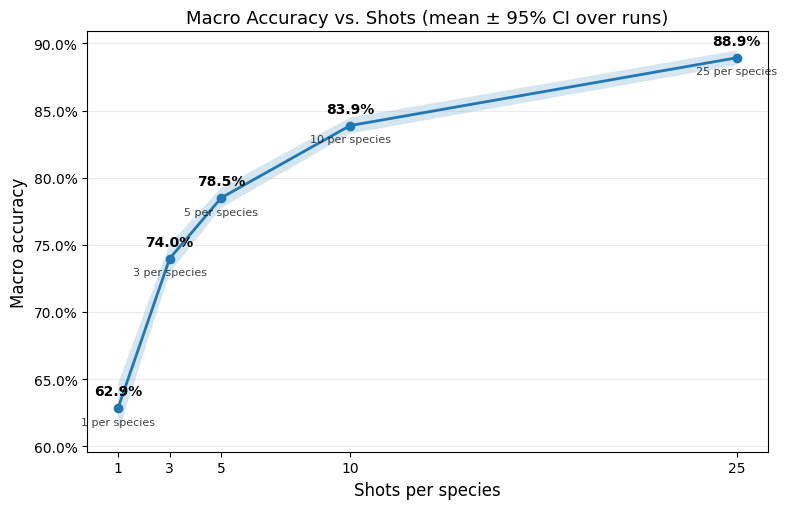

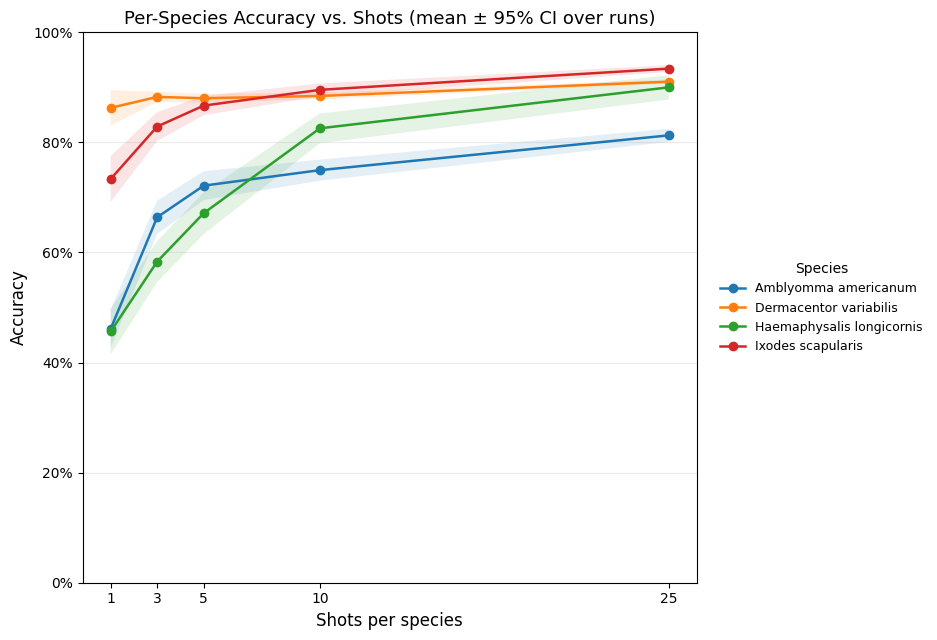

In [30]:
# === Block 8 — Visualization: Macro curve + per-species learning curves (CI, annotations, pagination) ===
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import math
import numpy as np

# ---------- 1) Macro accuracy with 95% CI ribbon + value annotations ----------
fig, ax = plt.subplots(figsize=(8.0, 5.2))

x  = agg_shots["shots"].to_numpy()
y  = agg_shots["mean_macro"].to_numpy()   # 0..1
ci = agg_shots["ci95_macro"].to_numpy()   # half-width

ax.plot(x, y, marker="o", linewidth=2.0)
ax.fill_between(x, y - ci, y + ci, alpha=0.18, linewidth=0)

# Annotate each dot: % above, and "K per species" below
for xi, yi in zip(x, y):
    ax.annotate(f"{yi*100:.1f}%", (xi, yi),
                textcoords="offset points", xytext=(0, 9),
                ha="center", fontsize=10, fontweight="semibold")
    ax.annotate(f"{int(xi)} per species", (xi, yi),
                textcoords="offset points", xytext=(0, -12),
                ha="center", fontsize=8, alpha=0.75)

ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("Shots per species", fontsize=12)
ax.set_ylabel("Macro accuracy", fontsize=12)
ax.set_title("Macro Accuracy vs. Shots (mean ± 95% CI over runs)", fontsize=13)
ax.set_xticks(x)
ax.grid(True, axis="y", alpha=0.25)
plt.tight_layout()

if SAVE_PLOTS:
    out = PLOTS_DIR / "macro_accuracy_curve.png"
    plt.savefig(out, dpi=200)
    print(f"[PLOT] saved {out}")
plt.show()

# ---------- 2) Per-species learning curves (95% CI, sorted, paginated) ----------
# We'll sort species by accuracy at the largest K to highlight easy ↔ hard taxa
K_max = int(np.max(per_species_summary["shots"]))
lastK = (per_species_summary.query("shots == @K_max")
         .sort_values("acc_mean", ascending=False)["species"].tolist())

species_order = lastK
shots_grid = np.sort(per_species_summary["shots"].unique())

# Pagination so legends don't explode; 10–12 species per page is comfy for talks
SPEC_PER_PAGE = 12
num_pages = math.ceil(len(species_order) / SPEC_PER_PAGE)

for page in range(num_pages):
    start = page * SPEC_PER_PAGE
    end   = start + SPEC_PER_PAGE
    subset = species_order[start:end]
    subdf = per_species_summary[per_species_summary["species"].isin(subset)].copy()

    fig, ax = plt.subplots(figsize=(9.5, 6.5))
    for sp, g in subdf.groupby("species"):
        g = (g.set_index("shots")
               .reindex(shots_grid)
               .reset_index())
        y  = g["acc_mean"].to_numpy()
        ci = g["acc_ci95"].to_numpy()
        ax.plot(shots_grid, y, marker="o", linewidth=1.8, label=sp)
        # CI ribbon (nan-safe)
        lo = (y - ci); hi = (y + ci)
        ax.fill_between(shots_grid, lo, hi, alpha=0.12, linewidth=0)

    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_xticks(shots_grid)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("Shots per species", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ttl = "Per-Species Accuracy vs. Shots (mean ± 95% CI over runs)"
    if num_pages > 1:
        ttl += f"  —  page {page+1}/{num_pages}"
    ax.set_title(ttl, fontsize=13)
    ax.grid(True, axis="y", alpha=0.25)

    # Put legend outside; scroll-proof in slides
    leg = ax.legend(title="Species", loc="center left", bbox_to_anchor=(1.02, 0.5),
                    frameon=False, fontsize=9, title_fontsize=10)
    plt.tight_layout()
    
    if SAVE_PLOTS:
        out = PLOTS_DIR / f"species_learning_curves_page{page+1:02d}.png"
        plt.savefig(out, dpi=200, bbox_inches="tight")
        print(f"[PLOT] saved {out}")
    plt.show()

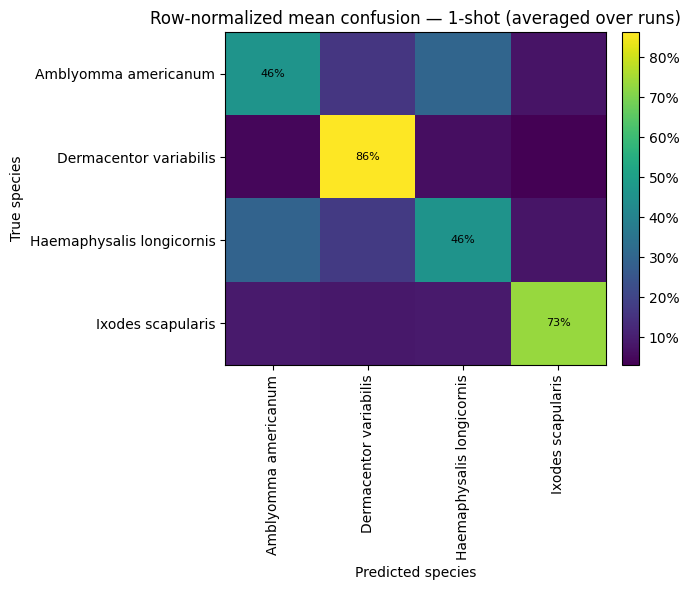

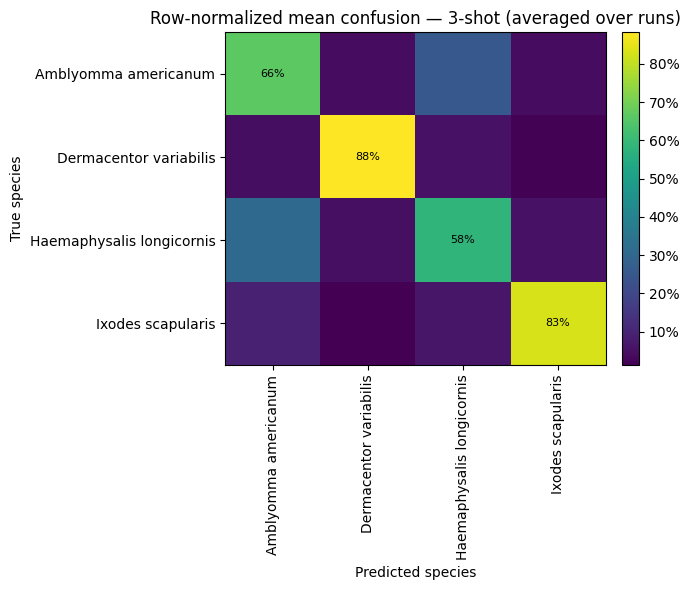

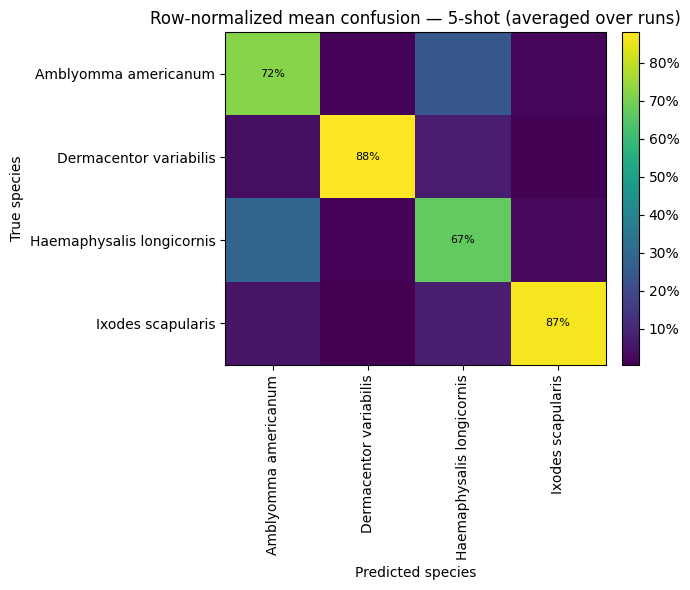

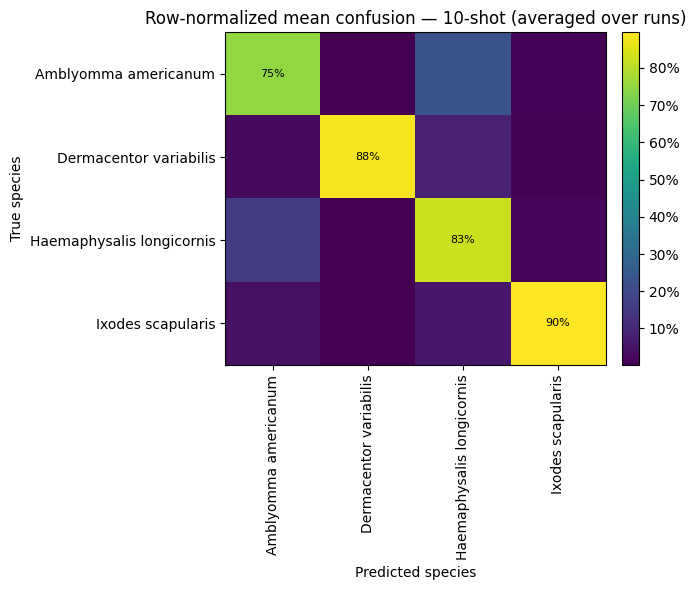

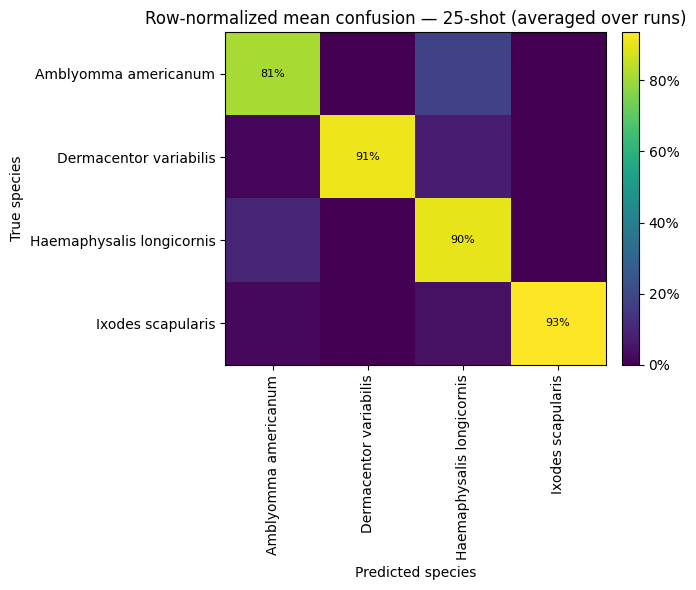

In [31]:
# === Block 9A — Row-normalized mean confusion per K (averaged over runs) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def mean_rownorm_confusion_for_K(df, K, class_order=None):
    """
    For a given shots K:
      - builds confusion per run (rows=true species)
      - row-normalizes each run's confusion
      - averages row-normalized matrices over runs (species with no test rows in a run are skipped for that row's average)
    Returns:
      classes (list), mean_conf (n_classes x n_classes), counts_per_row (how many runs contributed per row)
    """
    dK = df[df["shots"] == K].copy()
    if class_order is None:
        classes = sorted(pd.unique(dK["species_true"]))
    else:
        # keep only classes that actually appear at K (in case some drop out)
        classes = [c for c in class_order if c in set(dK["species_true"])]
    n = len(classes)
    if n == 0:
        raise ValueError(f"No classes present at K={K}.")

    # Accumulators
    mean_conf = np.zeros((n, n), dtype=float)
    row_counts = np.zeros(n, dtype=int)  # how many runs had nonzero test for that row

    for run_id, dKr in dK.groupby("run_id"):
        # confusion counts for this run
        ct = pd.crosstab(
            pd.Series(dKr["species_true"], name="true"),
            pd.Series(dKr["species_pred"], name="pred")
        )
        # align to full grid
        ct = ct.reindex(index=classes, columns=classes, fill_value=0)
        m = ct.to_numpy().astype(float)

        # row-normalize (skip rows with zero)
        row_sums = m.sum(axis=1, keepdims=True)
        nonzero_rows = (row_sums[:, 0] > 0)
        if not np.any(nonzero_rows):
            continue
        m_norm = np.zeros_like(m)
        m_norm[nonzero_rows] = m[nonzero_rows] / row_sums[nonzero_rows]

        mean_conf[nonzero_rows] += m_norm[nonzero_rows]
        row_counts[nonzero_rows] += 1

    # finalize mean: divide each row by number of contributing runs
    for i in range(n):
        if row_counts[i] > 0:
            mean_conf[i] /= row_counts[i]

    return classes, mean_conf, row_counts

def plot_mean_confusion(K, classes, mean_conf, counts_per_row, outpath):
    n = len(classes)
    fig_h = max(6, 0.45 * n)
    fig_w = max(7, 0.6 * n)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(mean_conf, aspect="auto")  # default colormap; normalized 0..1

    # axes + labels
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted species")
    ax.set_ylabel("True species")
    ax.set_title(f"Row-normalized mean confusion — {K}-shot (averaged over runs)")

    # colorbar in percentage
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    # annotate diagonal (optional): show mean recall per species
    for i in range(n):
        ax.text(i, i, f"{mean_conf[i, i]*100:.0f}%",
                ha="center", va="center", fontsize=8, color="black")

    plt.tight_layout()
    
    if SAVE_PLOTS:
        outpath.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(outpath, dpi=200, bbox_inches="tight")
        print(f"[PLOT] saved {outpath}")
    plt.show()

# Choose K values you want to present (e.g., all from SHOTS)
for K in SHOTS:
    classes, M, counts = mean_rownorm_confusion_for_K(df, K, class_order=CLASS_ORDER)
    plot_mean_confusion(K, classes, M, counts, PLOTS_DIR / f"confusion_mean_rownorm_K{K:02d}.png")

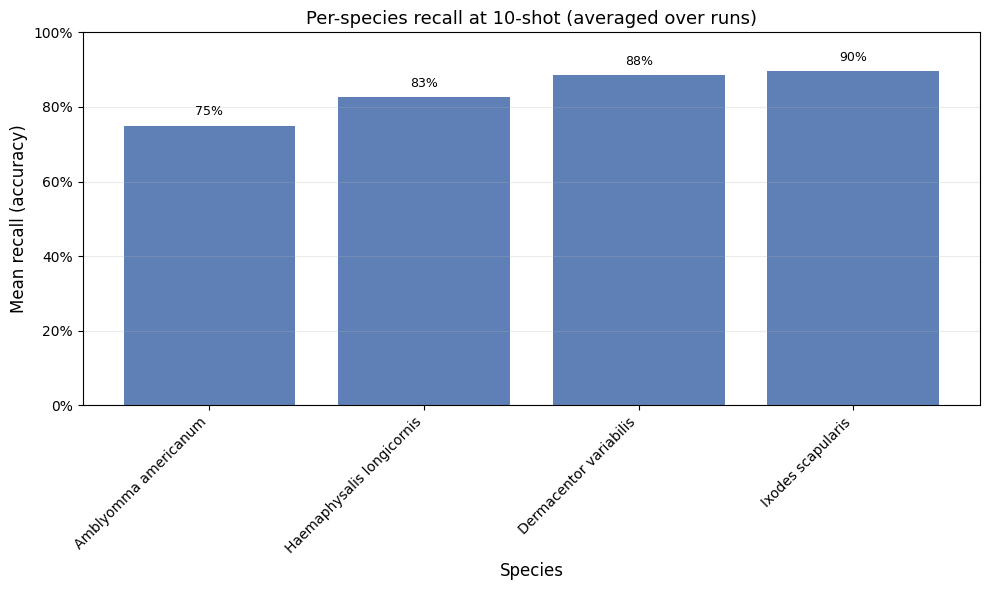

In [32]:
# === Block 9B — Simple per-species recall bar chart (vertical version) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

K_BAR = 10  # choose which shot level to show
sub = per_species_summary[per_species_summary["shots"] == K_BAR].copy()
if len(sub) == 0:
    raise ValueError(f"No per-species summary found for shots={K_BAR}. Run Block 7 first.")

# Harmonize column names
if "species_true" in sub.columns and "species" not in sub.columns:
    sub = sub.rename(columns={"species_true": "species"})

# Sort from lowest → highest accuracy
sub = sub.sort_values("acc_mean", ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))

# --- vertical bars ---
ax.bar(sub["species"], sub["acc_mean"], color="#4C72B0", alpha=0.9)

# --- format axes ---
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylabel("Mean recall (accuracy)", fontsize=12)
ax.set_xlabel("Species", fontsize=12)
ax.set_title(f"Per-species recall at {K_BAR}-shot (averaged over runs)", fontsize=13)
ax.grid(axis="y", alpha=0.25)

# Rotate labels so they don't overlap
plt.xticks(rotation=45, ha="right")

# Annotate bars with % values above them
for i, val in enumerate(sub["acc_mean"]):
    ax.text(i, val + 0.02, f"{val*100:.0f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()

if SAVE_PLOTS:
    out = PLOTS_DIR / f"per_species_recall_K{K_BAR:02d}.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print(f"[PLOT] saved {out}")
plt.show()

## Block 10: error analysis

In [ ]:
# === Block 10 — Error analysis: CSVs for ALL samples with full stats + image paths ===

from pathlib import Path
import pandas as pd
import numpy as np

# Path to your JSON metadata file
META_JSON = paths['processed_dir'] / 'final_data_no_ixodes.json'

# Helper functions 
def choose_most_dominant_value(series: pd.Series):
    """Return the most dominant (most frequent) non-null value in a Series."""
    s = series.dropna()
    if s.empty:
        return np.nan
    mode_values = s.mode()
    if len(mode_values) > 0:
        return mode_values.iloc[0]
    return s.iloc[0]

def count_incorrect(series: pd.Series) -> int:
    """Count how many entries are incorrect (assumes 0 = incorrect, 1 = correct)."""
    return int((series == 0).sum())

def count_correct(series: pd.Series) -> int:
    """Count how many entries are correct (assumes 0 = incorrect, 1 = correct)."""
    return int((series == 1).sum())

# ---------------------------------------------------------------------
# 1) Load predictions from this run
# ---------------------------------------------------------------------
df_pred = pd.read_csv(PREDICTIONS_CSV)
print(f"[LOAD] Predictions: {PREDICTIONS_CSV.name}, rows = {len(df_pred)}")

# Ensure types are consistent
df_pred["shots"] = df_pred["shots"].astype(int)
df_pred["run_id"] = df_pred["run_id"].astype(int)
df_pred["correct"] = df_pred["correct"].astype(int)
df_pred["sample_id"] = df_pred["sample_id"].astype(str)

# ---------------------------------------------------------------------
# 2) Load metadata from JSON
# ---------------------------------------------------------------------
if not META_JSON.exists():
    raise FileNotFoundError(f"Metadata JSON not found at {META_JSON}.")

meta_df = pd.read_json(META_JSON)
meta_df["sample_id"] = meta_df["sample_id"].astype(str)

print(f"[LOAD] Metadata JSON: {META_JSON.name}, rows = {len(meta_df)}")

# ---------------------------------------------------------------------
# 3) Collapse metadata to one row per sample_id (with image paths)
# ---------------------------------------------------------------------
# Dominant scalar fields per sample
meta_sample = (
    meta_df
    .groupby("sample_id", as_index=False)
    .agg(
        species_true=("true_label", choose_most_dominant_value),
        sex=("sex", choose_most_dominant_value),
        life_stage=("life_stage", choose_most_dominant_value),
        attached=("attached", choose_most_dominant_value),
    )
)

# Representative dorsal/ventral image paths
dorsal_paths = (
    meta_df[meta_df["view"] == "dorsal"]
    .groupby("sample_id")["image_path"]
    .first()
    .rename("dorsal_image_path")
)
ventral_paths = (
    meta_df[meta_df["view"] == "ventral"]
    .groupby("sample_id")["image_path"]
    .first()
    .rename("ventral_image_path")
)

meta_sample = (
    meta_sample
    .merge(dorsal_paths, on="sample_id", how="left")
    .merge(ventral_paths, on="sample_id", how="left")
)

print(f"[META] Collapsed to {len(meta_sample)} unique sample_ids")

# ---------------------------------------------------------------------
# 4) Build per-sample prediction summary (ALL samples)
# ---------------------------------------------------------------------
# Basic stats per sample_id
sample_stats = (
    df_pred
    .groupby("sample_id", as_index=False)
    .agg(
        n_rows=("correct", "size"),
        n_incorrect=("correct", count_incorrect),
        n_correct=("correct", count_correct),
        mean_conf_overall=("conf_top1", "mean"),
    )
)

sample_stats["incorrect_rate"] = sample_stats["n_incorrect"] / sample_stats["n_rows"]

# Most common wrong label per sample (if any)
wrong_rows = df_pred[df_pred["correct"] == 0].copy()

if len(wrong_rows) > 0:
    wrong_summary = (
        wrong_rows
        .groupby(["sample_id", "species_pred"], as_index=False)
        .agg(
            n_incorrect_pred=("species_pred", "size"),
            mean_conf_when_wrong=("conf_top1", "mean"),
        )
        .sort_values(
            ["sample_id", "n_incorrect_pred", "mean_conf_when_wrong"],
            ascending=[True, False, False],
        )
    )

    top_wrong_per_sample = (
        wrong_summary
        .groupby("sample_id", as_index=False)
        .head(1)
        .rename(
            columns={
                "species_pred": "most_common_wrong_pred",
                "n_incorrect_pred": "n_incorrect_to_most_common",
                "mean_conf_when_wrong": "mean_conf_to_most_common",
            }
        )
        [["sample_id", "most_common_wrong_pred", "n_incorrect_to_most_common", "mean_conf_to_most_common"]]
    )
else:
    top_wrong_per_sample = pd.DataFrame(
        columns=["sample_id", "most_common_wrong_pred", "n_incorrect_to_most_common", "mean_conf_to_most_common"]
    )

sample_stats = sample_stats.merge(top_wrong_per_sample, on="sample_id", how="left")

# Error rate by shot level per sample (err_by_shot_K)
shot_stats = (
    df_pred
    .groupby(["sample_id", "shots"], as_index=False)
    .agg(
        n_rows_shot=("correct", "size"),
        n_incorrect_shot=("correct", count_incorrect),
    )
)

# Pivot shot-level error rates into columns
pivot_nrows = shot_stats.pivot(index="sample_id", columns="shots", values="n_rows_shot")
pivot_ninc = shot_stats.pivot(index="sample_id", columns="shots", values="n_incorrect_shot")
err_by_shot = pivot_ninc / pivot_nrows

# Rename columns like err_by_shot_1, err_by_shot_3, ...
err_by_shot.columns = [f"err_by_shot_{int(k)}" for k in err_by_shot.columns]
err_by_shot = err_by_shot.reset_index()

sample_stats = sample_stats.merge(err_by_shot, on="sample_id", how="left")

# Attach metadata to the sample stats (ALL samples, including image paths)
sample_summary = sample_stats.merge(meta_sample, on="sample_id", how="left")

# Reorder columns for clarity
col_order = [
    "sample_id", "species_true",
    "n_rows", "n_correct", "n_incorrect", "incorrect_rate",
    "most_common_wrong_pred", "n_incorrect_to_most_common", "mean_conf_to_most_common",
    "mean_conf_overall"
]
# Add err_by_shot columns
err_cols = [c for c in sample_summary.columns if c.startswith("err_by_shot_")]
col_order.extend(sorted(err_cols, key=lambda x: int(x.split("_")[-1])))
# Add metadata columns
col_order.extend(["sex", "life_stage", "attached", "dorsal_image_path", "ventral_image_path"])
# Keep only columns that exist
col_order = [c for c in col_order if c in sample_summary.columns]
sample_summary = sample_summary[col_order]

# Sort by incorrect_rate descending (hardest samples first)
sample_summary = sample_summary.sort_values(
    ["incorrect_rate", "n_incorrect"],
    ascending=[False, False]
).reset_index(drop=True)

print(f"[SAMPLE] sample_summary: {len(sample_summary)} samples (ALL samples included)")

# ---------------------------------------------------------------------
# 5) Species-level summary
# ---------------------------------------------------------------------
species_summary = (
    df_pred
    .groupby("species_true", as_index=False)
    .agg(
        n_total_rows=("correct", "size"),
        n_total_incorrect=("correct", count_incorrect),
        n_total_correct=("correct", count_correct),
    )
)
species_summary["error_rate"] = species_summary["n_total_incorrect"] / species_summary["n_total_rows"]

# Most confused-with per species
confusion_summary = (
    df_pred
    .groupby(["species_true", "species_pred"], as_index=False)
    .size()
    .rename(columns={"size": "count"})
)

true_totals = (
    confusion_summary
    .groupby("species_true", as_index=False)["count"]
    .sum()
    .rename(columns={"count": "true_total"})
)

confusion_summary = confusion_summary.merge(true_totals, on="species_true", how="left")
confusion_summary["rate_within_true"] = confusion_summary["count"] / confusion_summary["true_total"]

# Most confused-with per species (ignore diagonal)
wrong_confusion = confusion_summary[confusion_summary["species_true"] != confusion_summary["species_pred"]].copy()

if len(wrong_confusion) > 0:
    most_confused_with = (
        wrong_confusion
        .sort_values(["species_true", "count"], ascending=[True, False])
        .groupby("species_true", as_index=False)
        .head(1)
        .rename(
            columns={
                "species_pred": "most_confused_with",
                "count": "misclass_count",
                "rate_within_true": "misclass_rate_within_true",
            }
        )
        [["species_true", "most_confused_with", "misclass_count", "misclass_rate_within_true"]]
    )
else:
    most_confused_with = pd.DataFrame(
        columns=["species_true", "most_confused_with", "misclass_count", "misclass_rate_within_true"]
    )

species_summary = species_summary.merge(most_confused_with, on="species_true", how="left")

print(f"[SPECIES] species_summary: {len(species_summary)} species")
print(f"[CONFUSION] confusion_summary: {len(confusion_summary)} pairs")

# ---------------------------------------------------------------------
# 6) Save CSVs to ANALYSIS_DIR
# ---------------------------------------------------------------------

# sample_summary.csv - ALL samples with full stats + image paths (sorted by incorrect_rate)
sample_summary.to_csv(ANALYSIS_DIR / "sample_summary.csv", index=False)
print(f"[SAVE] sample_summary.csv -> {ANALYSIS_DIR} ({len(sample_summary)} rows, sorted by incorrect_rate)")

# species_summary.csv
species_summary.to_csv(ANALYSIS_DIR / "species_summary.csv", index=False)
print(f"[SAVE] species_summary.csv -> {ANALYSIS_DIR} ({len(species_summary)} rows)")

# confusion_summary.csv
confusion_summary.to_csv(ANALYSIS_DIR / "confusion_summary.csv", index=False)
print(f"[SAVE] confusion_summary.csv -> {ANALYSIS_DIR} ({len(confusion_summary)} rows)")

# ---------------------------------------------------------------------
# 7) Preview in notebook
# ---------------------------------------------------------------------
from IPython.display import display

print("\n" + "=" * 60)
print("Block 10 Error Analysis Complete")
print("=" * 60)

print("\n[SAMPLE SUMMARY PREVIEW] (first 5 rows, sorted by incorrect_rate)")
display(sample_summary.head())

print("\n[SPECIES SUMMARY]")
display(species_summary)

print("\n[CONFUSION SUMMARY] (top 10 by count)")
display(confusion_summary.sort_values("count", ascending=False).head(10))

print(f"\n[INFO] All {len(sample_summary)} samples saved to sample_summary.csv")
print(f"[INFO] Sorted by incorrect_rate descending (hardest samples first)")
print("=" * 60)

In [ ]:
# === Block 11 — HTML Error Gallery for ALL Samples ===
# Builds an interactive HTML viewer from sample_summary.csv
# Images are embedded as base64 data URIs to avoid browser security issues

from pathlib import Path
import pandas as pd
import html
import base64
from PIL import Image
import io

gallery_path = ANALYSIS_DIR / "sample_gallery.html"

# ---------------------------------------------------------------------
# 1) Load the sample summary we created in Block 10
# ---------------------------------------------------------------------
sample_summary_path = ANALYSIS_DIR / "sample_summary.csv"

if not sample_summary_path.exists():
    raise FileNotFoundError("sample_summary.csv not found. Run Block 10 first.")

sample_df = pd.read_csv(sample_summary_path)
print(f"[LOAD] Sample summary: {len(sample_df)} samples")

# ---------------------------------------------------------------------
# 2) Helper to generate HTML for one sample row
# ---------------------------------------------------------------------

# Cache for base64-encoded images (path -> data URI)
_img_cache = {}

def image_to_base64(path, max_size=400):
    """Convert image to base64 data URI, resizing for reasonable HTML file size."""
    if path in _img_cache:
        return _img_cache[path]

    try:
        img = Image.open(path).convert("RGB")
        # Resize to reduce HTML file size while keeping quality
        img.thumbnail((max_size, max_size), Image.LANCZOS)
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=85)
        b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
        data_uri = f"data:image/jpeg;base64,{b64}"
        _img_cache[path] = data_uri
        return data_uri
    except Exception as e:
        print(f"[WARN] Could not encode image {path}: {e}")
        return None

def make_image_tag(path, label):
    """Return an <img> tag with embedded base64 image, or a placeholder if missing."""
    if pd.isna(path) or not Path(str(path)).exists():
        return f'<div class="img-missing">No {html.escape(label)} image</div>'

    data_uri = image_to_base64(str(path))
    if data_uri is None:
        return f'<div class="img-missing">Could not load {html.escape(label)} image</div>'

    return f'<img src="{data_uri}" alt="{html.escape(label)}" class="tick-image">'

def sample_card(row):
    """Return HTML for a single sample card with dorsal/ventral and metadata."""
    sample_id = str(row.get("sample_id", ""))
    true_species = row.get("species_true", "")
    most_common_pred = row.get("most_common_wrong_pred", "")
    incorrect_rate = row.get("incorrect_rate", "")
    n_incorrect = row.get("n_incorrect", "")
    n_rows = row.get("n_rows", "")
    sex = row.get("sex", "")
    life_stage = row.get("life_stage", "")
    attached = row.get("attached", "")
    dorsal_path = row.get("dorsal_image_path", "")
    ventral_path = row.get("ventral_image_path", "")

    dorsal_img = make_image_tag(dorsal_path, "dorsal")
    ventral_img = make_image_tag(ventral_path, "ventral")

    def fmt(x):
        if isinstance(x, float):
            if pd.isna(x):
                return ""
            return f"{x:.3f}"
        return "" if pd.isna(x) else str(x)

    # Determine status badge
    if n_incorrect == 0:
        status_badge = '<span class="badge correct">All Correct</span>'
    elif incorrect_rate > 0.5:
        status_badge = '<span class="badge hard">Hard Sample</span>'
    else:
        status_badge = '<span class="badge some-errors">Some Errors</span>'

    html_block = f"""
    <div class="sample-card" data-species="{html.escape(fmt(true_species))}" data-incorrect="{fmt(n_incorrect)}" data-rate="{fmt(incorrect_rate)}">
      <div class="meta">
        <div><strong>Sample ID:</strong> {html.escape(fmt(sample_id))} {status_badge}</div>
        <div><strong>True species:</strong> {html.escape(fmt(true_species))}</div>
        <div><strong>Most common wrong prediction:</strong> {html.escape(fmt(most_common_pred)) if fmt(most_common_pred) else 'N/A'}</div>
        <div><strong>Incorrect:</strong> {html.escape(fmt(n_incorrect))} / {html.escape(fmt(n_rows))} 
             (rate = {html.escape(fmt(incorrect_rate))})</div>
        <div><strong>Sex:</strong> {html.escape(fmt(sex))}</div>
        <div><strong>Life stage:</strong> {html.escape(fmt(life_stage))}</div>
        <div><strong>Attached:</strong> {html.escape(fmt(attached))}</div>
      </div>
      <div class="images">
        <div class="image-column">
          <div class="image-label">Dorsal</div>
          {dorsal_img}
        </div>
        <div class="image-column">
          <div class="image-label">Ventral</div>
          {ventral_img}
        </div>
      </div>
    </div>
    """
    return html_block

# ---------------------------------------------------------------------
# 3) Build the HTML document with all samples
# ---------------------------------------------------------------------

print("[INFO] Encoding images as base64 (this may take a moment)...")

# Sort by incorrect_rate descending (hardest samples first)
sample_df_sorted = sample_df.sort_values(
    ["incorrect_rate", "n_incorrect"], 
    ascending=[False, False]
).reset_index(drop=True)

all_cards = "\n".join(sample_card(row) for _, row in sample_df_sorted.iterrows())

print(f"[INFO] Encoded {len(_img_cache)} unique images")

# Get unique species for filter dropdown
species_list = sorted(sample_df["species_true"].dropna().unique())
species_options = "\n".join(f'<option value="{html.escape(s)}">{html.escape(s)}</option>' for s in species_list)

full_html = f"""
<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <title>Tick Sample Gallery - Run {RUN_ID}</title>
  <style>
    body {{
      font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", sans-serif;
      margin: 20px;
      background-color: #111;
      color: #eee;
    }}
    h1, h2, h3 {{
      color: #ffcc66;
    }}
    .filters {{
      background: #222;
      padding: 15px;
      border-radius: 8px;
      margin-bottom: 20px;
      display: flex;
      gap: 20px;
      flex-wrap: wrap;
      align-items: center;
    }}
    .filters label {{
      font-weight: bold;
    }}
    .filters select, .filters input {{
      padding: 8px;
      border-radius: 4px;
      border: 1px solid #444;
      background: #333;
      color: #eee;
    }}
    .stats {{
      background: #1a1a2e;
      padding: 10px 15px;
      border-radius: 8px;
      margin-bottom: 20px;
    }}
    .sample-card {{
      border: 1px solid #444;
      border-radius: 10px;
      padding: 12px;
      margin: 12px 0;
      background-color: #1b1b1b;
      display: flex;
      flex-direction: column;
      gap: 8px;
    }}
    .sample-card.hidden {{
      display: none;
    }}
    .badge {{
      padding: 2px 8px;
      border-radius: 4px;
      font-size: 0.8rem;
      margin-left: 10px;
    }}
    .badge.correct {{
      background: #2d5a27;
      color: #90EE90;
    }}
    .badge.hard {{
      background: #5a2727;
      color: #FF6B6B;
    }}
    .badge.some-errors {{
      background: #5a4a27;
      color: #FFD93D;
    }}
    .meta {{
      font-size: 0.9rem;
      line-height: 1.4;
    }}
    .images {{
      display: flex;
      flex-direction: row;
      gap: 16px;
      margin-top: 8px;
    }}
    .image-column {{
      flex: 1;
      text-align: center;
    }}
    .image-label {{
      margin-bottom: 4px;
      font-size: 0.85rem;
      color: #ccc;
    }}
    .tick-image {{
      max-width: 320px;
      max-height: 320px;
      border-radius: 8px;
      border: 1px solid #555;
      background-color: #000;
    }}
    .img-missing {{
      color: #888;
      font-size: 0.85rem;
      border: 1px dashed #555;
      border-radius: 8px;
      padding: 20px;
    }}
  </style>
</head>
<body>
  <h1>Tick Sample Gallery</h1>
  <p>Run ID: {RUN_ID} | Total samples: {len(sample_df)} | Sorted by: incorrect_rate (highest first)</p>
  
  <div class="filters">
    <div>
      <label>Species: </label>
      <select id="speciesFilter" onchange="filterSamples()">
        <option value="all">All Species</option>
        {species_options}
      </select>
    </div>
    <div>
      <label>Show: </label>
      <select id="errorFilter" onchange="filterSamples()">
        <option value="all">All Samples</option>
        <option value="errors">Only With Errors</option>
        <option value="hard">Hard Samples (>50% error)</option>
        <option value="correct">All Correct</option>
      </select>
    </div>
    <div>
      <label>Min errors: </label>
      <input type="number" id="minErrors" value="0" min="0" onchange="filterSamples()" style="width:60px">
    </div>
  </div>
  
  <div class="stats" id="stats">
    Showing all {len(sample_df)} samples
  </div>
  
  <div id="samples">
    {all_cards}
  </div>
  
  <script>
    function filterSamples() {{
      const species = document.getElementById('speciesFilter').value;
      const errorType = document.getElementById('errorFilter').value;
      const minErrors = parseInt(document.getElementById('minErrors').value) || 0;
      
      const cards = document.querySelectorAll('.sample-card');
      let visible = 0;
      
      cards.forEach(card => {{
        const cardSpecies = card.dataset.species;
        const cardIncorrect = parseInt(card.dataset.incorrect) || 0;
        const cardRate = parseFloat(card.dataset.rate) || 0;
        
        let show = true;
        
        if (species !== 'all' && cardSpecies !== species) show = false;
        if (errorType === 'errors' && cardIncorrect === 0) show = false;
        if (errorType === 'hard' && cardRate <= 0.5) show = false;
        if (errorType === 'correct' && cardIncorrect > 0) show = false;
        if (cardIncorrect < minErrors) show = false;
        
        card.classList.toggle('hidden', !show);
        if (show) visible++;
      }});
      
      document.getElementById('stats').textContent = `Showing ${{visible}} of {len(sample_df)} samples`;
    }}
  </script>
</body>
</html>
"""

# ---------------------------------------------------------------------
# 4) Write HTML file
# ---------------------------------------------------------------------
gallery_path.write_text(full_html, encoding="utf-8")

file_size_mb = gallery_path.stat().st_size / (1024 * 1024)
print(f"\n[SAVE] Sample gallery written to: {gallery_path}")
print(f"[INFO] File size: {file_size_mb:.1f} MB")
print(f"[INFO] Sorted by incorrect_rate (highest first)")
print(f"[INFO] Open in browser: file://{gallery_path.resolve()}")